# Analyze HPLC data and growth curves
- Go through different samples and identify peaks of specific substrates and the corresponding concentrations
- Plot these findings vs OD. 

To start, the script needs three different major types of data:
- The chromatograms from the HPLC runs 
- A spreadsheet with growth curves and names of the HPLC samples taken at specific times. One sample takes 5 columns (for time, od, corrected od, HPLC sample names, and notes), see example. 
- The coordination of the needed calibration curves (stored in json files e.g. calibration.json).

To work, the data have to be stored in the right format at the right locations.

In [5]:
#import required packages
import glob 
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 40)

import cremerlab.hplc
#!pip install cremerlab-utils

Prepare settings table
To process samples, settings are best stored in a spreadsheet (Standard location: hplc_settings.csv). To most easiestly add new samples to the spreadsheet you can use the following which is simply generating a list of samples in a specific folder. 

In [2]:
foldername="data_hplcrawdata/stan_YCA_230712_2.5mM"
cremerlab.hplc.generate_setting_template(foldername,output="hplc_settings_template.csv",hplc_machine="Shimadzu_ProminenceLC2030C") 

sample             foldername peak_assignment  \
17    230716_B.uniformis_1  stan_YCA_230712_2.5mM                   
10    230716_B.uniformis_2  stan_YCA_230712_2.5mM                   
36  230716_B.uniformis_2_1  stan_YCA_230712_2.5mM                   
39  230716_B.uniformis_2_2  stan_YCA_230712_2.5mM                   
37  230716_B.uniformis_2_3  stan_YCA_230712_2.5mM                   
33  230716_B.uniformis_2_4  stan_YCA_230712_2.5mM                   
32  230716_B.uniformis_2_5  stan_YCA_230712_2.5mM                   
13    230716_B.uniformis_3  stan_YCA_230712_2.5mM                   
29  230716_B.uniformis_3_1  stan_YCA_230712_2.5mM                   
28  230716_B.uniformis_3_2  stan_YCA_230712_2.5mM                   
27  230716_B.uniformis_3_3  stan_YCA_230712_2.5mM                   
26  230716_B.uniformis_3_4  stan_YCA_230712_2.5mM                   
25  230716_B.uniformis_3_5  stan_YCA_230712_2.5mM                   
2     230716_B.uniformis_4  stan_YCA_230712_2.5mM                   
3     230716_B.uniformis_5  stan_YCA_230712_2.5mM                   
7             230716_NCM_1  stan_YCA_230712_2.5mM                   
1             230716_NCM_2  stan_YCA_230712_2.5mM                   
4             230716_NCM_3  stan_YCA_230712_2.5mM                   
11            230716_NCM_4  stan_YCA_230712_2.5mM                   
12            230716_NCM_5  stan_YCA_230712_2.5mM                   
0         230716_P.copri_1  stan_YCA_230712_2.5mM                   
5         230716_P.copri_2  stan_YCA_230712_2.5mM                   
14      230716_P.copri_2_1  stan_YCA_230712_2.5mM                   
18      230716_P.copri_2_2  stan_YCA_230712_2.5mM                   
16      230716_P.copri_2_3  stan_YCA_230712_2.5mM                   
8       230716_P.copri_2_4  stan_YCA_230712_2.5mM                   
6       230716_P.copri_2_5  stan_YCA_230712_2.5mM                   
9         230716_P.copri_3  stan_YCA_230712_2.5mM                   
24      230716_P.copri_3_1  stan_YCA_230712_2.5mM                   
23      230716_P.copri_3_2  stan_YCA_230712_2.5mM                   
22      230716_P.copri_3_3  stan_YCA_230712_2.5mM                   
21      230716_P.copri_3_4  stan_YCA_230712_2.5mM                   
20      230716_P.copri_3_5  stan_YCA_230712_2.5mM                   
15        230716_P.copri_4  stan_YCA_230712_2.5mM                   
19        230716_P.copri_5  stan_YCA_230712_2.5mM                   
38       230716_R.bromii_1  stan_YCA_230712_2.5mM                   
34       230716_R.bromii_2  stan_YCA_230712_2.5mM                   
35       230716_R.bromii_3  stan_YCA_230712_2.5mM                   
30       230716_R.bromii_4  stan_YCA_230712_2.5mM                   
31       230716_R.bromii_5  stan_YCA_230712_2.5mM                   

                  hplc_machine peaks_manual peaks_autofitting  \
17  Shimadzu_ProminenceLC2030C           []              True   
10  Shimadzu_ProminenceLC2030C           []              True   
36  Shimadzu_ProminenceLC2030C           []              True   
39  Shimadzu_ProminenceLC2030C           []              True   
37  Shimadzu_ProminenceLC2030C           []              True   
33  Shimadzu_ProminenceLC2030C           []              True   
32  Shimadzu_ProminenceLC2030C           []              True   
13  Shimadzu_ProminenceLC2030C           []              True   
29  Shimadzu_ProminenceLC2030C           []              True   
28  Shimadzu_ProminenceLC2030C           []              True   
27  Shimadzu_ProminenceLC2030C           []              True   
26  Shimadzu_ProminenceLC2030C           []              True   
25  Shimadzu_ProminenceLC2030C           []              True   
2   Shimadzu_ProminenceLC2030C           []              True   
3   Shimadzu_ProminenceLC2030C           []              True   
7   Shimadzu_ProminenceLC2030C           []              True   
1   Shimadzu_ProminenceLC2030C           []              True   
4   Shimadzu_Promine

'Adjust hplc_settings_template.csv and copy rows to main settings table, e.g. hplc_settings.csv'

# Analysis growth samples from Palo Alto

All cultures in growth rate file data_growthcurves/stan_YCA_230424_2.5mM.csv:
['NCM', 'NCM_2', 'B.fragilis', 'B.fragilis_2', 'B.finegoldii', 'B.finegoldii_2', 'B.ovatus', 'B.ovatus_2', 'B.vulgatus', 'B.vulgatus_2', 'P.distastonis', 'P.distastonis_2']


/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1421: DtypeWarning: Columns (0,1,2,3,4,5,6,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  analysis_settings=pd.read_csv(filename_settings,skiprows=1,index_col=0)
/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1421: DtypeWarning: Columns (0,1,2,3,4,5,6,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  analysis_settings=pd.read_csv(filename_settings,skiprows=1,index_col=0)
Processing files...: 100%|████████████████████████| 5/5 [00:00<00:00, 11.58it/s]
/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1113: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list

[2, 3, 6]


retention_time  retention_time_firstguess     scale      skew  \
0        13.345268                   13.33333  0.197279 -0.100000   
1        15.779069                   15.77500  0.214572  0.100000   
2        18.550000                   18.85000  0.800000 -0.100000   
3        20.118098                   20.10000  0.289416  0.100000   
4        20.878304                   20.90000  0.156488 -0.100000   
5        21.727890                   21.74167  0.276353  0.099990   
6        23.332161                   23.25833  0.385759  0.023465   
7        24.951675                   24.97500  0.335669  0.100000   
8        28.844713                   28.80000  0.378280 -0.100000   
9        32.438840                   32.42500  0.795895  0.099983   
10       36.022782                   36.27500  0.800000 -0.000013   

       amplitude          area  peak_idx                     sample  
0   14814.916324   7326.052687         1  230419_NCM_1_chromatogram  
1   48146.780864  25895.793961         2  230419_NCM_1_chromatogram  
2     261.877496    525.143577         3  230419_NCM_1_chromatogram  
3     730.492522    529.941026         4  230419_NCM_1_chromatogram  
4     386.726431    151.696193         5  230419_NCM_1_chromatogram  
5    7306.203940   5061.115642         6  230419_NCM_1_chromatogram  
6     314.688652    304.289280         7  230419_NCM_1_chromatogram  
7    3300.036994   2776.640089         8  230419_NCM_1_chromatogram  
8    3139.361554   2975.140517         9  230419_NCM_1_chromatogram  
9     448.305352    893.497766        10  230419_NCM_1_chromatogram  
10    209.599218    420.309726        11  230419_NCM_1_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0       13.342771                   13.33333  0.197788 -0.100000   
1       15.777737                   15.77500  0.214472  0.100000   
2       18.541670                   18.84167  0.800000 -0.100000   
3       20.125341                   20.10000  0.305420  0.014255   
4       20.872263                   20.90000  0.154109 -0.012015   
5       21.749403                   21.75000  0.274450 -0.000224   
6       23.262556                   23.20833  0.381052  0.047017   
7       24.952889                   24.97500  0.346824  0.100000   
8       28.832189                   28.80000  0.402646 -0.052098   
9       32.510717                   32.40833  0.800000  0.000060   

      amplitude          area  peak_idx                     sample  
0  14737.163541   7306.425369         1  230419_NCM_2_chromatogram  
1  47787.408756  25690.645723         2  230419_NCM_2_chromatogram  
2    262.618081    526.628781         3  230419_NCM_2_chromatogram  
3    755.340772    578.268828         4  230419_NCM_2_chromatogram  
4    413.472911    159.721972         5  230419_NCM_2_chromatogram  
5   7340.859506   5050.095914         6  230419_NCM_2_chromatogram  
6    466.733172    445.802714         7  230419_NCM_2_chromatogram  
7   3604.035979   3133.198085         8  230419_NCM_2_chromatogram  
8   3236.260677   3258.207340         9  230419_NCM_2_chromatogram  
9    689.194053   1381.113107        10  230419_NCM_2_chromatogram

Peak butyrate not found in sample 230419_NCM_2_chromatogram


retention_time  retention_time_firstguess     scale      skew  \
0        13.345830                   13.33333  0.198331 -0.100000   
1        15.781735                   15.78333  0.214445  0.100000   
2        18.550000                   18.85000  0.800000 -0.100000   
3        20.116387                   20.10000  0.308666  0.043085   
4        20.896806                   20.90000  0.165451 -0.099995   
5        21.755000                   21.75000  0.274455  0.002191   
6        23.181224                   23.15833  0.325451  0.100000   
7        24.951161                   24.97500  0.323283  0.100000   
8        28.793294                   28.80833  0.358057  0.100000   
9        31.575000                   31.87500  0.270890 -0.099992   
10       32.500000                   32.20000  0.645663  0.100000   
11       36.419159                   36.43333  0.800000  0.005361   

       amplitude          area  peak_idx                     sample  
0   14684.618708   7300.357432         1  230419_NCM_3_chromatogram  
1   47037.628103  25284.362454         2  230419_NCM_3_chromatogram  
2     262.182853    525.756014         3  230419_NCM_3_chromatogram  
3     741.968988    574.070014         4  230419_NCM_3_chromatogram  
4     564.448146    234.090055         5  230419_NCM_3_chromatogram  
5    7331.607763   5043.835128         6  230419_NCM_3_chromatogram  
6     561.328768    457.923763         7  230419_NCM_3_chromatogram  
7    3691.054631   2991.048318         8  230419_NCM_3_chromatogram  
8    3036.591637   2725.046504         9  230419_NCM_3_chromatogram  
9     211.165430    143.385738        10  230419_NCM_3_chromatogram  
10    308.699906    499.570097        11  230419_NCM_3_chromatogram  
11    116.222122    233.059722        12  230419_NCM_3_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        13.342080                   13.33333  0.198659 -0.100000   
1        15.777950                   15.77500  0.214359  0.100000   
2        18.566670                   18.86667  0.800000 -0.100000   
3        20.093162                   20.08333  0.295164  0.099843   
4        20.906131                   20.90000  0.180948 -0.099787   
5        21.762891                   21.75000  0.275757 -0.058848   
6        23.157033                   23.15833  0.315282  0.100000   
7        24.946685                   24.96667  0.327530  0.100000   
8        28.789369                   28.80000  0.372388  0.100000   
9        31.534728                   31.79167  0.295953 -0.060069   
10       32.500000                   32.20000  0.735784  0.100000   
11       36.071888                   36.28333  0.800000 -0.003165   

       amplitude          area  peak_idx                     sample  
0   14590.844005   7265.715338         1  230419_NCM_4_chromatogram  
1   45981.762236  24706.869290         2  230419_NCM_4_chromatogram  
2     253.393827    508.131262         3  230419_NCM_4_chromatogram  
3     693.412112    513.032114         4  230419_NCM_4_chromatogram  
4     773.229580    350.713450         5  230419_NCM_4_chromatogram  
5    7318.755470   5058.869179         6  230419_NCM_4_chromatogram  
6     774.180856    611.830683         7  230419_NCM_4_chromatogram  
7    4005.978313   3288.888382         8  230419_NCM_4_chromatogram  
8    3109.875653   2901.379561         9  230419_NCM_4_chromatogram  
9     286.838898    212.789378        10  230419_NCM_4_chromatogram  
10    416.579972    768.087485        11  230419_NCM_4_chromatogram  
11    170.837085    342.579789        12  230419_NCM_4_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        13.342680                   13.33333  0.198914 -0.100000   
1        15.778652                   15.77500  0.214278  0.100000   
2        18.558330                   18.85833  0.800000 -0.100000   
3        20.108396                   20.10000  0.279618  0.030012   
4        20.901115                   20.90000  0.194085 -0.000185   
5        21.751187                   21.75000  0.276412 -0.005386   
6        23.140941                   23.14167  0.302989  0.100000   
7        24.946640                   24.96667  0.323958  0.100000   
8        28.792959                   28.80833  0.368505  0.100000   
9        31.592271                   31.80833  0.314934 -0.052476   
10       32.500000                   32.20000  0.709901  0.100000   
11       36.165158                   36.28333  0.800000 -0.000767   

       amplitude          area  peak_idx                     sample  
0   14482.845018   7221.190061         1  230419_NCM_5_chromatogram  
1   44758.340783  24040.427548         2  230419_NCM_5_chromatogram  
2     250.453715    502.235441         3  230419_NCM_5_chromatogram  
3     662.470652    464.324914         4  230419_NCM_5_chromatogram  
4     984.539078    478.976441         5  230419_NCM_5_chromatogram  
5    7323.548021   5074.213368         6  230419_NCM_5_chromatogram  
6     989.943827    751.843397         7  230419_NCM_5_chromatogram  
7    4274.730507   3471.258589         8  230419_NCM_5_chromatogram  
8    3090.813696   2853.857137         9  230419_NCM_5_chromatogram  
9     324.998100    256.560621        10  230419_NCM_5_chromatogram  
10    386.576683    687.757800        11  230419_NCM_5_chromatogram  
11    144.409987    289.585590        12  230419_NCM_5_chromatogram

/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:2051: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  growthrates = growthrates.append(dictc, ignore_index=True)


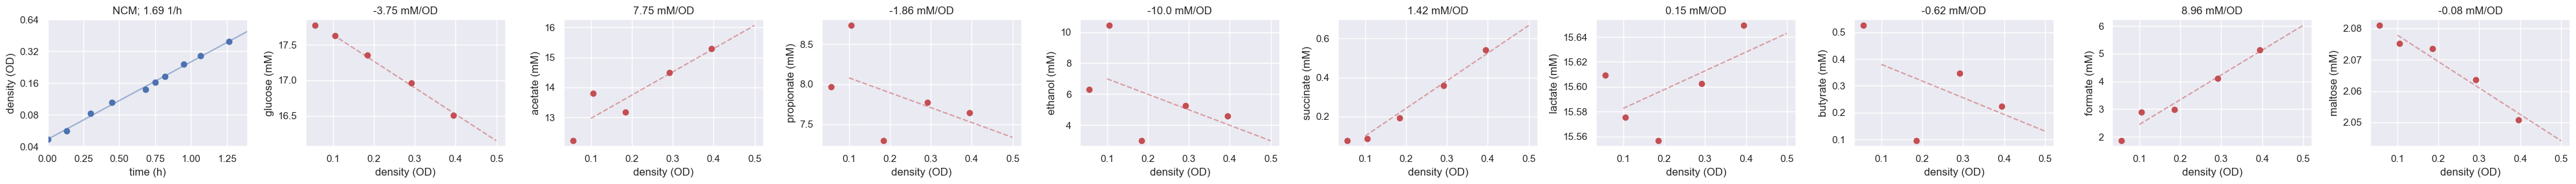

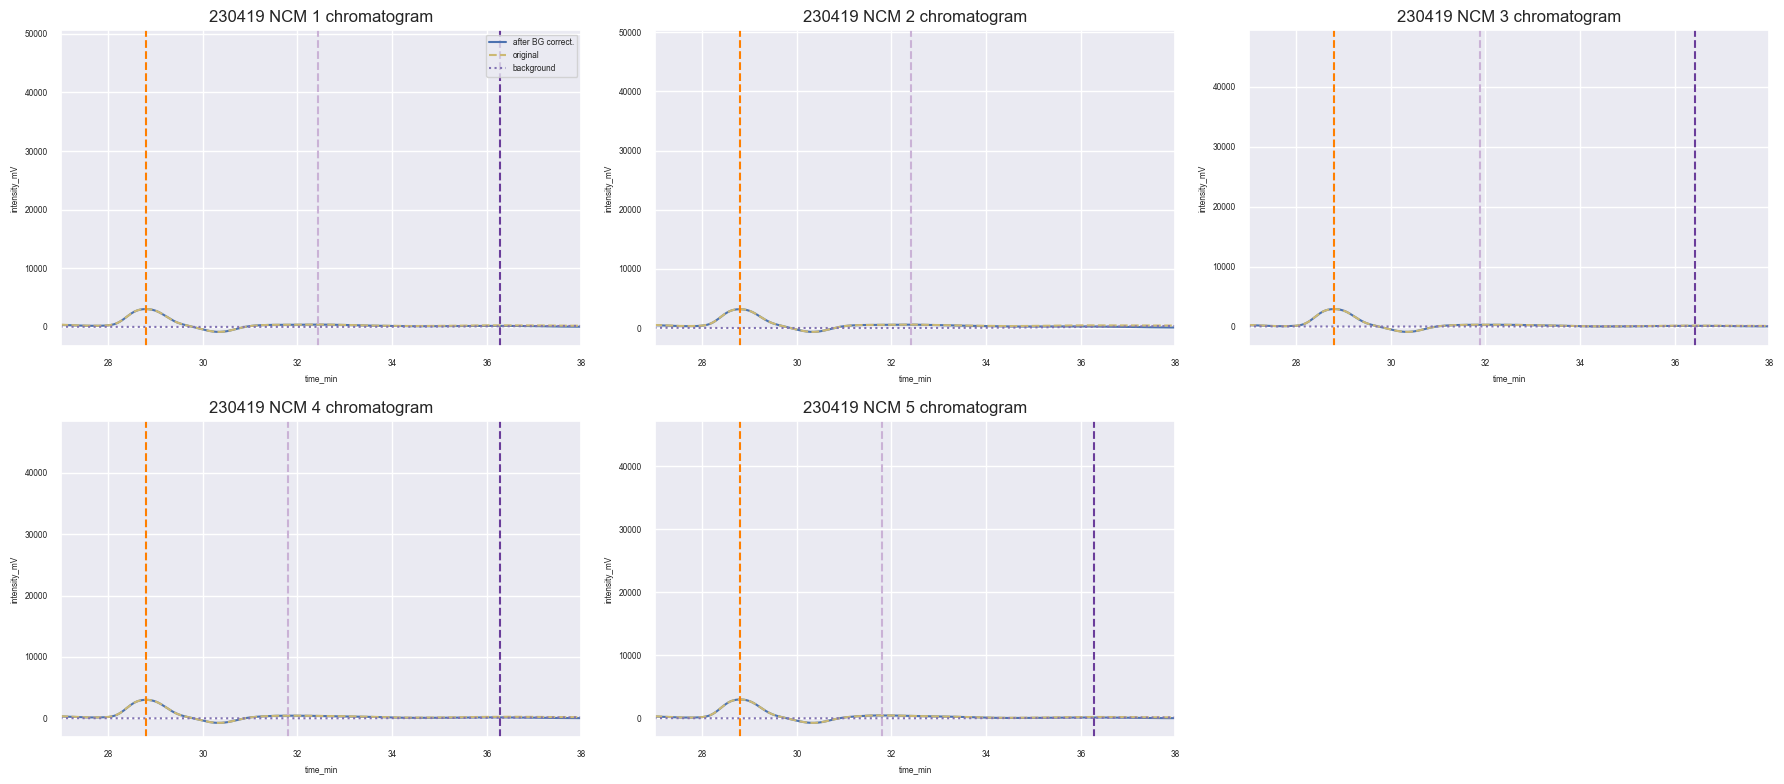

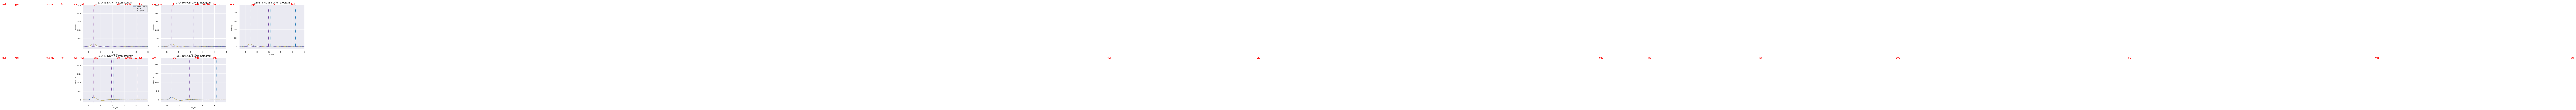

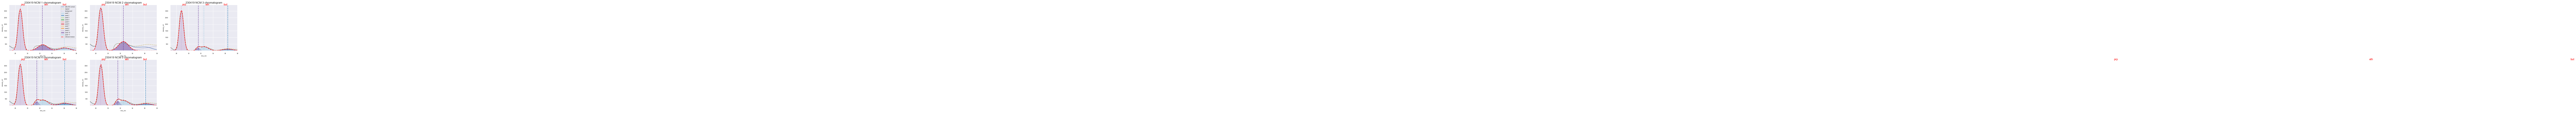

/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1421: DtypeWarning: Columns (0,1,2,3,4,5,6,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  analysis_settings=pd.read_csv(filename_settings,skiprows=1,index_col=0)
/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1421: DtypeWarning: Columns (0,1,2,3,4,5,6,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  analysis_settings=pd.read_csv(filename_settings,skiprows=1,index_col=0)
Processing files...: 100%|████████████████████████| 5/5 [00:00<00:00, 11.43it/s]
/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1113: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list

[2, 3, 6]


retention_time  retention_time_firstguess     scale      skew  \
0        13.344663                   13.33333  0.199283 -0.100000   
1        15.780249                   15.78333  0.214020  0.100000   
2        18.525000                   18.82500  0.800000 -0.100000   
3        20.126255                   20.10000  0.270933  0.011391   
4        20.816014                   20.90000  0.106158 -0.029118   
5        21.771744                   21.76667  0.266221  0.006465   
6        23.198946                   23.24167  0.525208 -0.019324   
7        24.981691                   24.98333  0.330581 -0.000294   
8        28.798453                   28.80833  0.365835  0.078452   
9        32.476342                   32.43333  0.736775  0.019881   
10       36.190622                   36.26667  0.800000 -0.000209   

       amplitude          area  peak_idx                       sample  
0   14609.311878   7297.781329         1  230419_NCM_2_1_chromatogram  
1   47779.802014  25632.395623         2  230419_NCM_2_1_chromatogram  
2     262.193756    525.777979         3  230419_NCM_2_1_chromatogram  
3     637.837137    433.173178         4  230419_NCM_2_1_chromatogram  
4     280.564774     74.658237         5  230419_NCM_2_1_chromatogram  
5   21130.239150  14100.563493         6  230419_NCM_2_1_chromatogram  
6     324.477190    427.174653         7  230419_NCM_2_1_chromatogram  
7    3314.223616   2746.314037         8  230419_NCM_2_1_chromatogram  
8    3071.492635   2815.917848         9  230419_NCM_2_1_chromatogram  
9     386.278340    712.971510        10  230419_NCM_2_1_chromatogram  
10    145.975934    292.725650        11  230419_NCM_2_1_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        13.343914                   13.33333  0.199654 -0.100000   
1        15.778786                   15.77500  0.213989  0.100000   
2        18.500000                   18.80000  0.800000 -0.100000   
3        20.113095                   20.10000  0.263348  0.100000   
4        20.821016                   20.90000  0.112815 -0.099823   
5        21.749510                   21.76667  0.267201  0.099999   
6        23.175231                   23.17500  0.442232 -0.003886   
7        24.950033                   24.96667  0.329566  0.100000   
8        28.790133                   28.80000  0.367461  0.100000   
9        32.479754                   32.41667  0.760447  0.031461   
10       36.179949                   36.34167  0.800000  0.000434   

       amplitude          area  peak_idx                       sample  
0   14571.301345   7292.345655         1  230419_NCM_2_2_chromatogram  
1   47555.866555  25508.506034         2  230419_NCM_2_2_chromatogram  
2     259.561066    520.498411         3  230419_NCM_2_2_chromatogram  
3     624.231241    412.064297         4  230419_NCM_2_2_chromatogram  
4     335.202587     94.790023         5  230419_NCM_2_2_chromatogram  
5   21098.628820  14131.296950         6  230419_NCM_2_2_chromatogram  
6     484.505222    537.079415         7  230419_NCM_2_2_chromatogram  
7    3572.125887   2950.930358         8  230419_NCM_2_2_chromatogram  
8    3076.964418   2833.332042         9  230419_NCM_2_2_chromatogram  
9     400.312091    762.501841        10  230419_NCM_2_2_chromatogram  
10    151.673516    304.151135        11  230419_NCM_2_2_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        13.324137                   13.32500  0.199171 -0.001893   
1        15.774327                   15.77500  0.213882  0.100000   
2        18.483330                   18.78333  0.800000 -0.100000   
3        20.130123                   20.09167  0.261712  0.025273   
4        20.823423                   20.90000  0.121232 -0.053870   
5        21.766418                   21.75833  0.266769  0.005651   
6        23.158867                   23.16667  0.403777 -0.002815   
7        24.969115                   24.96667  0.325978  0.005376   
8        28.788607                   28.80833  0.365553  0.097589   
9        32.439790                   32.35833  0.776541  0.099925   
10       36.216889                   36.33333  0.800000  0.000319   

       amplitude          area  peak_idx                       sample  
0   14576.890957   7277.461972         1  230419_NCM_2_3_chromatogram  
1   46948.753428  25170.301338         2  230419_NCM_2_3_chromatogram  
2     256.587410    514.535217         3  230419_NCM_2_3_chromatogram  
3     622.049449    408.073959         4  230419_NCM_2_3_chromatogram  
4     483.062129    146.794631         5  230419_NCM_2_3_chromatogram  
5   21167.106573  14154.222087         6  230419_NCM_2_3_chromatogram  
6     605.775000    613.116535         7  230419_NCM_2_3_chromatogram  
7    3726.142130   3044.650051         8  230419_NCM_2_3_chromatogram  
8    3073.941157   2815.918289         9  230419_NCM_2_3_chromatogram  
9     401.303086    780.452884        10  230419_NCM_2_3_chromatogram  
10    139.141225    279.020050        11  230419_NCM_2_3_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        13.324806                   13.32500  0.199339 -0.000358   
1        15.776658                   15.77500  0.213962  0.100000   
2        18.466670                   18.76667  0.800000 -0.100000   
3        20.146899                   20.10833  0.269568  0.009865   
4        20.857690                   20.90000  0.136316 -0.099176   
5        21.748773                   21.76667  0.269519  0.099922   
6        23.139405                   23.13333  0.342720  0.006170   
7        24.945941                   24.96667  0.324358  0.100000   
8        28.792625                   28.80833  0.366703  0.100000   
9        31.590497                   31.78333  0.306019 -0.052744   
10       32.500000                   32.20000  0.704287  0.100000   
11       36.214321                   36.35833  0.800000 -0.001455   

       amplitude          area  peak_idx                       sample  
0   14376.532822   7183.506959         1  230419_NCM_2_4_chromatogram  
1   45027.638880  24149.375911         2  230419_NCM_2_4_chromatogram  
2     242.469090    486.223915         3  230419_NCM_2_4_chromatogram  
3     609.662999    411.954106         4  230419_NCM_2_4_chromatogram  
4     853.268703    291.556436         5  230419_NCM_2_4_chromatogram  
5   21023.383187  14203.082298         6  230419_NCM_2_4_chromatogram  
6     960.095359    824.791041         7  230419_NCM_2_4_chromatogram  
7    4143.670346   3368.989392         8  230419_NCM_2_4_chromatogram  
8    3071.553936   2822.445003         9  230419_NCM_2_4_chromatogram  
9     300.903237    230.815789        10  230419_NCM_2_4_chromatogram  
10    376.799306    665.062816        11  230419_NCM_2_4_chromatogram  
11    136.014224    272.749387        12  230419_NCM_2_4_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        13.325092                   13.32500  0.199673 -0.000067   
1        15.776894                   15.77500  0.214085  0.099766   
2        18.475000                   18.77500  0.799998 -0.100000   
3        20.142625                   20.10000  0.269411  0.036431   
4        20.854144                   20.90000  0.143564 -0.017914   
5        21.770517                   21.76667  0.269082  0.001324   
6        23.136765                   23.14167  0.335554 -0.001570   
7        24.952207                   24.96667  0.322421  0.073891   
8        28.793819                   28.80833  0.366552  0.097840   
9        31.593446                   31.81667  0.311461 -0.031072   
10       32.500000                   32.20000  0.702345  0.100000   
11       36.236915                   36.30833  0.800000 -0.001230   

       amplitude          area  peak_idx                       sample  
0   14346.797116   7180.639983         1  230419_NCM_2_5_chromatogram  
1   44598.019946  23932.742788         2  230419_NCM_2_5_chromatogram  
2     231.158520    463.541166         3  230419_NCM_2_5_chromatogram  
3     615.688664    415.782654         4  230419_NCM_2_5_chromatogram  
4     931.487445    335.206948         5  230419_NCM_2_5_chromatogram  
5   21132.785962  14253.793928         6  230419_NCM_2_5_chromatogram  
6    1050.425216    883.522276         7  230419_NCM_2_5_chromatogram  
7    4264.518635   3446.541491         8  230419_NCM_2_5_chromatogram  
8    3075.780447   2825.081165         9  230419_NCM_2_5_chromatogram  
9     308.462363    240.821861        10  230419_NCM_2_5_chromatogram  
10    372.438731    655.563942        11  230419_NCM_2_5_chromatogram  
11    133.163623    267.032942        12  230419_NCM_2_5_chromatogram

/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:2051: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  growthrates = growthrates.append(dictc, ignore_index=True)


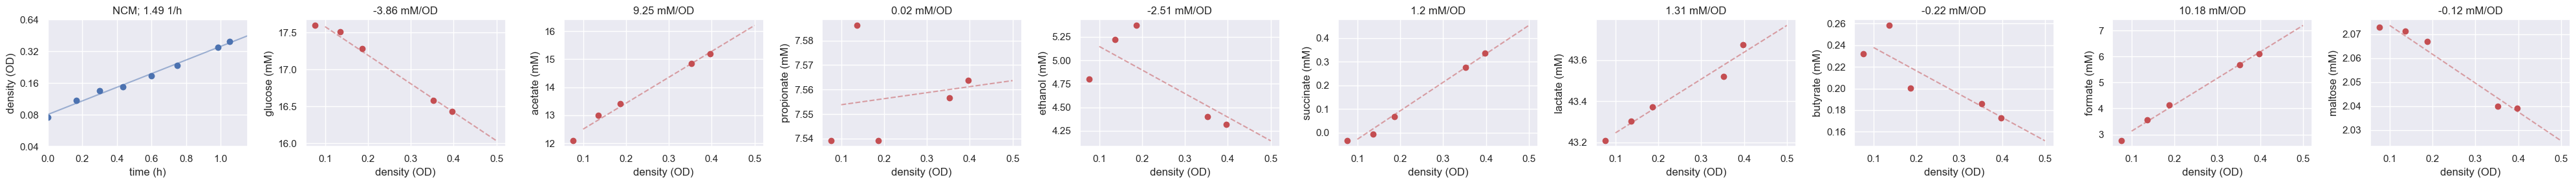

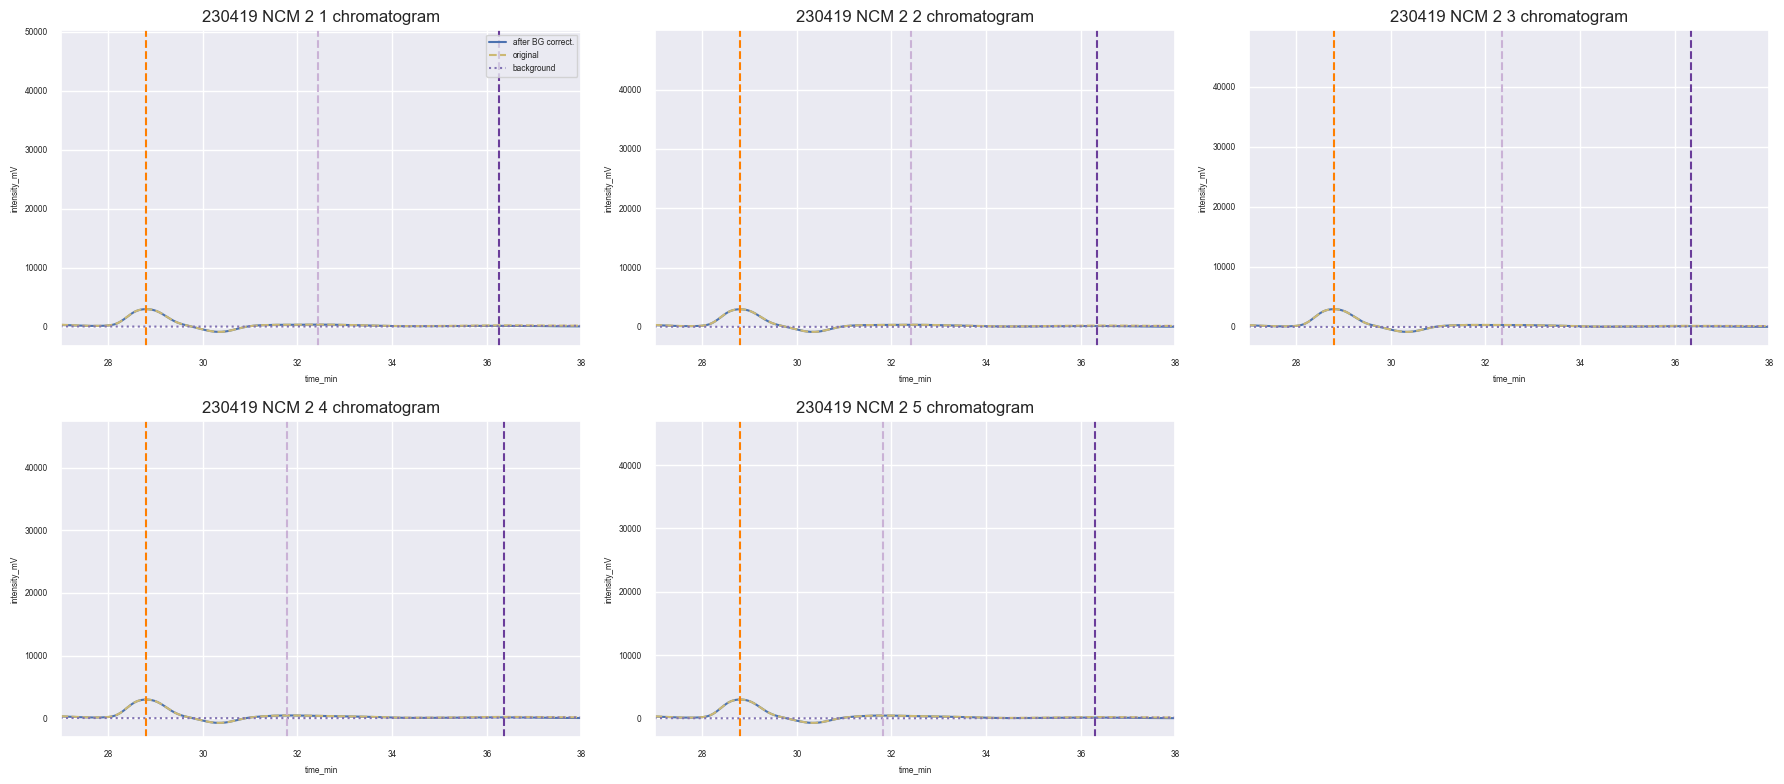

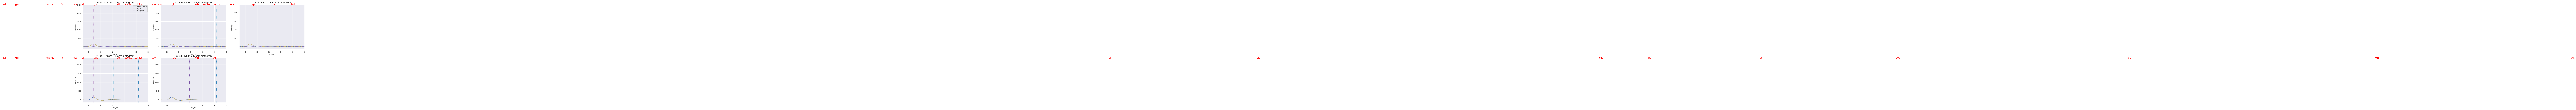

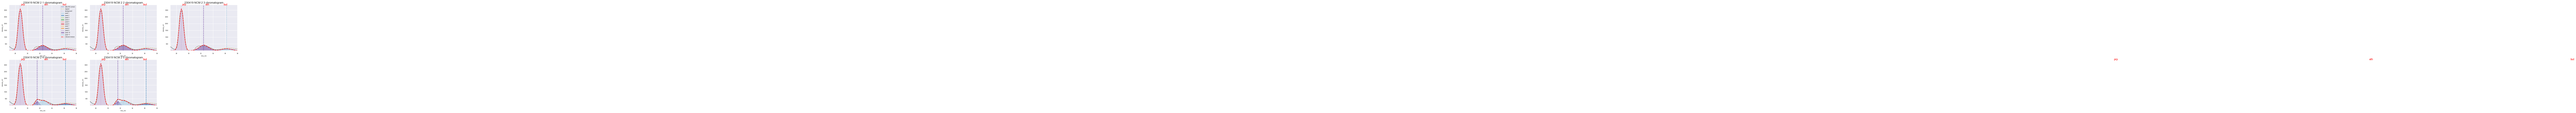

/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1421: DtypeWarning: Columns (0,1,2,3,4,5,6,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  analysis_settings=pd.read_csv(filename_settings,skiprows=1,index_col=0)
/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1421: DtypeWarning: Columns (0,1,2,3,4,5,6,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  analysis_settings=pd.read_csv(filename_settings,skiprows=1,index_col=0)
Processing files...: 100%|████████████████████████| 5/5 [00:00<00:00, 11.23it/s]
/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1113: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list

[2, 3, 6]


retention_time  retention_time_firstguess     scale      skew  \
0        13.346597                   13.33333  0.201144 -0.100000   
1        15.774593                   15.77500  0.214165  0.100000   
2        18.525000                   18.82500  0.800000 -0.100000   
3        20.138679                   20.10833  0.278235  0.009097   
4        20.847000                   20.90000  0.130410 -0.022437   
5        21.764155                   21.75833  0.270356  0.003335   
6        23.364616                   23.38333  0.440829 -0.007295   
7        24.976264                   24.97500  0.329982  0.000711   
8        28.790315                   28.80833  0.362774  0.099523   
9        32.510885                   32.49167  0.702382  0.006066   
10       36.309633                   36.45000  0.799999 -0.000033   

       amplitude          area  peak_idx                            sample  
0   15088.842508   7607.714537         1  230419_B.fragilis_1_chromatogram  
1   47203.490779  25340.343679         2  230419_B.fragilis_1_chromatogram  
2     263.185258    527.766135         3  230419_B.fragilis_1_chromatogram  
3     671.507310    468.330875         4  230419_B.fragilis_1_chromatogram  
4     463.301451    151.448557         5  230419_B.fragilis_1_chromatogram  
5   14634.480009   9917.516522         6  230419_B.fragilis_1_chromatogram  
6     240.302639    265.533159         7  230419_B.fragilis_1_chromatogram  
7    3176.670710   2627.561860         8  230419_B.fragilis_1_chromatogram  
8    3097.449768   2816.186400         9  230419_B.fragilis_1_chromatogram  
9     335.112607    589.809614        10  230419_B.fragilis_1_chromatogram  
10    124.568128    249.796075        11  230419_B.fragilis_1_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        13.346854                   13.33333  0.201440 -0.100000   
1        15.774486                   15.77500  0.214125  0.100000   
2        18.533330                   18.83333  0.800000 -0.100000   
3        20.141608                   20.10833  0.282638  0.004485   
4        20.857782                   20.90000  0.138763 -0.022424   
5        21.762980                   21.75833  0.271140  0.001672   
6        23.328006                   23.32500  0.428956  0.001915   
7        24.974685                   24.97500  0.328572 -0.000082   
8        28.818484                   28.80833  0.362271  0.004662   
9        31.900000                   32.20000  0.433638 -0.100000   
10       32.841670                   32.54167  0.597733  0.099994   
11       36.302030                   36.27500  0.800000  0.001074   

       amplitude          area  peak_idx                            sample  
0   15087.494323   7618.176249         1  230419_B.fragilis_2_chromatogram  
1   46516.096105  24966.695349         2  230419_B.fragilis_2_chromatogram  
2     250.207459    501.741512         3  230419_B.fragilis_2_chromatogram  
3     670.571372    475.078281         4  230419_B.fragilis_2_chromatogram  
4     611.378776    212.654442         5  230419_B.fragilis_2_chromatogram  
5   14710.485592   9997.947030         6  230419_B.fragilis_2_chromatogram  
6     259.078277    278.569304         7  230419_B.fragilis_2_chromatogram  
7    3256.549470   2682.116796         8  230419_B.fragilis_2_chromatogram  
8    3127.363759   2839.335128         9  230419_B.fragilis_2_chromatogram  
9     219.749941    238.855734        10  230419_B.fragilis_2_chromatogram  
10    260.148317    389.778204        11  230419_B.fragilis_2_chromatogram  
11    126.095353    252.858956        12  230419_B.fragilis_2_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        13.345735                   13.33333  0.201626 -0.100000   
1        15.773683                   15.77500  0.213847  0.099780   
2        18.541695                   18.84167  0.799948 -0.099981   
3        20.143110                   20.10833  0.286387  0.009961   
4        20.869549                   20.90000  0.152290 -0.012137   
5        21.761366                   21.75833  0.272455  0.001003   
6        23.290854                   23.25000  0.410448 -0.022621   
7        24.946564                   24.96667  0.327173  0.099516   
8        28.792926                   28.81667  0.363620  0.098771   
9        32.509623                   32.50000  0.713313  0.002917   
10       36.289346                   36.35833  0.800000 -0.000613   

       amplitude          area  peak_idx                            sample  
0   15046.905377   7604.713667         1  230419_B.fragilis_3_chromatogram  
1   45258.516664  24260.153014         2  230419_B.fragilis_3_chromatogram  
2     234.202869    469.616887         3  230419_B.fragilis_3_chromatogram  
3     664.112891    476.743250         4  230419_B.fragilis_3_chromatogram  
4     873.817429    333.566483         5  230419_B.fragilis_3_chromatogram  
5   14723.210775  10055.129574         6  230419_B.fragilis_3_chromatogram  
6     310.037968    318.979977         7  230419_B.fragilis_3_chromatogram  
7    3388.812172   2779.164823         8  230419_B.fragilis_3_chromatogram  
8    3147.403551   2868.100343         9  230419_B.fragilis_3_chromatogram  
9     331.139275    591.870586        10  230419_B.fragilis_3_chromatogram  
10    124.098321    248.854262        11  230419_B.fragilis_3_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        13.345384                   13.33333  0.201951 -0.100000   
1        15.773167                   15.77500  0.213961  0.100000   
2        18.566670                   18.86667  0.800000 -0.100000   
3        20.126030                   20.10833  0.291277  0.100000   
4        20.890256                   20.90000  0.160209 -0.100000   
5        21.740199                   21.75833  0.274348  0.100000   
6        23.228942                   23.22500  0.396601  0.099967   
7        24.947618                   24.96667  0.327768  0.100000   
8        28.797209                   28.81667  0.366390  0.100000   
9        31.900000                   32.20000  0.453757 -0.100000   
10       32.808330                   32.50833  0.641486  0.100000   
11       36.270228                   36.26667  0.800000 -0.001120   

       amplitude          area  peak_idx                            sample  
0   15030.226495   7608.519811         1  230419_B.fragilis_4_chromatogram  
1   44299.813870  23758.899029         2  230419_B.fragilis_4_chromatogram  
2     220.787897    442.746415         3  230419_B.fragilis_4_chromatogram  
3     663.836348    484.682708         4  230419_B.fragilis_4_chromatogram  
4    1093.904185    439.293642         5  230419_B.fragilis_4_chromatogram  
5   14739.618968  10136.264895         6  230419_B.fragilis_4_chromatogram  
6     353.358941    351.285243         7  230419_B.fragilis_4_chromatogram  
7    3492.369014   2869.305474         8  230419_B.fragilis_4_chromatogram  
8    3169.372253   2909.886300         9  230419_B.fragilis_4_chromatogram  
9     206.802861    235.208448        10  230419_B.fragilis_4_chromatogram  
10    262.126665    421.488122        11  230419_B.fragilis_4_chromatogram  
11    128.635366    257.952531        12  230419_B.fragilis_4_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        13.345529                   13.33333  0.202035 -0.100000   
1        15.772932                   15.77500  0.213883  0.100000   
2        18.541670                   18.84167  0.800000 -0.100000   
3        20.125726                   20.10833  0.295525  0.099991   
4        20.899957                   20.90000  0.171327 -0.099987   
5        21.759990                   21.75833  0.274817  0.002212   
6        23.197758                   23.20833  0.374862  0.099921   
7        24.971468                   24.97500  0.324260 -0.000084   
8        28.800023                   28.81667  0.363852  0.100000   
9        31.900000                   32.20000  0.429045 -0.100000   
10       32.816670                   32.51667  0.578468  0.099998   
11       36.303071                   36.44167  0.800000 -0.003068   

       amplitude          area  peak_idx                            sample  
0   14988.086653   7590.371665         1  230419_B.fragilis_5_chromatogram  
1   42871.238309  22984.360793         2  230419_B.fragilis_5_chromatogram  
2     212.346016    425.817799         3  230419_B.fragilis_5_chromatogram  
3     669.527779    495.966959         4  230419_B.fragilis_5_chromatogram  
4    1417.254555    608.644223         5  230419_B.fragilis_5_chromatogram  
5   14813.773235  10204.689574         6  230419_B.fragilis_5_chromatogram  
6     423.306151    397.755343         7  230419_B.fragilis_5_chromatogram  
7    3656.863916   2972.295070         8  230419_B.fragilis_5_chromatogram  
8    3197.412956   2915.585264         9  230419_B.fragilis_5_chromatogram  
9     204.533733    219.962598        10  230419_B.fragilis_5_chromatogram  
10    258.970981    375.508552        11  230419_B.fragilis_5_chromatogram  
11    121.133820    242.909438        12  230419_B.fragilis_5_chromatogram

/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:2051: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  growthrates = growthrates.append(dictc, ignore_index=True)


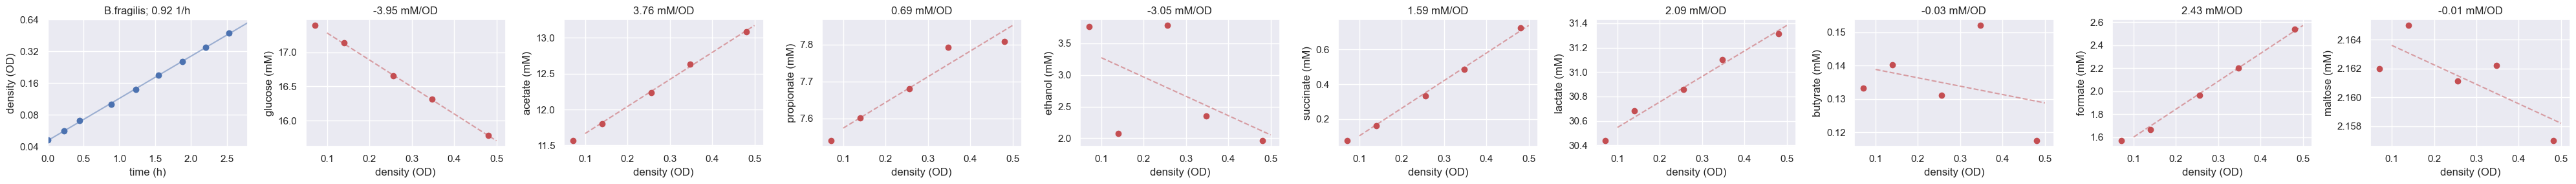

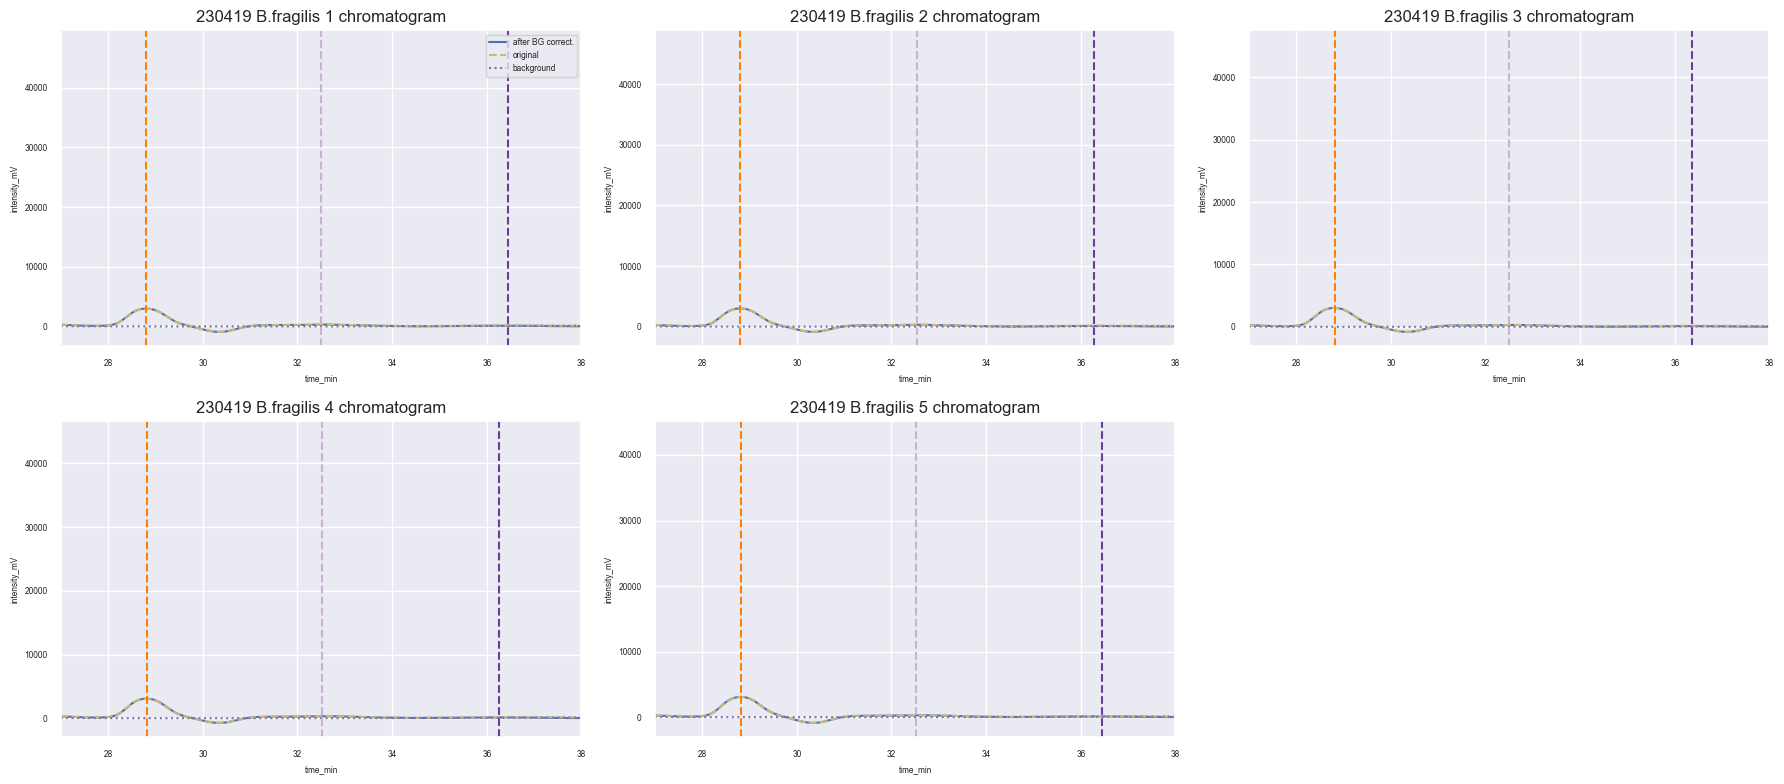

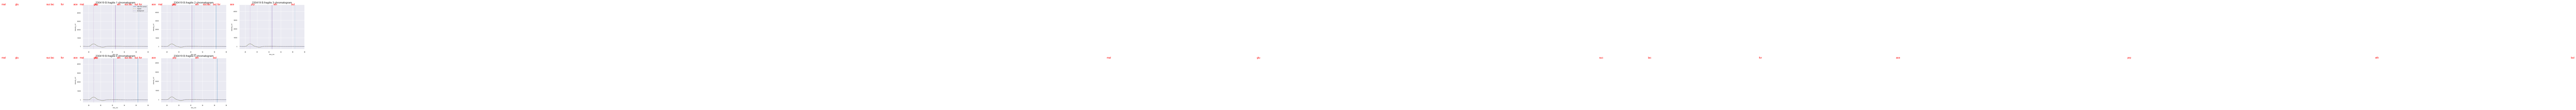

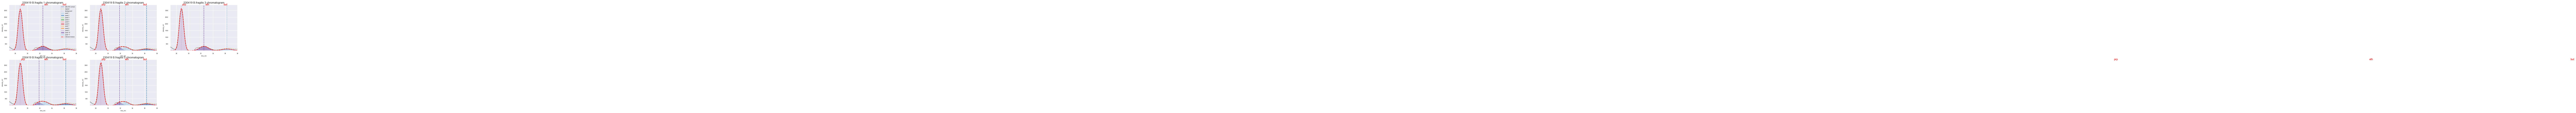

/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1421: DtypeWarning: Columns (0,1,2,3,4,5,6,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  analysis_settings=pd.read_csv(filename_settings,skiprows=1,index_col=0)
/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1421: DtypeWarning: Columns (0,1,2,3,4,5,6,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  analysis_settings=pd.read_csv(filename_settings,skiprows=1,index_col=0)
Processing files...: 100%|████████████████████████| 5/5 [00:00<00:00, 11.50it/s]
/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1113: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list

[2, 3, 6]


/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1394: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


retention_time  retention_time_firstguess     scale      skew  \
0        13.338789                   13.32500  0.204591 -0.100000   
1        15.757618                   15.75833  0.214757  0.099459   
2        18.541752                   18.84167  0.799996 -0.099954   
3        20.073081                   20.08333  0.257730 -0.003704   
4        20.957423                   20.90000  0.314965  0.029908   
5        21.670395                   21.58333  0.293524  0.001933   
6        23.386098                   23.30833  0.378449  0.013456   
7        24.926491                   24.94167  0.330334  0.099529   
8        28.828386                   28.81667  0.368909 -0.003284   
9        32.358330                   32.05833  0.684276  0.099999   
10       36.146073                   36.36667  0.800000  0.000424   

       amplitude          area  peak_idx                              sample  
0   14788.492379   7584.044810         1  230424_B.fragilis_2_1_chromatogram  
1   44948.239057  24196.410574         2  230424_B.fragilis_2_1_chromatogram  
2     261.645354    524.675351         3  230424_B.fragilis_2_1_chromatogram  
3     738.985633    477.409896         4  230424_B.fragilis_2_1_chromatogram  
4    1102.421837    870.362372         5  230424_B.fragilis_2_1_chromatogram  
5    1279.236609    941.205948         6  230424_B.fragilis_2_1_chromatogram  
6     275.840576    261.671144         7  230424_B.fragilis_2_1_chromatogram  
7    3403.595638   2818.257553         8  230424_B.fragilis_2_1_chromatogram  
8    3428.212016   3169.618900         9  230424_B.fragilis_2_1_chromatogram  
9     463.776982    795.113015        10  230424_B.fragilis_2_1_chromatogram  
10    161.013521    322.880717        11  230424_B.fragilis_2_1_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        13.337950                   13.32500  0.204129 -0.100000   
1        15.757969                   15.75833  0.214898  0.100000   
2        18.550000                   18.85000  0.800000 -0.100000   
3        20.090321                   20.08333  0.279934 -0.099694   
4        20.956279                   21.05000  0.297190 -0.001047   
5        21.665492                   21.57500  0.296817 -0.007553   
6        23.376961                   23.30833  0.376643 -0.000393   
7        24.928124                   24.94167  0.332439  0.100000   
8        28.859542                   28.82500  0.370229 -0.100000   
9        32.225000                   31.92500  0.645554  0.100000   
10       36.115212                   36.22500  0.800000  0.000573   

       amplitude          area  peak_idx                              sample  
0   14722.871107   7533.306310         1  230424_B.fragilis_2_2_chromatogram  
1   43514.279010  23439.803773         2  230424_B.fragilis_2_2_chromatogram  
2     276.743625    554.954669         3  230424_B.fragilis_2_2_chromatogram  
3     770.376163    540.564942         4  230424_B.fragilis_2_2_chromatogram  
4    1330.273816    990.979111         5  230424_B.fragilis_2_2_chromatogram  
5    1296.640543    964.711764         6  230424_B.fragilis_2_2_chromatogram  
6     280.341503    264.671291         7  230424_B.fragilis_2_2_chromatogram  
7    3454.372293   2878.528035         8  230424_B.fragilis_2_2_chromatogram  
8    3409.098513   3163.162700         9  230424_B.fragilis_2_2_chromatogram  
9     484.110454    783.006256        10  230424_B.fragilis_2_2_chromatogram  
10    148.114917    297.015057        11  230424_B.fragilis_2_2_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        13.339739                   13.32500  0.204061 -0.100000   
1        15.759632                   15.75833  0.214899  0.100000   
2        18.566670                   18.86667  0.800000 -0.100000   
3        20.087685                   20.10000  0.271370 -0.099766   
4        20.958510                   21.02500  0.297810 -0.003425   
5        21.693244                   21.56667  0.295883 -0.100000   
6        23.359898                   23.26667  0.379717  0.000864   
7        24.929897                   24.94167  0.332004  0.100000   
8        28.862391                   28.82500  0.370647 -0.100000   
9        32.412608                   32.22500  0.707014  0.099829   
10       36.126503                   36.27500  0.800000  0.002224   

       amplitude          area  peak_idx                              sample  
0   14716.521636   7527.562177         1  230424_B.fragilis_2_3_chromatogram  
1   42617.140540  22956.681777         2  230424_B.fragilis_2_3_chromatogram  
2     276.940487    555.349554         3  230424_B.fragilis_2_3_chromatogram  
3     761.929386    518.283482         4  230424_B.fragilis_2_3_chromatogram  
4    1498.760165   1118.823182         5  230424_B.fragilis_2_3_chromatogram  
5    1282.342011    951.074341         6  230424_B.fragilis_2_3_chromatogram  
6     291.507344    277.459283         7  230424_B.fragilis_2_3_chromatogram  
7    3504.066942   2916.121756         8  230424_B.fragilis_2_3_chromatogram  
8    3415.443144   3172.651350         9  230424_B.fragilis_2_3_chromatogram  
9     456.569227    808.727992        10  230424_B.fragilis_2_3_chromatogram  
10    150.374695    301.546681        11  230424_B.fragilis_2_3_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        13.337316                   13.32500  0.204074 -0.100000   
1        15.755989                   15.75000  0.214850  0.100000   
2        18.533330                   18.83333  0.800000 -0.100000   
3        20.076069                   20.09167  0.263809 -0.099956   
4        20.926896                   20.99167  0.295188  0.100000   
5        21.689291                   21.70000  0.294721 -0.100000   
6        23.337871                   23.23333  0.381183 -0.084330   
7        24.923372                   24.94167  0.329864  0.100000   
8        28.858740                   28.81667  0.369551 -0.100000   
9        32.403998                   32.24167  0.706364  0.099574   
10       36.164736                   36.20833  0.800000  0.000081   

       amplitude          area  peak_idx                              sample  
0   14750.108956   7545.243907         1  230424_B.fragilis_2_4_chromatogram  
1   41301.571225  22242.936035         2  230424_B.fragilis_2_4_chromatogram  
2     283.878947    569.263386         3  230424_B.fragilis_2_4_chromatogram  
3     758.844035    501.801788         4  230424_B.fragilis_2_4_chromatogram  
4    1789.492200   1324.094482         5  230424_B.fragilis_2_4_chromatogram  
5    1284.906691    949.234523         6  230424_B.fragilis_2_4_chromatogram  
6     322.634034    308.271782         7  230424_B.fragilis_2_4_chromatogram  
7    3611.411089   2986.087717         8  230424_B.fragilis_2_4_chromatogram  
8    3434.661761   3181.059196         9  230424_B.fragilis_2_4_chromatogram  
9     445.066943    787.632735        10  230424_B.fragilis_2_4_chromatogram  
10    140.673642    282.092998        11  230424_B.fragilis_2_4_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        13.337284                   13.32500  0.204054 -0.100000   
1        15.756682                   15.75833  0.214796  0.099807   
2        18.516710                   18.81667  0.799999 -0.099981   
3        20.055280                   20.09167  0.257328 -0.013721   
4        20.953042                   20.98333  0.292065 -0.009260   
5        21.686128                   21.70000  0.293737 -0.075903   
6        23.265663                   23.19167  0.377088  0.061406   
7        24.925468                   24.94167  0.328357  0.099432   
8        28.856061                   28.81667  0.369083 -0.071332   
9        32.421368                   32.29167  0.713859  0.097609   
10       36.181419                   36.26667  0.800000  0.000009   

       amplitude          area  peak_idx                              sample  
0   14721.780961   7530.020768         1  230424_B.fragilis_2_5_chromatogram  
1   40198.827759  21643.599458         2  230424_B.fragilis_2_5_chromatogram  
2     287.265266    576.053095         3  230424_B.fragilis_2_5_chromatogram  
3     755.338963    487.213492         4  230424_B.fragilis_2_5_chromatogram  
4    2016.387331   1476.192290         5  230424_B.fragilis_2_5_chromatogram  
5    1285.562623    946.547182         6  230424_B.fragilis_2_5_chromatogram  
6     353.285845    333.932733         7  230424_B.fragilis_2_5_chromatogram  
7    3694.503819   3040.828168         8  230424_B.fragilis_2_5_chromatogram  
8    3445.155655   3186.643958         9  230424_B.fragilis_2_5_chromatogram  
9     431.811092    772.282216        10  230424_B.fragilis_2_5_chromatogram  
10    135.529958    271.778249        11  230424_B.fragilis_2_5_chromatogram

/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:2051: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  growthrates = growthrates.append(dictc, ignore_index=True)


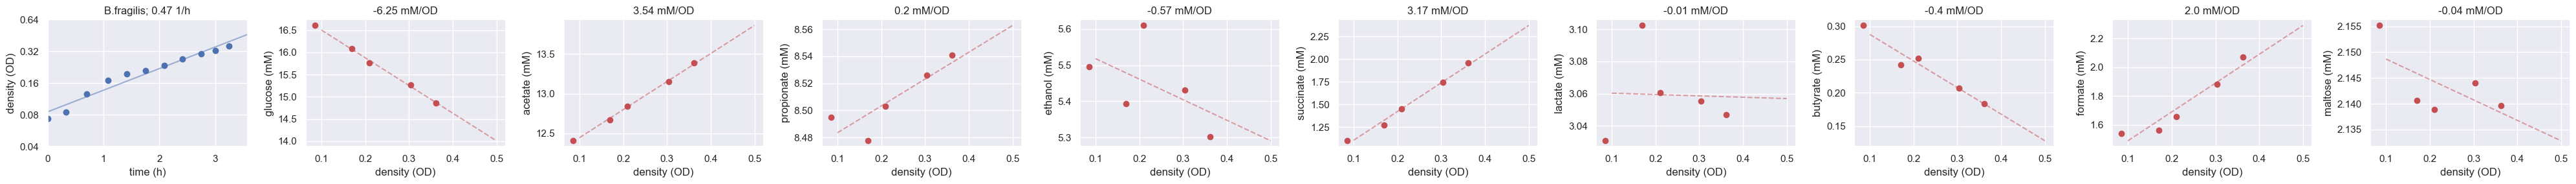

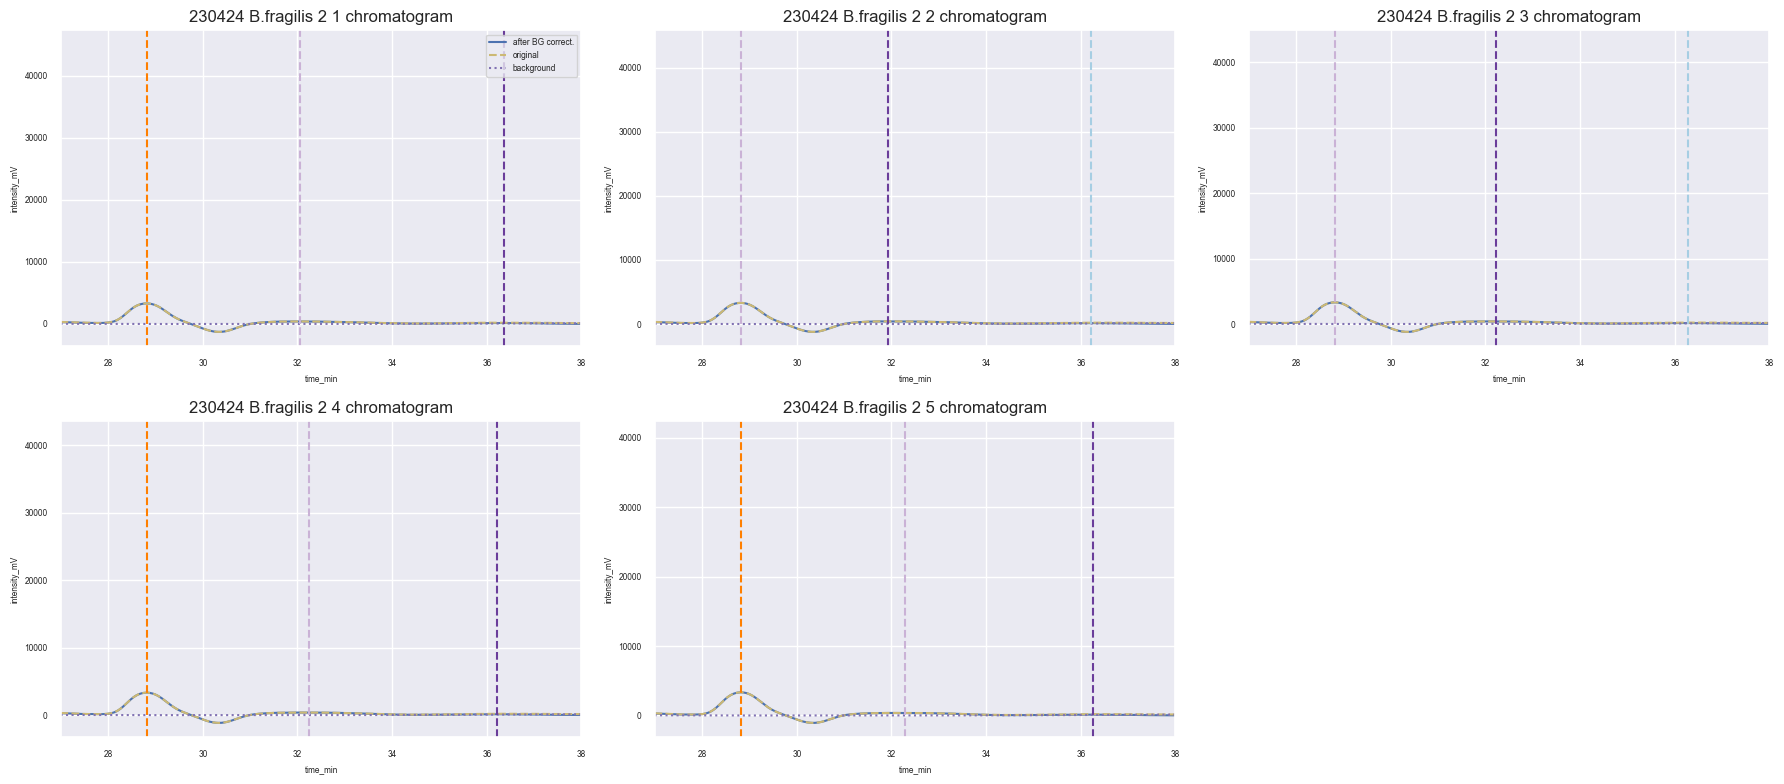

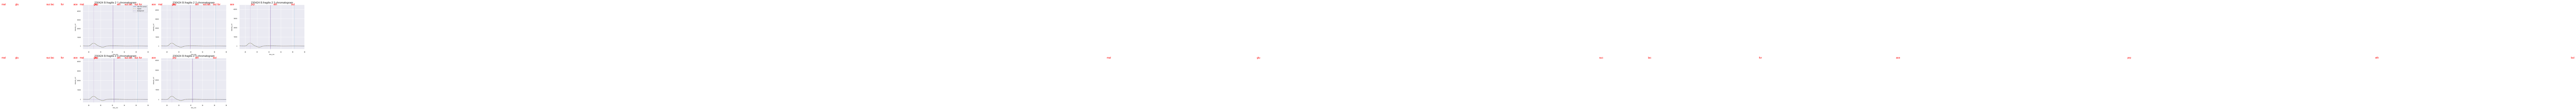

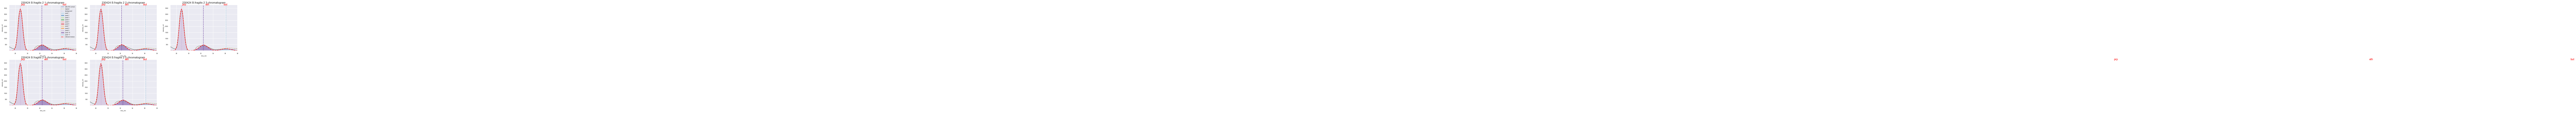

/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1421: DtypeWarning: Columns (0,1,2,3,4,5,6,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  analysis_settings=pd.read_csv(filename_settings,skiprows=1,index_col=0)
/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1421: DtypeWarning: Columns (0,1,2,3,4,5,6,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  analysis_settings=pd.read_csv(filename_settings,skiprows=1,index_col=0)
Processing files...: 100%|████████████████████████| 5/5 [00:00<00:00, 11.50it/s]
/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1113: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list

[2, 3, 6]


retention_time  retention_time_firstguess     scale      skew  \
0        13.340264                   13.32500  0.201470 -0.100000   
1        15.773272                   15.77500  0.213829  0.100000   
2        18.566670                   18.86667  0.800000 -0.100000   
3        20.120746                   20.10833  0.297219  0.058641   
4        20.898498                   20.90000  0.186578 -0.001050   
5        21.744293                   21.74167  0.281125  0.000683   
6        23.459925                   23.42500  0.361959  0.010437   
7        24.976204                   24.97500  0.329532  0.000705   
8        28.790194                   28.80000  0.360742  0.099972   
9        31.900000                   32.20000  0.420968 -0.100000   
10       32.808330                   32.50833  0.597916  0.100000   
11       36.313599                   36.45833  0.800000 -0.010449   

       amplitude          area  peak_idx                              sample  
0   14664.573660   7405.777436         1  230419_B.finegoldii_1_chromatogram  
1   47482.192713  25449.925173         2  230419_B.finegoldii_1_chromatogram  
2     254.130730    509.609085         3  230419_B.finegoldii_1_chromatogram  
3     757.913650    564.659594         4  230419_B.finegoldii_1_chromatogram  
4     484.931884    226.793411         5  230419_B.finegoldii_1_chromatogram  
5    5192.649992   3659.136143         6  230419_B.finegoldii_1_chromatogram  
6     227.001840    205.957955         7  230419_B.finegoldii_1_chromatogram  
7    3138.744106   2592.645179         8  230419_B.finegoldii_1_chromatogram  
8    3083.686064   2788.034024         9  230419_B.finegoldii_1_chromatogram  
9     196.496354    207.341365        10  230419_B.finegoldii_1_chromatogram  
10    261.743181    392.287390        11  230419_B.finegoldii_1_chromatogram  
11    119.613301    239.860490        12  230419_B.finegoldii_1_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        13.339727                   13.32500  0.201600 -0.100000   
1        15.771910                   15.77500  0.213916  0.100000   
2        18.550000                   18.85000  0.800000 -0.100000   
3        20.105533                   20.09167  0.300179  0.100000   
4        20.901354                   20.90000  0.193888  0.000095   
5        21.763518                   21.73333  0.282391 -0.099998   
6        23.452697                   23.37500  0.368498 -0.051800   
7        24.946468                   24.96667  0.330187  0.100000   
8        28.787994                   28.80000  0.361081  0.100000   
9        31.900000                   32.20000  0.424277 -0.100000   
10       32.808330                   32.50833  0.602765  0.100000   
11       36.311522                   36.38333  0.800000 -0.002531   

       amplitude          area  peak_idx                              sample  
0   14675.868542   7416.248356         1  230419_B.finegoldii_2_chromatogram  
1   46958.688255  25179.567142         2  230419_B.finegoldii_2_chromatogram  
2     246.322365    493.950834         3  230419_B.finegoldii_2_chromatogram  
3     759.708394    571.632722         4  230419_B.finegoldii_2_chromatogram  
4     573.576273    278.761622         5  230419_B.finegoldii_2_chromatogram  
5    5187.658616   3672.074210         6  230419_B.finegoldii_2_chromatogram  
6     236.894138    218.815975         7  230419_B.finegoldii_2_chromatogram  
7    3183.513738   2634.857523         8  230419_B.finegoldii_2_chromatogram  
8    3101.830748   2807.043579         9  230419_B.finegoldii_2_chromatogram  
9     195.424427    207.830976        10  230419_B.finegoldii_2_chromatogram  
10    260.892317    394.183234        11  230419_B.finegoldii_2_chromatogram  
11    121.186868    243.015872        12  230419_B.finegoldii_2_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        13.325003                   13.32500  0.201061 -0.001505   
1        14.512041                   14.47500  0.178076 -0.001863   
2        15.772955                   15.77500  0.213972  0.100000   
3        18.558330                   18.85833  0.800000 -0.100000   
4        20.121746                   20.10000  0.294799  0.008021   
5        20.911377                   20.90000  0.212172  0.002691   
6        21.741611                   21.74167  0.282109 -0.000082   
7        23.378717                   23.29167  0.374090  0.020012   
8        24.968394                   24.96667  0.327343  0.019411   
9        28.792666                   28.81667  0.361949  0.098360   
10       31.900000                   32.20000  0.433607 -0.100000   
11       32.825000                   32.52500  0.596144  0.099989   
12       36.296183                   36.25833  0.800000  0.001960   

       amplitude          area  peak_idx                              sample  
0   14700.870667   7408.990829         1  230419_B.finegoldii_3_chromatogram  
1     278.637996    103.996644         2  230419_B.finegoldii_3_chromatogram  
2   45575.412444  24444.305392         3  230419_B.finegoldii_3_chromatogram  
3     233.533320    468.304736         4  230419_B.finegoldii_3_chromatogram  
4     762.002330    563.082553         5  230419_B.finegoldii_3_chromatogram  
5     812.111982    431.910272         6  230419_B.finegoldii_3_chromatogram  
6    5208.175946   3682.914672         7  230419_B.finegoldii_3_chromatogram  
7     260.299835    244.084316         8  230419_B.finegoldii_3_chromatogram  
8    3315.696470   2720.620908         9  230419_B.finegoldii_3_chromatogram  
9    3126.718844   2836.290008        10  230419_B.finegoldii_3_chromatogram  
10    196.972679    214.082347        11  230419_B.finegoldii_3_chromatogram  
11    263.168268    393.254839        12  230419_B.finegoldii_3_chromatogram  
12    121.592105    243.828442        13  230419_B.finegoldii_3_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        13.337989                   13.32500  0.201696 -0.100000   
1        14.507745                   14.47500  0.179106  0.000378   
2        15.770213                   15.76667  0.213996  0.100000   
3        18.558330                   18.85833  0.800000 -0.100000   
4        20.111891                   20.10000  0.289806  0.005995   
5        20.920661                   20.90000  0.224718 -0.015064   
6        21.741559                   21.74167  0.282195 -0.007533   
7        23.328665                   23.25833  0.374557  0.035876   
8        24.945188                   24.96667  0.327712  0.099828   
9        28.793059                   28.81667  0.363458  0.100000   
10       31.900000                   32.20000  0.444021 -0.100000   
11       32.841670                   32.54167  0.589598  0.099998   
12       36.287466                   36.30833  0.800000  0.005446   

       amplitude          area  peak_idx                              sample  
0   14599.151041   7380.985185         1  230419_B.finegoldii_4_chromatogram  
1     286.997880    106.837922         2  230419_B.finegoldii_4_chromatogram  
2   44129.399769  23671.364398         3  230419_B.finegoldii_4_chromatogram  
3     223.301285    447.786420         4  230419_B.finegoldii_4_chromatogram  
4     758.107679    550.716963         5  230419_B.finegoldii_4_chromatogram  
5    1055.288621    594.427086         6  230419_B.finegoldii_4_chromatogram  
6    5203.099750   3680.451051         7  230419_B.finegoldii_4_chromatogram  
7     295.980370    277.888340         8  230419_B.finegoldii_4_chromatogram  
8    3424.793285   2813.305835         9  230419_B.finegoldii_4_chromatogram  
9    3145.299288   2864.853280        10  230419_B.finegoldii_4_chromatogram  
10    205.506385    228.721001        11  230419_B.finegoldii_4_chromatogram  
11    265.254591    392.020303        12  230419_B.finegoldii_4_chromatogram  
12    122.902080    246.455278        13  230419_B.finegoldii_4_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        13.325709                   13.32500  0.201437  0.000370   
1        14.516935                   14.46667  0.183275 -0.083314   
2        15.774609                   15.77500  0.214054  0.100000   
3        18.566670                   18.86667  0.800000 -0.100000   
4        20.111085                   20.10833  0.287365 -0.000376   
5        20.924302                   20.90000  0.230764  0.006644   
6        21.743200                   21.74167  0.282209  0.000417   
7        23.300274                   23.21667  0.370576  0.053778   
8        24.973838                   24.97500  0.325716  0.000730   
9        28.798428                   28.81667  0.363766  0.098521   
10       31.900000                   32.20000  0.448289 -0.100000   
11       32.808330                   32.50833  0.615462  0.100000   
12       36.316448                   36.44167  0.800000 -0.000330   

       amplitude          area  peak_idx                              sample  
0   14629.652525   7386.909034         1  230419_B.finegoldii_5_chromatogram  
1     295.462062    112.876590         2  230419_B.finegoldii_5_chromatogram  
2   43227.458517  23193.865115         3  230419_B.finegoldii_5_chromatogram  
3     216.444998    434.037685         4  230419_B.finegoldii_5_chromatogram  
4     757.442179    545.599582         5  230419_B.finegoldii_5_chromatogram  
5    1221.517398    706.573165         6  230419_B.finegoldii_5_chromatogram  
6    5204.220288   3681.435277         7  230419_B.finegoldii_5_chromatogram  
7     323.941460    300.908150         8  230419_B.finegoldii_5_chromatogram  
8    3526.396554   2879.119533         9  230419_B.finegoldii_5_chromatogram  
9    3164.327407   2884.582123        10  230419_B.finegoldii_5_chromatogram  
10    186.816816    209.917412        11  230419_B.finegoldii_5_chromatogram  
11    262.322916    404.693099        12  230419_B.finegoldii_5_chromatogram  
12    122.964856    246.581129        13  230419_B.finegoldii_5_chromatogram

/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:2051: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  growthrates = growthrates.append(dictc, ignore_index=True)


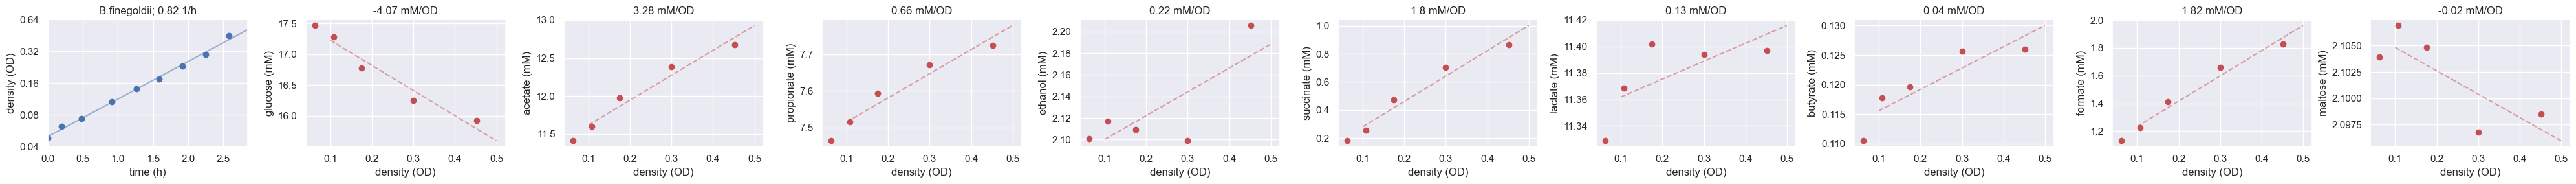

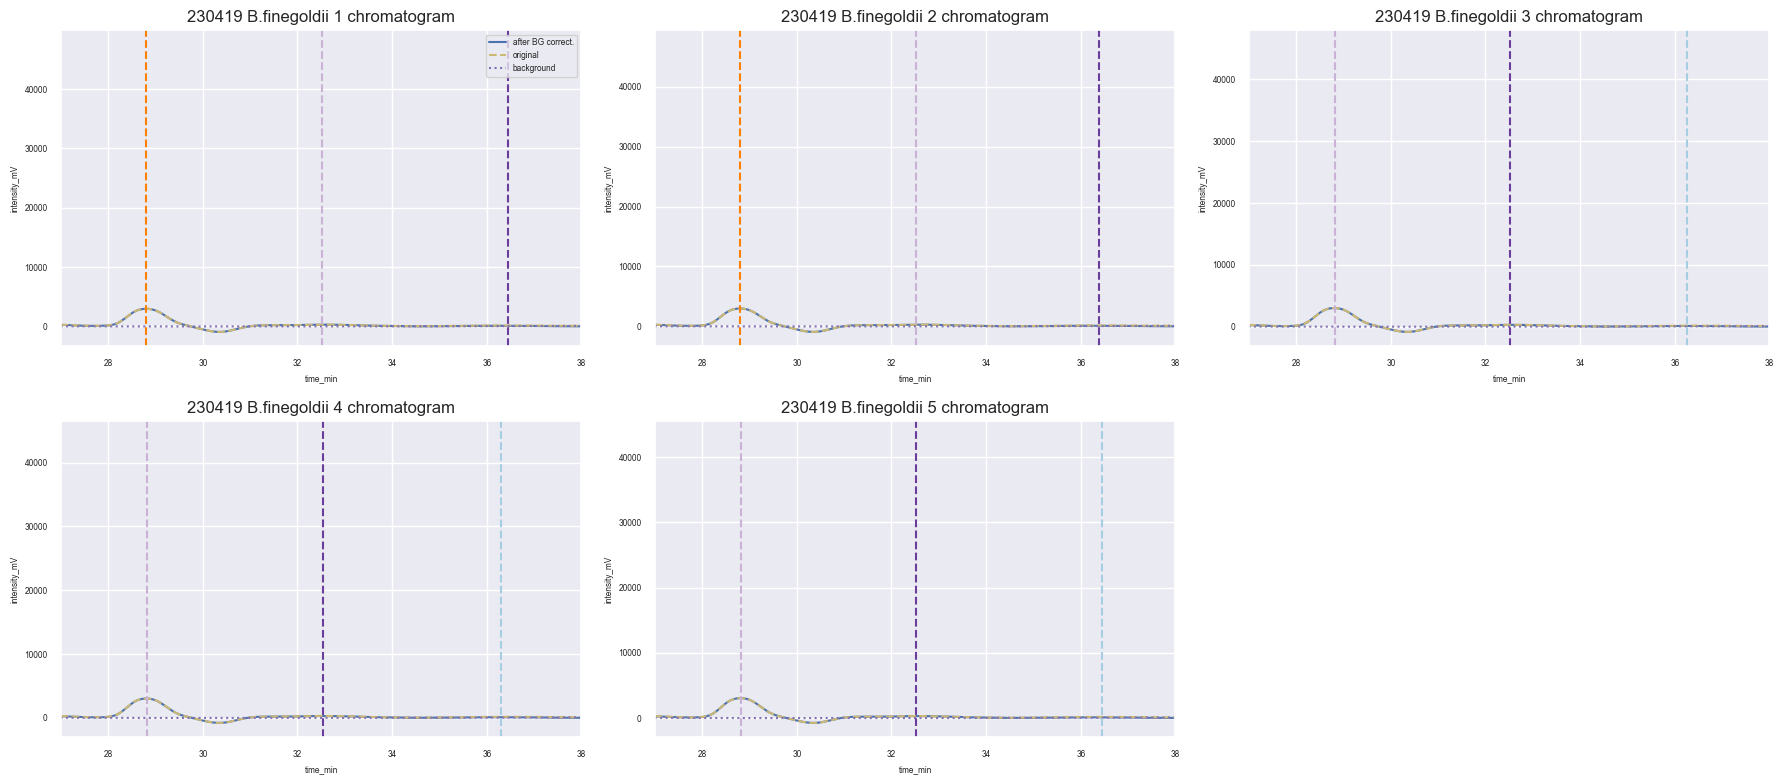

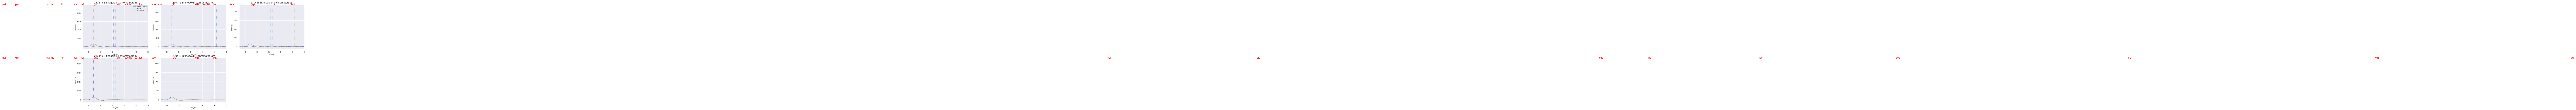

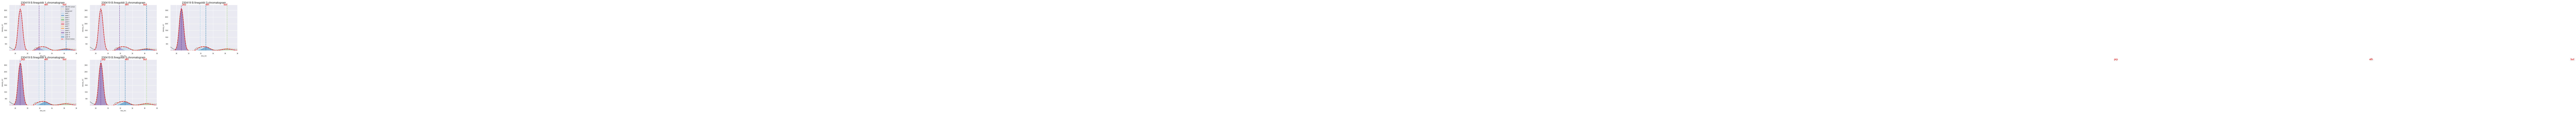

/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1421: DtypeWarning: Columns (0,1,2,3,4,5,6,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  analysis_settings=pd.read_csv(filename_settings,skiprows=1,index_col=0)
/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1421: DtypeWarning: Columns (0,1,2,3,4,5,6,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  analysis_settings=pd.read_csv(filename_settings,skiprows=1,index_col=0)
Processing files...: 100%|████████████████████████| 4/4 [00:00<00:00, 11.55it/s]
/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1113: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list

[2, 3, 6]


/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1394: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


retention_time  retention_time_firstguess     scale      skew  \
0        13.340616                   13.32500  0.204175 -0.100000   
1        15.758758                   15.75833  0.214688  0.099691   
2        18.533340                   18.83333  0.799999 -0.099993   
3        20.080686                   20.09167  0.272852 -0.003706   
4        20.976865                   20.90000  0.342270  0.026657   
5        21.673097                   21.58333  0.294231  0.002904   
6        23.434965                   23.40833  0.360579  0.008866   
7        24.957578                   24.95000  0.333253  0.003152   
8        28.822677                   28.80000  0.363773 -0.007051   
9        32.422679                   32.17500  0.666060  0.034461   
10       36.244715                   36.40000  0.800000 -0.000189   

       amplitude          area  peak_idx                                sample  
0   14914.575658   7633.150093         1  230424_B.finegoldii_2_1_chromatogram  
1   46762.023085  25164.633305         2  230424_B.finegoldii_2_1_chromatogram  
2     295.544848    592.656101         3  230424_B.finegoldii_2_1_chromatogram  
3     771.075223    527.368703         4  230424_B.finegoldii_2_1_chromatogram  
4     825.298847    708.059290         5  230424_B.finegoldii_2_1_chromatogram  
5    1120.038942    826.060348         6  230424_B.finegoldii_2_1_chromatogram  
6     247.297667    223.516569         7  230424_B.finegoldii_2_1_chromatogram  
7    3189.238697   2664.101815         8  230424_B.finegoldii_2_1_chromatogram  
8    3219.485414   2935.411486         9  230424_B.finegoldii_2_1_chromatogram  
9     430.255660    718.083817        10  230424_B.finegoldii_2_1_chromatogram  
10    132.540933    265.784223        11  230424_B.finegoldii_2_1_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        13.337306                   13.32500  0.204456 -0.100000   
1        15.753219                   15.75000  0.214663  0.099824   
2        18.525011                   18.82500  0.799999 -0.099993   
3        20.073700                   20.09167  0.275558 -0.006261   
4        20.960716                   20.90000  0.328912  0.022740   
5        21.683450                   21.57500  0.296117 -0.084846   
6        23.407104                   23.35833  0.365010  0.016197   
7        24.948838                   24.94167  0.331601  0.003128   
8        28.814685                   28.79167  0.362644 -0.003745   
9        32.429082                   32.17500  0.676839  0.099999   
10       36.287785                   36.41667  0.800000 -0.004574   

       amplitude          area  peak_idx                                sample  
0   14980.656560   7677.497632         1  230424_B.finegoldii_2_2_chromatogram  
1   46118.154670  24815.294588         2  230424_B.finegoldii_2_2_chromatogram  
2     305.122600    611.862598         3  230424_B.finegoldii_2_2_chromatogram  
3     770.990521    532.539775         4  230424_B.finegoldii_2_2_chromatogram  
4     879.188449    724.854715         5  230424_B.finegoldii_2_2_chromatogram  
5    1136.124637    843.295432         6  230424_B.finegoldii_2_2_chromatogram  
6     250.811739    229.478908         7  230424_B.finegoldii_2_2_chromatogram  
7    3218.707252   2675.391743         8  230424_B.finegoldii_2_2_chromatogram  
8    3228.692598   2934.704795         9  230424_B.finegoldii_2_2_chromatogram  
9     400.449323    679.168665        10  230424_B.finegoldii_2_2_chromatogram  
10    123.133182    246.918796        11  230424_B.finegoldii_2_2_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        13.335990                   13.32500  0.204893 -0.100000   
1        15.750319                   15.75000  0.214811  0.100000   
2        18.525000                   18.82500  0.800000 -0.100000   
3        20.075828                   20.08333  0.275809 -0.042858   
4        20.930365                   20.90000  0.320103  0.099925   
5        21.660102                   21.56667  0.296268 -0.005069   
6        23.381688                   23.35000  0.377797  0.004054   
7        24.919150                   24.93333  0.332501  0.099775   
8        28.811768                   28.80000  0.363843  0.009333   
9        32.476289                   32.40000  0.707994  0.099989   
10       36.292520                   36.32500  0.800000  0.000277   

       amplitude          area  peak_idx                                sample  
0   15068.236604   7738.899691         1  230424_B.finegoldii_2_3_chromatogram  
1   45133.363595  24302.132227         2  230424_B.finegoldii_2_3_chromatogram  
2     313.992830    629.650316         3  230424_B.finegoldii_2_3_chromatogram  
3     770.848057    532.926109         4  230424_B.finegoldii_2_3_chromatogram  
4     969.955891    778.271911         5  230424_B.finegoldii_2_3_chromatogram  
5    1154.628018    857.464359         6  230424_B.finegoldii_2_3_chromatogram  
6     269.666563    255.373097         7  230424_B.finegoldii_2_3_chromatogram  
7    3313.070012   2761.301562         8  230424_B.finegoldii_2_3_chromatogram  
8    3286.914243   2997.408233         9  230424_B.finegoldii_2_3_chromatogram  
9     395.883358    702.289591        10  230424_B.finegoldii_2_3_chromatogram  
10    129.097393    258.878801        11  230424_B.finegoldii_2_3_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        13.331815                   13.31667  0.204944 -0.100000   
1        15.747973                   15.74167  0.214815  0.100000   
2        18.508330                   18.80833  0.800000 -0.100000   
3        20.061560                   20.07500  0.253443 -0.099979   
4        20.938618                   20.98333  0.297061  0.014514   
5        21.678031                   21.70000  0.290667 -0.099984   
6        23.201974                   23.15833  0.370195  0.099972   
7        24.911385                   24.92500  0.325738  0.100000   
8        28.805285                   28.82500  0.371422  0.099996   
9        32.526944                   32.44167  0.740461  0.099968   
10       36.426458                   36.43333  0.800000 -0.001693   

       amplitude          area  peak_idx                                sample  
0   14757.759815   7581.326964         1  230424_B.finegoldii_2_4_chromatogram  
1   38155.112784  20545.039049         2  230424_B.finegoldii_2_4_chromatogram  
2     312.551005    626.759280         3  230424_B.finegoldii_2_4_chromatogram  
3     748.445479    475.478162         4  230424_B.finegoldii_2_4_chromatogram  
4    1979.769626   1474.180882         5  230424_B.finegoldii_2_4_chromatogram  
5    1160.172206    845.294008         6  230424_B.finegoldii_2_4_chromatogram  
6     413.399702    383.610736         7  230424_B.finegoldii_2_4_chromatogram  
7    3939.996133   3217.026116         8  230424_B.finegoldii_2_4_chromatogram  
8    3589.516469   3341.043556         9  230424_B.finegoldii_2_4_chromatogram  
9     378.047905    701.385157        10  230424_B.finegoldii_2_4_chromatogram  
10    129.248160    259.180676        11  230424_B.finegoldii_2_4_chromatogram

/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:2051: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  growthrates = growthrates.append(dictc, ignore_index=True)


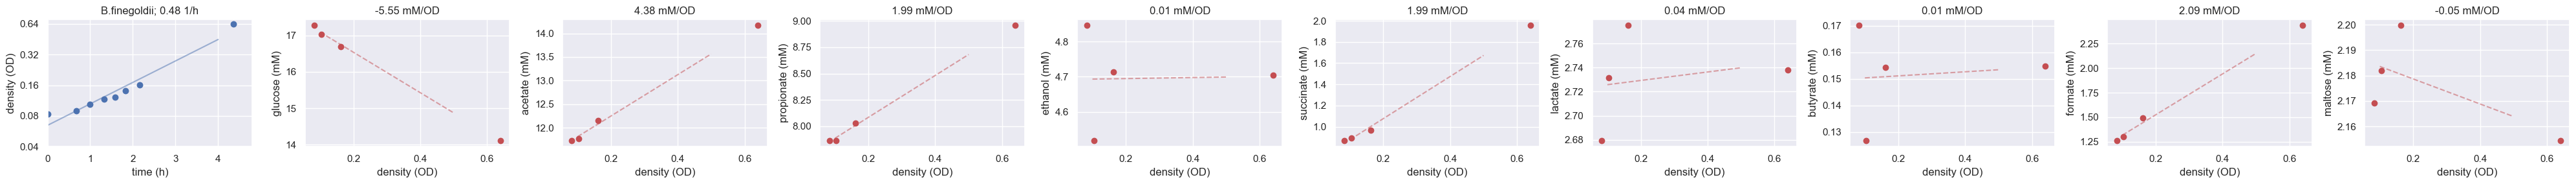

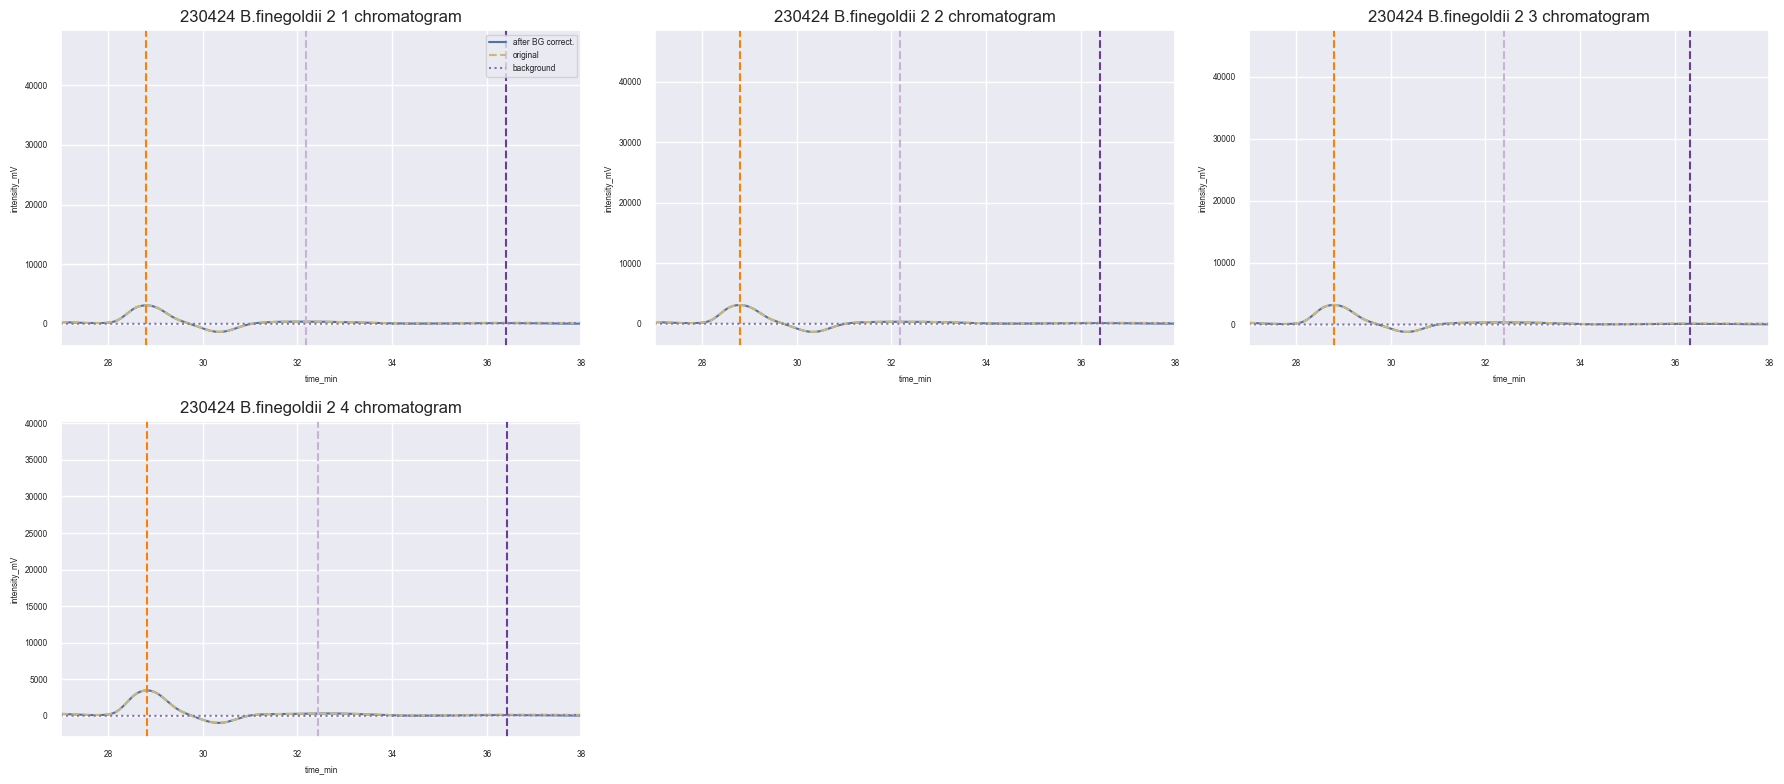

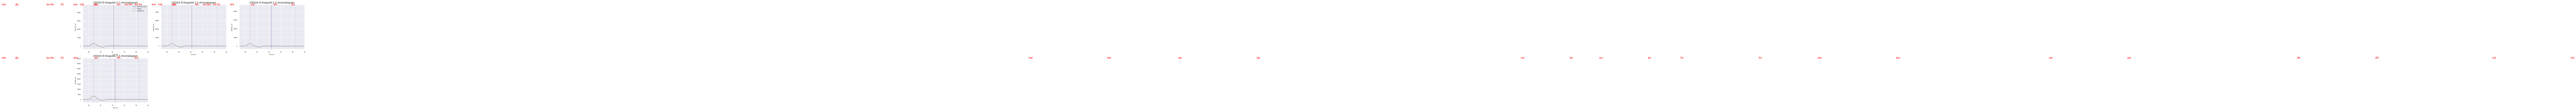

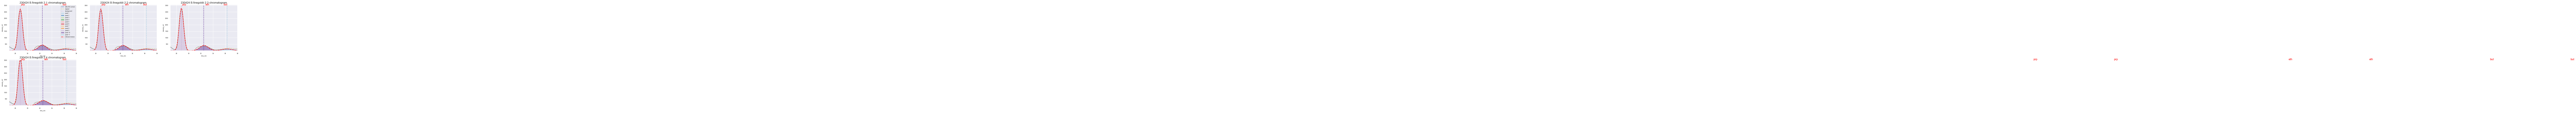

/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1421: DtypeWarning: Columns (0,1,2,3,4,5,6,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  analysis_settings=pd.read_csv(filename_settings,skiprows=1,index_col=0)
/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1421: DtypeWarning: Columns (0,1,2,3,4,5,6,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  analysis_settings=pd.read_csv(filename_settings,skiprows=1,index_col=0)
Processing files...: 100%|████████████████████████| 4/4 [00:00<00:00, 11.59it/s]
/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1113: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list

[2, 3, 6]


retention_time  retention_time_firstguess     scale      skew  \
0        13.317797                   13.31667  0.204011  0.000432   
1        15.749930                   15.75000  0.214651  0.099995   
2        18.516670                   18.81667  0.800000 -0.100000   
3        20.059376                   20.08333  0.250656 -0.030942   
4        20.958372                   21.09167  0.328205  0.001173   
5        21.674963                   21.52500  0.290274 -0.099976   
6        23.322763                   23.22500  0.380967 -0.030159   
7        24.916279                   24.93333  0.327977  0.099999   
8        28.841276                   28.80000  0.364517 -0.099924   
9        31.702140                   31.87500  0.317006 -0.020260   
10       32.500000                   32.20000  0.594196  0.100000   
11       36.047138                   35.83333  0.800000  0.001398   

       amplitude          area  peak_idx                          sample  
0   14773.371273   7554.785304         1  230424_B.ovatus_1_chromatogram  
1   44019.937142  23684.885245         2  230424_B.ovatus_1_chromatogram  
2     295.974642    593.518414         3  230424_B.ovatus_1_chromatogram  
3     745.181853    468.199329         4  230424_B.ovatus_1_chromatogram  
4    1350.037255   1110.657977         5  230424_B.ovatus_1_chromatogram  
5    1172.300939    852.977168         6  230424_B.ovatus_1_chromatogram  
6     309.730464    295.774869         7  230424_B.ovatus_1_chromatogram  
7    3655.488010   3005.232571         8  230424_B.ovatus_1_chromatogram  
8    3251.119493   2970.275143         9  230424_B.ovatus_1_chromatogram  
9     527.285972    418.990199        10  230424_B.ovatus_1_chromatogram  
10    492.617450    733.697127        11  230424_B.ovatus_1_chromatogram  
11    136.673976    274.072485        12  230424_B.ovatus_1_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        13.335318                   13.32500  0.205527 -0.100000   
1        15.750994                   15.75000  0.214770  0.100000   
2        18.500000                   18.80000  0.800000 -0.100000   
3        20.071517                   20.08333  0.248648 -0.099990   
4        20.955613                   21.06667  0.325616  0.022273   
5        21.674871                   21.70000  0.287932 -0.099997   
6        23.229890                   23.19167  0.375688  0.100000   
7        24.918758                   24.94167  0.326088  0.100000   
8        28.847518                   28.80833  0.364943 -0.099994   
9        31.705035                   31.87500  0.319934 -0.027564   
10       32.500000                   32.20000  0.595165  0.100000   
11       36.035401                   35.78333  0.800000  0.001019   

       amplitude          area  peak_idx                          sample  
0   14792.961764   7621.007129         1  230424_B.ovatus_2_chromatogram  
1   43231.529376  23273.659218         2  230424_B.ovatus_2_chromatogram  
2     298.467513    598.517489         3  230424_B.ovatus_2_chromatogram  
3     740.352861    461.437704         4  230424_B.ovatus_2_chromatogram  
4    1497.426275   1222.195737         5  230424_B.ovatus_2_chromatogram  
5    1205.756265    870.239645         6  230424_B.ovatus_2_chromatogram  
6     375.561792    353.670564         7  230424_B.ovatus_2_chromatogram  
7    3846.826163   3144.325533         8  230424_B.ovatus_2_chromatogram  
8    3272.972311   2993.673057         9  230424_B.ovatus_2_chromatogram  
9     534.317094    428.498406        10  230424_B.ovatus_2_chromatogram  
10    520.641081    776.701607        11  230424_B.ovatus_2_chromatogram  
11    138.267330    277.267835        12  230424_B.ovatus_2_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        13.336858                   13.32500  0.205540 -0.100000   
1        15.751800                   15.75000  0.214613  0.100000   
2        18.516670                   18.81667  0.800000 -0.100000   
3        20.066807                   20.09167  0.242264 -0.099947   
4        20.961222                   21.05833  0.326705  0.000761   
5        21.676472                   21.70000  0.282699 -0.100000   
6        23.160618                   23.12500  0.350020  0.100000   
7        24.916416                   24.93333  0.324858  0.100000   
8        28.846644                   28.80000  0.370526 -0.099999   
9        31.709365                   31.85833  0.327928 -0.047572   
10       32.500000                   32.20000  0.605396  0.100000   
11       35.981396                   35.81667  0.800000  0.003435   

       amplitude          area  peak_idx                          sample  
0   14775.363166   7612.451799         1  230424_B.ovatus_3_chromatogram  
1   43094.408782  23182.863009         2  230424_B.ovatus_3_chromatogram  
2     288.963592    579.459503         3  230424_B.ovatus_3_chromatogram  
3     730.687955    443.722293         4  230424_B.ovatus_3_chromatogram  
4    1594.032246   1305.395966         5  230424_B.ovatus_3_chromatogram  
5    1208.842749    856.611959         6  230424_B.ovatus_3_chromatogram  
6     540.893887    474.564501         7  230424_B.ovatus_3_chromatogram  
7    4111.894555   3348.307534         8  230424_B.ovatus_3_chromatogram  
8    3305.703078   3069.652030         9  230424_B.ovatus_3_chromatogram  
9     577.998475    475.110851        10  230424_B.ovatus_3_chromatogram  
10    538.186436    816.674758        11  230424_B.ovatus_3_chromatogram  
11    144.865383    290.498947        12  230424_B.ovatus_3_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        13.318454                   13.31667  0.204142  0.000227   
1        15.750693                   15.75000  0.214906  0.100000   
2        18.525000                   18.82500  0.800000 -0.100000   
3        20.061938                   20.10000  0.232450 -0.099954   
4        20.947701                   20.99167  0.312739  0.002196   
5        21.673472                   21.70000  0.281344 -0.100000   
6        23.104788                   23.10000  0.313809  0.100000   
7        24.914063                   24.93333  0.321175  0.100000   
8        28.792505                   28.80833  0.370647  0.097084   
9        31.718791                   31.88333  0.336284 -0.043038   
10       32.500000                   32.20000  0.600043  0.100000   
11       35.996918                   35.83333  0.800000  0.000342   

       amplitude          area  peak_idx                          sample  
0   14685.796183   7514.836283         1  230424_B.ovatus_5_chromatogram  
1   40736.880345  21944.551715         2  230424_B.ovatus_5_chromatogram  
2     274.118618    549.690842         3  230424_B.ovatus_5_chromatogram  
3     728.369875    424.395618         4  230424_B.ovatus_5_chromatogram  
4    1948.378685   1527.375575         5  230424_B.ovatus_5_chromatogram  
5    1222.719297    862.293489         6  230424_B.ovatus_5_chromatogram  
6     952.899613    749.554255         7  230424_B.ovatus_5_chromatogram  
7    4586.603249   3692.523748         8  230424_B.ovatus_5_chromatogram  
8    3335.938434   3098.660487         9  230424_B.ovatus_5_chromatogram  
9     620.564488    523.096994        10  230424_B.ovatus_5_chromatogram  
10    558.113828    839.429598        11  230424_B.ovatus_5_chromatogram  
11    140.547334    281.839860        12  230424_B.ovatus_5_chromatogram

/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:2051: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  growthrates = growthrates.append(dictc, ignore_index=True)


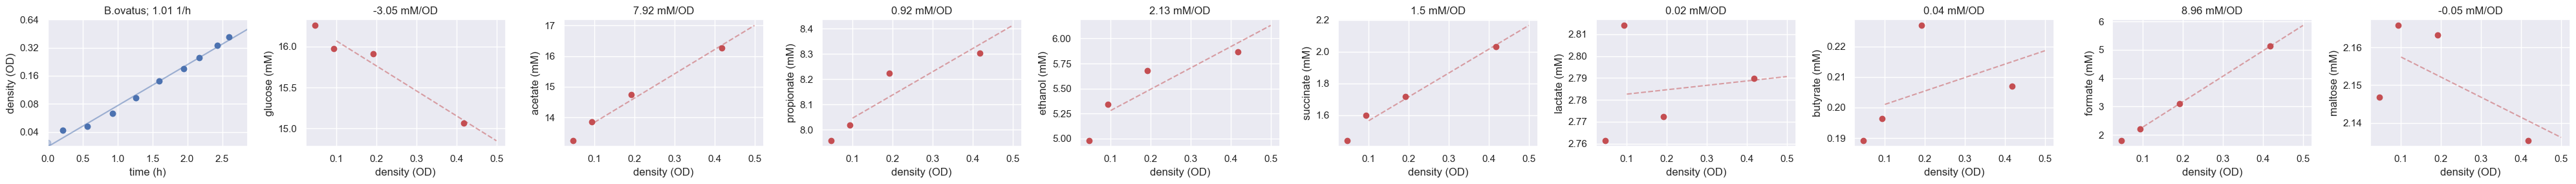

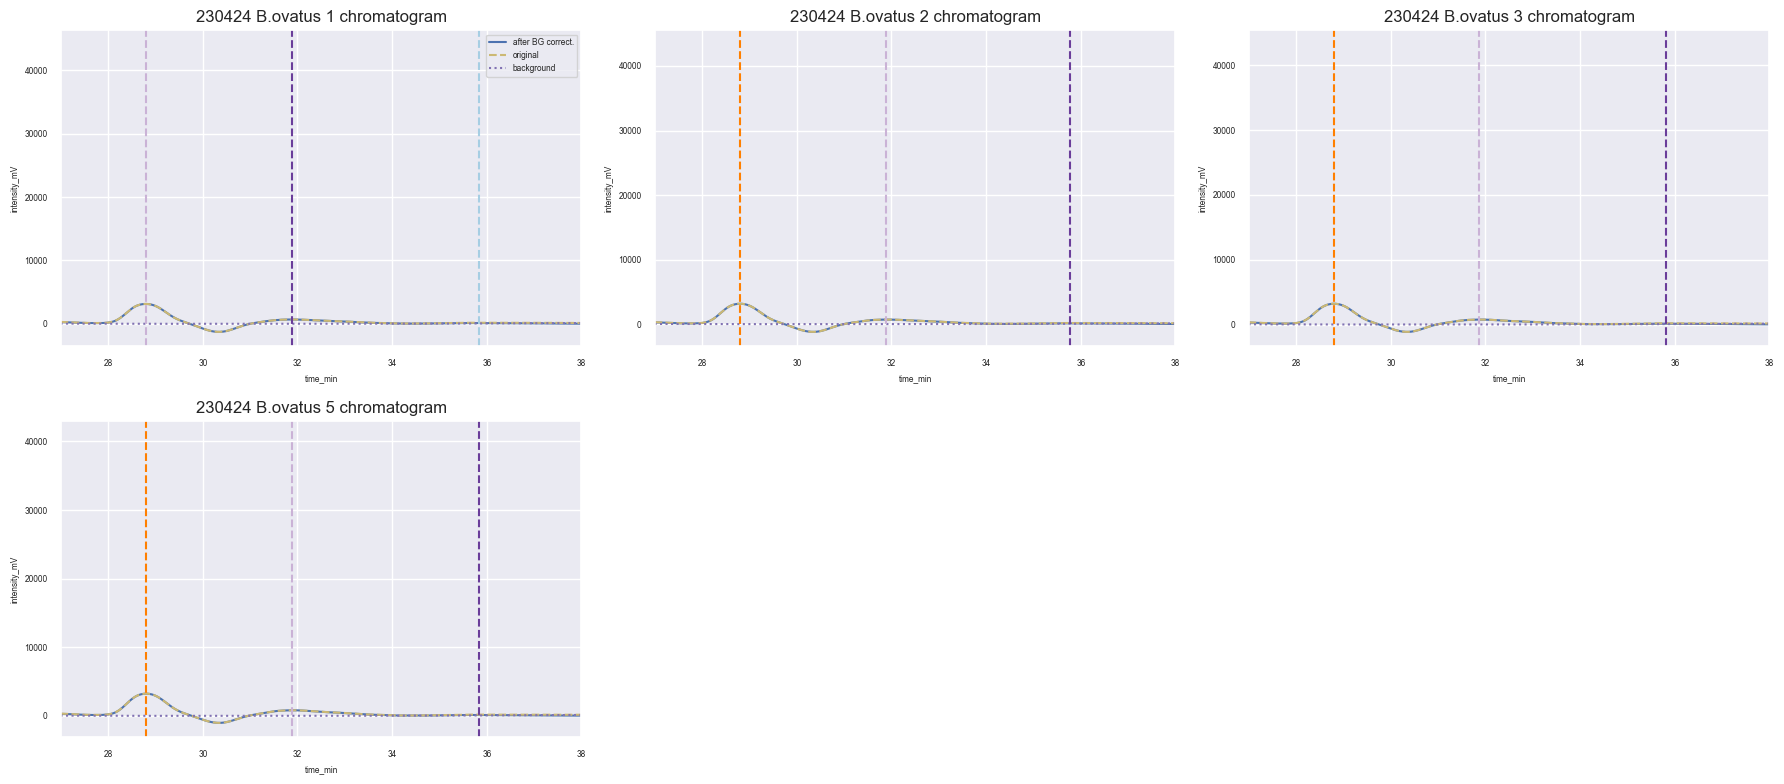

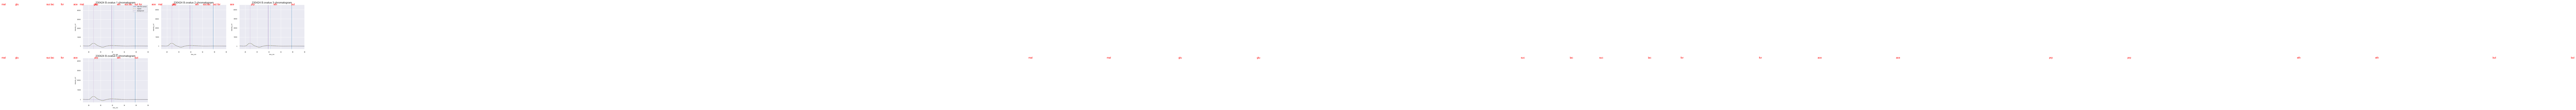

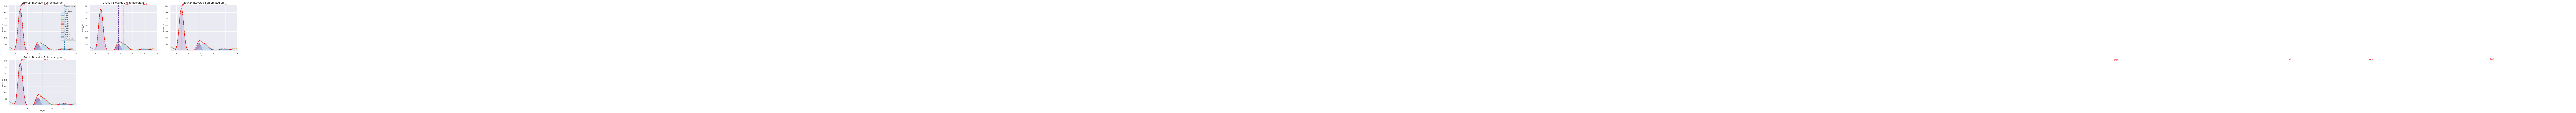

/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1421: DtypeWarning: Columns (0,1,2,3,4,5,6,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  analysis_settings=pd.read_csv(filename_settings,skiprows=1,index_col=0)
/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1421: DtypeWarning: Columns (0,1,2,3,4,5,6,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  analysis_settings=pd.read_csv(filename_settings,skiprows=1,index_col=0)
Processing files...: 100%|████████████████████████| 5/5 [00:00<00:00, 11.46it/s]
/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1113: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list

[2, 3, 6]


retention_time  retention_time_firstguess     scale      skew  \
0        13.335771                   13.32500  0.205037 -0.100000   
1        15.751379                   15.75000  0.214727  0.100000   
2        18.500000                   18.80000  0.800000 -0.100000   
3        20.052176                   20.07500  0.258227 -0.039983   
4        20.956539                   21.09167  0.317220  0.021337   
5        21.649686                   21.54167  0.293733  0.001836   
6        23.356208                   23.28333  0.388130 -0.000079   
7        24.911277                   24.93333  0.322278  0.100000   
8        28.800538                   28.80833  0.361350  0.073225   
9        31.695049                   31.85833  0.303589 -0.023291   
10       32.500000                   32.20000  0.602082  0.100000   
11       36.148694                   36.14167  0.800000  0.001363   

       amplitude          area  peak_idx                            sample  
0   14804.805232   7608.941578         1  230424_B.ovatus_2_1_chromatogram  
1   44548.221205  23977.640037         2  230424_B.ovatus_2_1_chromatogram  
2     292.293240    586.136085         3  230424_B.ovatus_2_1_chromatogram  
3     492.106462    318.530325         4  230424_B.ovatus_2_1_chromatogram  
4    1129.268496    897.940497         5  230424_B.ovatus_2_1_chromatogram  
5    1030.812766    758.965544         6  230424_B.ovatus_2_1_chromatogram  
6     275.575487    268.106838         7  230424_B.ovatus_2_1_chromatogram  
7    3562.524750   2877.913698         8  230424_B.ovatus_2_1_chromatogram  
8    3758.182263   3403.791554         9  230424_B.ovatus_2_1_chromatogram  
9     417.532672    317.736053        10  230424_B.ovatus_2_1_chromatogram  
10    384.716804    580.588745        11  230424_B.ovatus_2_1_chromatogram  
11    118.442245    237.512291        12  230424_B.ovatus_2_1_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        13.335194                   13.32500  0.204087 -0.100000   
1        15.750092                   15.75000  0.214700  0.100000   
2        18.483330                   18.78333  0.800000 -0.100000   
3        20.056084                   20.07500  0.253516 -0.099975   
4        20.965381                   21.10833  0.318451 -0.009480   
5        21.664856                   21.70000  0.293818 -0.099998   
6        23.316369                   23.22500  0.386304  0.001032   
7        24.908944                   24.92500  0.320921  0.100000   
8        28.802402                   28.80000  0.364475  0.059941   
9        31.695803                   31.85000  0.307063 -0.023490   
10       32.500000                   32.20000  0.607684  0.100000   
11       36.130608                   36.15833  0.800000 -0.001211   

       amplitude          area  peak_idx                            sample  
0   14734.589886   7537.745880         1  230424_B.ovatus_2_2_chromatogram  
1   43890.401295  23620.630426         2  230424_B.ovatus_2_2_chromatogram  
2     293.203504    587.961554         3  230424_B.ovatus_2_2_chromatogram  
3     464.205272    294.988179         4  230424_B.ovatus_2_2_chromatogram  
4    1197.235189    955.680074         5  230424_B.ovatus_2_2_chromatogram  
5    1059.819636    780.549540         6  230424_B.ovatus_2_2_chromatogram  
6     295.477585    286.117096         7  230424_B.ovatus_2_2_chromatogram  
7    3616.646826   2909.336506         8  230424_B.ovatus_2_2_chromatogram  
8    3815.518951   3485.546035         9  230424_B.ovatus_2_2_chromatogram  
9     430.580338    331.414573        10  230424_B.ovatus_2_2_chromatogram  
10    380.014282    578.826249        11  230424_B.ovatus_2_2_chromatogram  
11    117.345754    235.313677        12  230424_B.ovatus_2_2_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        13.336148                   13.32500  0.204320 -0.100000   
1        15.750864                   15.75000  0.214892  0.100000   
2        18.508330                   18.80833  0.800000 -0.100000   
3        20.030997                   20.07500  0.237159 -0.023172   
4        20.991706                   21.19167  0.327474 -0.060616   
5        21.623701                   21.70000  0.293821 -0.028121   
6        23.182143                   23.15833  0.369994  0.094797   
7        24.907857                   24.92500  0.318554  0.099910   
8        28.793570                   28.80833  0.360846  0.099802   
9        31.707849                   31.86667  0.305723 -0.041807   
10       32.500000                   32.20000  0.602485  0.100000   
11       36.178598                   36.07500  0.799997 -0.000716   

       amplitude          area  peak_idx                            sample  
0   14728.379845   7543.173988         1  230424_B.ovatus_2_3_chromatogram  
1   42652.963617  22975.243223         2  230424_B.ovatus_2_3_chromatogram  
2     283.557681    568.618632         3  230424_B.ovatus_2_3_chromatogram  
3     416.507969    247.600806         4  230424_B.ovatus_2_3_chromatogram  
4    1310.181654   1075.468599         5  230424_B.ovatus_2_3_chromatogram  
5    1241.378142    914.273223         6  230424_B.ovatus_2_3_chromatogram  
6     466.313288    432.476189         7  230424_B.ovatus_2_3_chromatogram  
7    3881.016619   3098.980560         8  230424_B.ovatus_2_3_chromatogram  
8    3853.869507   3485.587887         9  230424_B.ovatus_2_3_chromatogram  
9     414.977182    318.010394        10  230424_B.ovatus_2_3_chromatogram  
10    368.598115    556.634869        11  230424_B.ovatus_2_3_chromatogram  
11    110.453470    221.491447        12  230424_B.ovatus_2_3_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        13.317646                   13.31667  0.204092  0.000395   
1        15.748760                   15.75000  0.214945  0.100000   
2        18.516670                   18.81667  0.800000 -0.100000   
3        20.061115                   20.08333  0.234358 -0.099944   
4        20.946266                   21.00000  0.317539 -0.000070   
5        21.674270                   21.70000  0.282262 -0.100000   
6        23.111426                   23.10833  0.322599  0.100000   
7        24.912133                   24.93333  0.321471  0.100000   
8        28.790793                   28.80833  0.364693  0.100000   
9        31.706639                   31.90000  0.326766  0.009232   
10       32.500000                   32.20000  0.593546  0.100000   
11       36.049896                   35.75000  0.800000  0.013060   

       amplitude          area  peak_idx                            sample  
0   14703.123855   7521.887945         1  230424_B.ovatus_2_4_chromatogram  
1   41428.275128  22321.003422         2  230424_B.ovatus_2_4_chromatogram  
2     279.472607    560.427216         3  230424_B.ovatus_2_4_chromatogram  
3     729.138823    428.330630         4  230424_B.ovatus_2_4_chromatogram  
4    1824.814721   1452.467465         5  230424_B.ovatus_2_4_chromatogram  
5    1217.997573    861.765592         6  230424_B.ovatus_2_4_chromatogram  
6     829.358862    670.648500         7  230424_B.ovatus_2_4_chromatogram  
7    4457.176357   3591.630931         8  230424_B.ovatus_2_4_chromatogram  
8    3288.262290   3005.568073         9  230424_B.ovatus_2_4_chromatogram  
9     556.494769    455.813621        10  230424_B.ovatus_2_4_chromatogram  
10    539.278407    802.318039        11  230424_B.ovatus_2_4_chromatogram  
11    131.082496    262.859966        12  230424_B.ovatus_2_4_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        13.316635                   13.31667  0.204467 -0.000979   
1        15.748734                   15.75000  0.214987  0.099953   
2        18.516670                   18.81667  0.800000 -0.100000   
3        20.022428                   20.08333  0.223348 -0.099905   
4        20.915171                   20.90000  0.302689  0.024938   
5        21.514163                   21.42500  0.315443  0.008554   
6        23.104233                   23.10000  0.325589  0.098531   
7        24.902585                   24.91667  0.315850  0.100000   
8        28.792442                   28.80833  0.360578  0.099968   
9        31.713432                   31.85000  0.316664 -0.028239   
10       32.500000                   32.20000  0.614270  0.100000   
11       36.120336                   36.11667  0.800000 -0.006337   
12       38.840117                   38.76667  0.481587  0.016736   

       amplitude          area  peak_idx                            sample  
0   14646.954471   7506.887981         1  230424_B.ovatus_2_5_chromatogram  
1   38582.501172  20791.848200         2  230424_B.ovatus_2_5_chromatogram  
2     249.704245    500.732625         3  230424_B.ovatus_2_5_chromatogram  
3     316.903750    177.419082         4  230424_B.ovatus_2_5_chromatogram  
4    1287.257997    976.679039         5  230424_B.ovatus_2_5_chromatogram  
5    2066.602685   1634.061743         6  230424_B.ovatus_2_5_chromatogram  
6     912.222709    744.491931         7  230424_B.ovatus_2_5_chromatogram  
7    4341.932898   3437.584782         8  230424_B.ovatus_2_5_chromatogram  
8    4005.169307   3619.700505         9  230424_B.ovatus_2_5_chromatogram  
9     463.251636    367.709513        10  230424_B.ovatus_2_5_chromatogram  
10    375.620922    578.331123        11  230424_B.ovatus_2_5_chromatogram  
11    108.867894    218.312945        12  230424_B.ovatus_2_5_chromatogram  
12     56.928938     68.165087        13  230424_B.ovatus_2_5_chromatogram

/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:2051: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  growthrates = growthrates.append(dictc, ignore_index=True)


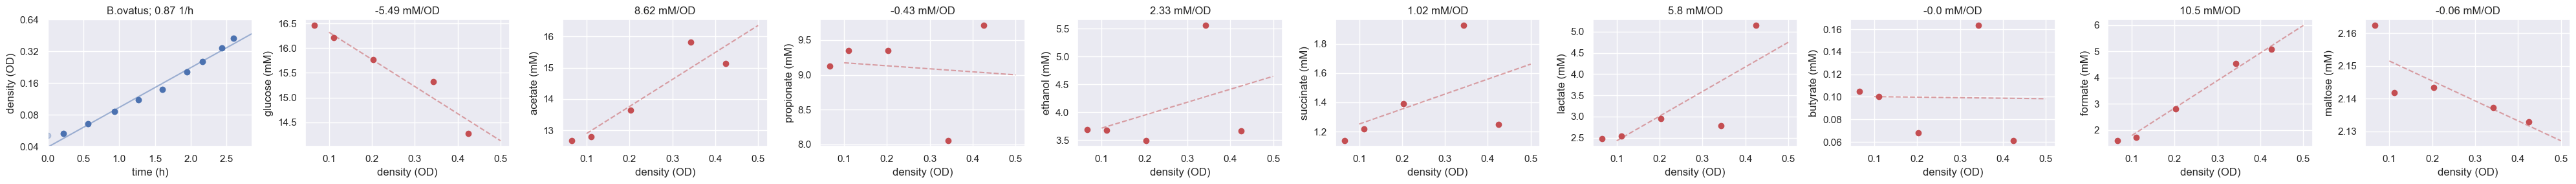

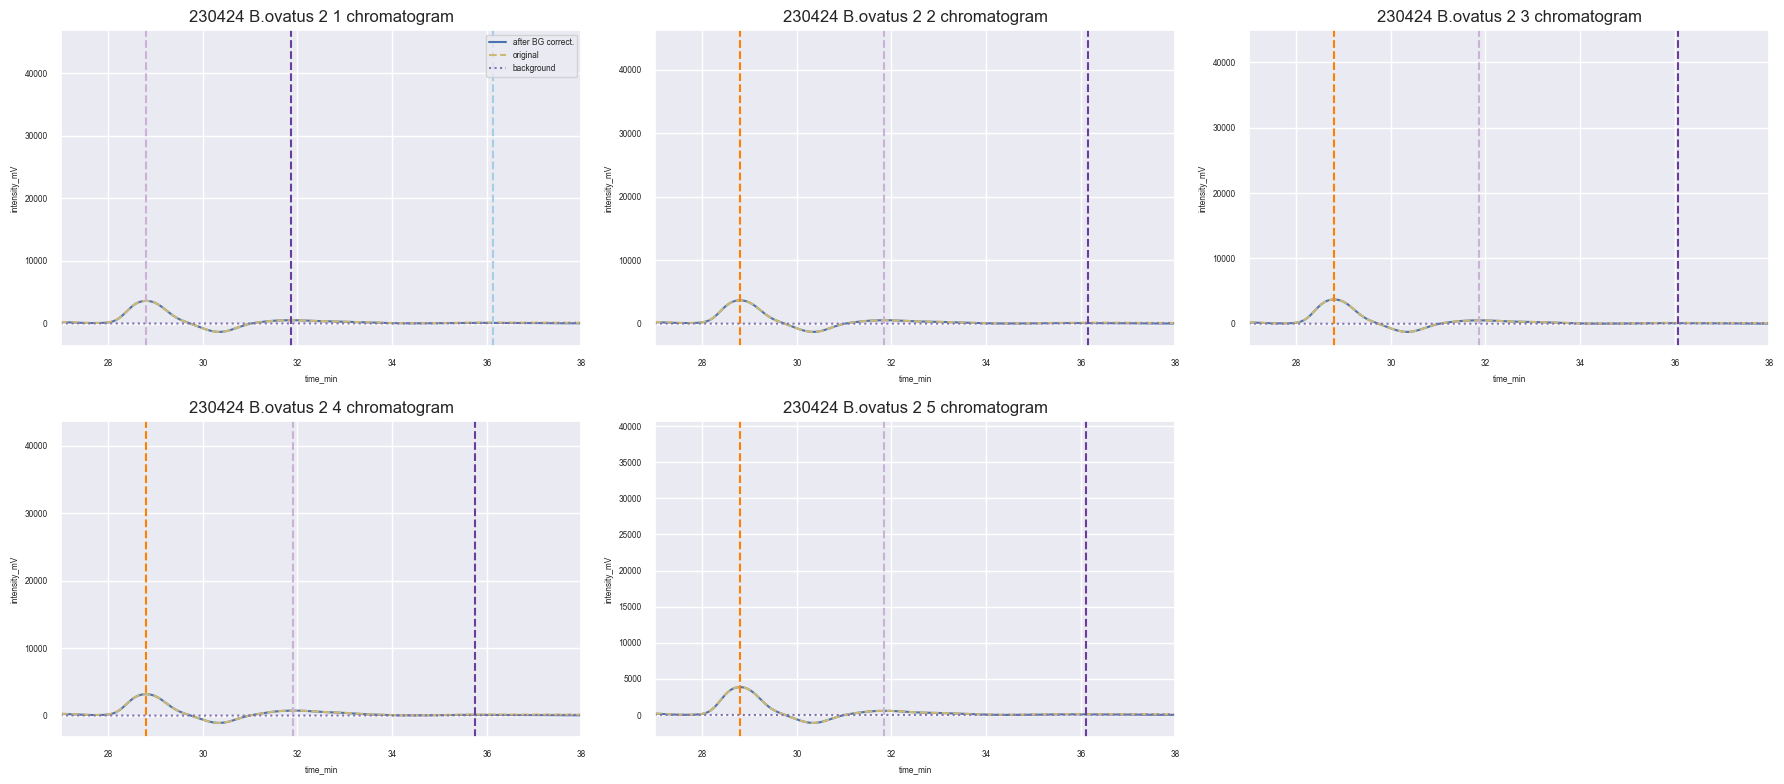

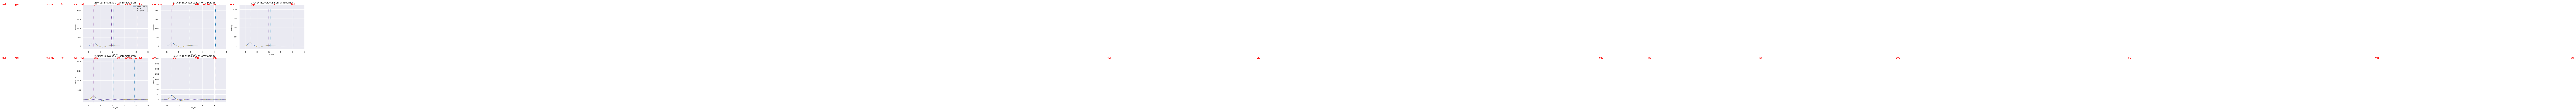

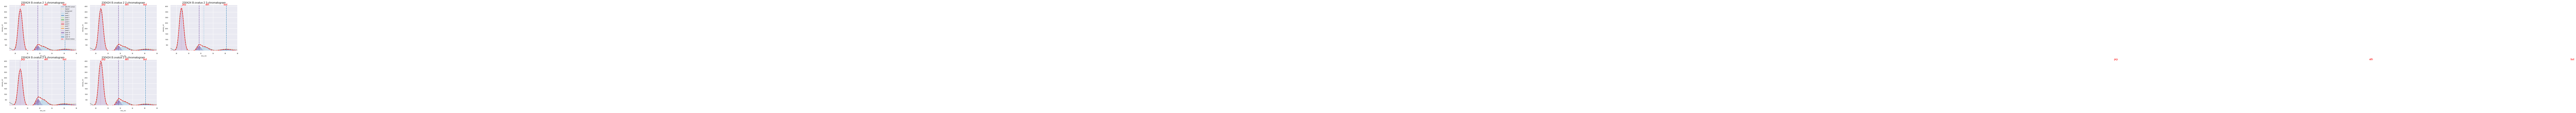

/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1421: DtypeWarning: Columns (0,1,2,3,4,5,6,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  analysis_settings=pd.read_csv(filename_settings,skiprows=1,index_col=0)
/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1421: DtypeWarning: Columns (0,1,2,3,4,5,6,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  analysis_settings=pd.read_csv(filename_settings,skiprows=1,index_col=0)
Processing files...: 100%|████████████████████████| 4/4 [00:00<00:00, 11.47it/s]
/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1113: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list

[2, 3, 6]


retention_time  retention_time_firstguess     scale      skew  \
0        13.318613                   13.31667  0.203042 -0.000323   
1        15.749203                   15.75000  0.214852  0.100000   
2        18.500000                   18.80000  0.800000 -0.100000   
3        20.053511                   20.06667  0.259706 -0.004845   
4        21.046302                   20.90000  0.414268  0.024551   
5        21.689217                   21.60833  0.272820  0.008436   
6        23.195691                   23.15000  0.373896  0.099580   
7        24.923561                   24.92500  0.307440 -0.000080   
8        26.549959                   26.75000  0.719724 -0.100000   
9        28.832657                   28.81667  0.366348  0.006034   
10       32.379813                   32.28333  0.644999  0.085960   
11       35.712783                   35.53333  0.800000 -0.005196   

       amplitude          area  peak_idx                            sample  
0   14973.464767   7620.757780         1  230424_B.vulgatus_1_chromatogram  
1   44452.587595  23940.145848         2  230424_B.vulgatus_1_chromatogram  
2     277.475465    556.422095         3  230424_B.vulgatus_1_chromatogram  
3     386.547527    251.636696         4  230424_B.vulgatus_1_chromatogram  
4     529.225389    549.555383         5  230424_B.vulgatus_1_chromatogram  
5     829.256545    567.093159         6  230424_B.vulgatus_1_chromatogram  
6     417.464922    391.255544         7  230424_B.vulgatus_1_chromatogram  
7    4639.199545   3575.142524         8  230424_B.vulgatus_1_chromatogram  
8     324.610764    585.623663         9  230424_B.vulgatus_1_chromatogram  
9    3796.884224   3486.350710        10  230424_B.vulgatus_1_chromatogram  
10    530.985670    858.242296        11  230424_B.vulgatus_1_chromatogram  
11    221.116753    443.406137        12  230424_B.vulgatus_1_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        13.318134                   13.31667  0.204435  0.000408   
1        15.749988                   15.75000  0.214941  0.099691   
2        18.508407                   18.80833  0.799990 -0.099960   
3        20.046752                   20.08333  0.259072 -0.011444   
4        21.030969                   20.90000  0.413185  0.038603   
5        21.690934                   21.60833  0.269001  0.022457   
6        23.153973                   23.11667  0.341102  0.015257   
7        24.924157                   24.92500  0.307031 -0.000271   
8        26.478681                   26.65000  0.683318 -0.081212   
9        28.809279                   28.81667  0.366282  0.099654   
10       32.351058                   32.23333  0.651751  0.099998   
11       35.673051                   35.50000  0.800000 -0.002971   

       amplitude          area  peak_idx                            sample  
0   14984.690632   7678.816051         1  230424_B.vulgatus_2_chromatogram  
1   43999.559396  23706.001901         2  230424_B.vulgatus_2_chromatogram  
2     258.862611    519.091610         3  230424_B.vulgatus_2_chromatogram  
3     321.349867    208.683373         4  230424_B.vulgatus_2_chromatogram  
4     507.656929    525.781249         5  230424_B.vulgatus_2_chromatogram  
5     828.209200    558.450524         6  230424_B.vulgatus_2_chromatogram  
6     674.968781    577.109525         7  230424_B.vulgatus_2_chromatogram  
7    5038.836303   3877.956859         8  230424_B.vulgatus_2_chromatogram  
8     315.354855    540.147148         9  230424_B.vulgatus_2_chromatogram  
9    3931.226594   3609.030050        10  230424_B.vulgatus_2_chromatogram  
10    551.018112    899.891161        11  230424_B.vulgatus_2_chromatogram  
11    230.875946    462.976126        12  230424_B.vulgatus_2_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        13.317421                   13.31667  0.204281  0.000102   
1        15.750098                   15.75000  0.214891  0.099749   
2        18.483372                   18.78333  0.799995 -0.099978   
3        20.044464                   20.08333  0.265017 -0.012569   
4        21.007625                   20.90000  0.384034  0.041679   
5        21.688200                   21.60833  0.268212  0.023238   
6        23.121087                   23.10000  0.311276  0.015184   
7        24.925067                   24.92500  0.305069  0.000027   
8        26.504519                   26.68333  0.669011 -0.079787   
9        28.810777                   28.82500  0.368702  0.099676   
10       32.323222                   32.18333  0.636762  0.099999   
11       35.657968                   35.52500  0.798078  0.015805   

       amplitude          area  peak_idx                            sample  
0   14900.523180   7629.935311         1  230424_B.vulgatus_3_chromatogram  
1   43080.274425  23205.302753         2  230424_B.vulgatus_3_chromatogram  
2     244.233785    489.759612         3  230424_B.vulgatus_3_chromatogram  
3     273.678222    181.803912         4  230424_B.vulgatus_3_chromatogram  
4     489.294001    471.008848         5  230424_B.vulgatus_3_chromatogram  
5     844.236574    567.587147         6  230424_B.vulgatus_3_chromatogram  
6     962.553367    751.034737         7  230424_B.vulgatus_3_chromatogram  
7    5465.443180   4179.394381         8  230424_B.vulgatus_3_chromatogram  
8     322.363247    540.591046         9  230424_B.vulgatus_3_chromatogram  
9    4119.042181   3806.419272        10  230424_B.vulgatus_3_chromatogram  
10    535.453947    854.382911        11  230424_B.vulgatus_3_chromatogram  
11    226.106989    452.324035        12  230424_B.vulgatus_3_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        13.317396                   13.31667  0.204135  0.000087   
1        15.750692                   15.75000  0.214898  0.100000   
2        18.483330                   18.78333  0.800000 -0.100000   
3        20.006708                   20.00000  0.245754 -0.013479   
4        21.040840                   20.90000  0.394566  0.013298   
5        21.693841                   21.60000  0.258227  0.005752   
6        23.081009                   23.08333  0.296156  0.100000   
7        24.925662                   24.92500  0.303963  0.000270   
8        26.510554                   26.70000  0.654176 -0.099973   
9        28.813344                   28.83333  0.369184  0.100000   
10       32.261284                   32.04167  0.631301  0.099999   
11       35.575313                   35.50000  0.729995  0.022759   
12       38.929456                   38.85833  0.381088  0.007773   

       amplitude          area  peak_idx                            sample  
0   14828.493566   7587.597729         1  230424_B.vulgatus_4_chromatogram  
1   40871.105129  22016.016829         2  230424_B.vulgatus_4_chromatogram  
2     221.757212    444.690256         3  230424_B.vulgatus_4_chromatogram  
3     165.144628    101.731243         4  230424_B.vulgatus_4_chromatogram  
4     502.210255    496.701264         5  230424_B.vulgatus_4_chromatogram  
5     716.465804    463.753494         6  230424_B.vulgatus_4_chromatogram  
6    1543.946301   1146.154368         7  230424_B.vulgatus_4_chromatogram  
7    6443.898461   4909.743643         8  230424_B.vulgatus_4_chromatogram  
8     339.918051    557.389644         9  230424_B.vulgatus_4_chromatogram  
9    4471.212247   4137.105080        10  230424_B.vulgatus_4_chromatogram  
10    588.514416    930.960442        11  230424_B.vulgatus_4_chromatogram  
11    277.972166    508.641154        12  230424_B.vulgatus_4_chromatogram  
12     56.453411     53.795016        13  230424_B.vulgatus_4_chromatogram

/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:2051: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  growthrates = growthrates.append(dictc, ignore_index=True)


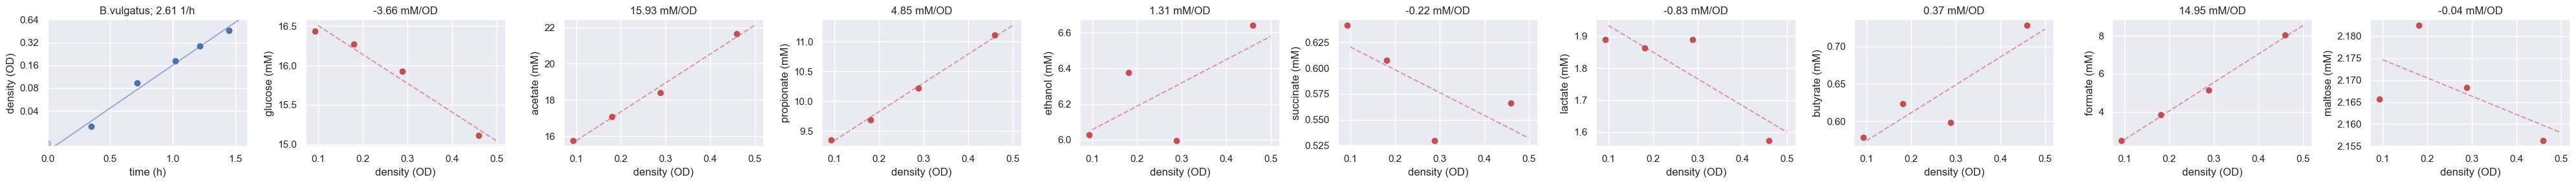

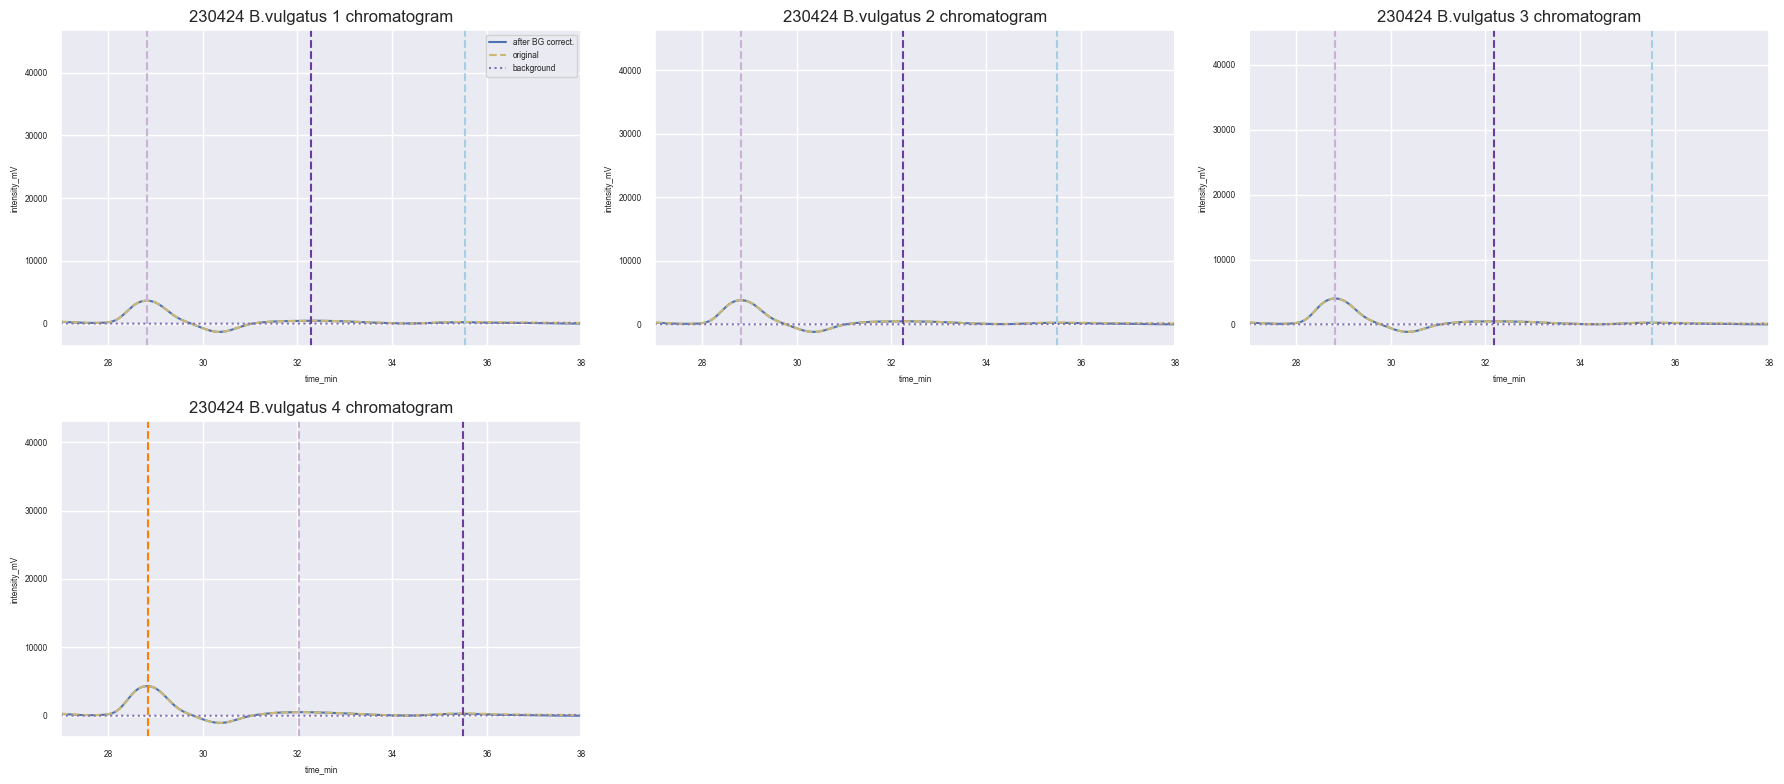

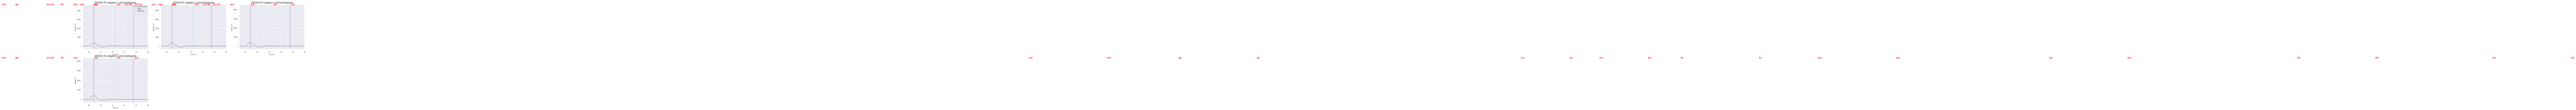

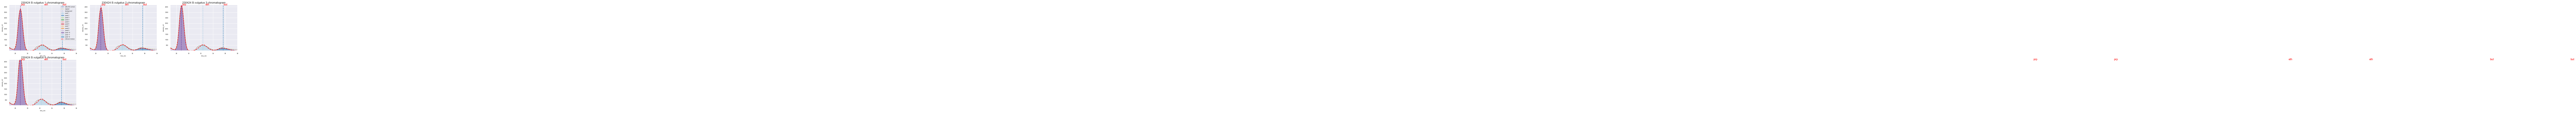

/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1421: DtypeWarning: Columns (0,1,2,3,4,5,6,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  analysis_settings=pd.read_csv(filename_settings,skiprows=1,index_col=0)
/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1421: DtypeWarning: Columns (0,1,2,3,4,5,6,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  analysis_settings=pd.read_csv(filename_settings,skiprows=1,index_col=0)
Processing files...: 100%|████████████████████████| 5/5 [00:00<00:00, 11.49it/s]
/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1113: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list

[2, 3, 6]


retention_time  retention_time_firstguess     scale      skew  \
0        13.336943                   13.32500  0.205397 -0.100000   
1        15.750480                   15.75000  0.214739  0.100000   
2        18.516670                   18.81667  0.800000 -0.100000   
3        20.077228                   20.10000  0.252812 -0.099980   
4        20.912091                   20.98333  0.310934  0.099906   
5        21.684201                   21.59167  0.289587  0.000308   
6        23.379880                   23.31667  0.368171 -0.001725   
7        24.933099                   24.94167  0.313709  0.006670   
8        26.566670                   26.86667  0.800000 -0.090310   
9        28.804245                   28.81667  0.370023  0.095623   
10       32.373273                   32.15833  0.679304  0.097517   
11       36.309646                   36.38333  0.800000 -0.000017   

       amplitude          area  peak_idx                              sample  
0   15090.334703   7769.301761         1  230424_B.vulgatus_2_1_chromatogram  
1   44400.874993  23899.727390         2  230424_B.vulgatus_2_1_chromatogram  
2     288.442457    578.414347         3  230424_B.vulgatus_2_1_chromatogram  
3     760.314445    481.815212         4  230424_B.vulgatus_2_1_chromatogram  
4    1461.982247   1139.463271         5  230424_B.vulgatus_2_1_chromatogram  
5    1319.450732    957.773658         6  230424_B.vulgatus_2_1_chromatogram  
6     250.996115    231.636162         7  230424_B.vulgatus_2_1_chromatogram  
7    3495.843483   2748.966130         8  230424_B.vulgatus_2_1_chromatogram  
8     331.326279    664.407902         9  230424_B.vulgatus_2_1_chromatogram  
9    3502.259493   3247.876995        10  230424_B.vulgatus_2_1_chromatogram  
10    431.147945    733.837756        11  230424_B.vulgatus_2_1_chromatogram  
11    113.185962    226.971590        12  230424_B.vulgatus_2_1_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        13.335477                   13.32500  0.204174 -0.100000   
1        15.749332                   15.75000  0.214789  0.100000   
2        18.508330                   18.80833  0.800000 -0.100000   
3        20.071469                   20.08333  0.251058 -0.096406   
4        20.910154                   20.98333  0.304519  0.099862   
5        21.705273                   21.57500  0.291295 -0.100000   
6        23.360648                   23.29167  0.370125  0.003125   
7        24.910827                   24.93333  0.314296  0.094594   
8        26.591670                   26.89167  0.800000 -0.100000   
9        28.803695                   28.82500  0.369177  0.100000   
10       32.390824                   32.24167  0.676645  0.099849   
11       36.343715                   36.45833  0.800000  0.000701   

       amplitude          area  peak_idx                              sample  
0   14987.199966   7670.251254         1  230424_B.vulgatus_2_2_chromatogram  
1   43162.080305  23238.282625         2  230424_B.vulgatus_2_2_chromatogram  
2     294.663320    590.889062         3  230424_B.vulgatus_2_2_chromatogram  
3     759.333287    477.854823         4  230424_B.vulgatus_2_2_chromatogram  
4    1693.841633   1292.935136         5  230424_B.vulgatus_2_2_chromatogram  
5    1322.514090    965.659358         6  230424_B.vulgatus_2_2_chromatogram  
6     259.757195    240.993775         7  230424_B.vulgatus_2_2_chromatogram  
7    3565.810119   2809.229598         8  230424_B.vulgatus_2_2_chromatogram  
8     325.781461    653.288813         9  230424_B.vulgatus_2_2_chromatogram  
9    3510.938521   3248.537719        10  230424_B.vulgatus_2_2_chromatogram  
10    413.789391    701.564100        11  230424_B.vulgatus_2_2_chromatogram  
11    108.671549    217.918821        12  230424_B.vulgatus_2_2_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        13.336472                   13.32500  0.204247 -0.100000   
1        15.748358                   15.75000  0.214821  0.100000   
2        18.508330                   18.80833  0.800000 -0.100000   
3        20.068365                   20.09167  0.248002 -0.099999   
4        20.907254                   20.96667  0.300273  0.099983   
5        21.703034                   21.57500  0.293433 -0.100000   
6        23.327229                   23.25833  0.372088 -0.000435   
7        24.916774                   24.93333  0.326843  0.100000   
8        28.804276                   28.81667  0.366987  0.095369   
9        32.417866                   32.21667  0.687593  0.099925   
10       36.348591                   36.37500  0.800000 -0.005733   

       amplitude          area  peak_idx                              sample  
0   15018.955059   7689.252097         1  230424_B.vulgatus_2_3_chromatogram  
1   42235.877615  22743.054569         2  230424_B.vulgatus_2_3_chromatogram  
2     296.492648    594.557418         3  230424_B.vulgatus_2_3_chromatogram  
3     760.177725    472.563243         4  230424_B.vulgatus_2_3_chromatogram  
4    1888.420836   1421.362632         5  230424_B.vulgatus_2_3_chromatogram  
5    1335.006451    981.932344         6  230424_B.vulgatus_2_3_chromatogram  
6     293.368142    273.620704         7  230424_B.vulgatus_2_3_chromatogram  
7    3682.071055   3016.625868         8  230424_B.vulgatus_2_3_chromatogram  
8    3488.596660   3208.750429         9  230424_B.vulgatus_2_3_chromatogram  
9     412.263904    710.274393        10  230424_B.vulgatus_2_3_chromatogram  
10    110.905373    222.398303        11  230424_B.vulgatus_2_3_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        13.316134                   13.31667  0.203667 -0.002328   
1        15.744652                   15.74167  0.214870  0.100000   
2        18.516670                   18.81667  0.800000 -0.100000   
3        20.061978                   20.08333  0.243158 -0.099999   
4        20.925153                   20.95000  0.297144  0.001946   
5        21.700070                   21.70000  0.293526 -0.100000   
6        23.299411                   23.21667  0.374554 -0.000108   
7        24.911963                   24.92500  0.325665  0.100000   
8        28.800494                   28.81667  0.364739  0.100000   
9        32.435076                   32.25000  0.682885  0.099986   
10       36.398399                   36.35833  0.800000 -0.000684   

       amplitude          area  peak_idx                              sample  
0   15001.065082   7658.294728         1  230424_B.vulgatus_2_4_chromatogram  
1   41169.271846  22173.742003         2  230424_B.vulgatus_2_4_chromatogram  
2     301.080641    603.757608         3  230424_B.vulgatus_2_4_chromatogram  
3     756.632597    461.171781         4  230424_B.vulgatus_2_4_chromatogram  
4    2066.187996   1538.958760         5  230424_B.vulgatus_2_4_chromatogram  
5    1333.536097    981.161870         6  230424_B.vulgatus_2_4_chromatogram  
6     313.426340    294.265802         7  230424_B.vulgatus_2_4_chromatogram  
7    3755.987838   3066.095658         8  230424_B.vulgatus_2_4_chromatogram  
8    3480.813423   3182.061350         9  230424_B.vulgatus_2_4_chromatogram  
9     392.227399    671.159894        10  230424_B.vulgatus_2_4_chromatogram  
10    104.965025    210.486022        11  230424_B.vulgatus_2_4_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        13.316431                   13.31667  0.203850 -0.001206   
1        15.744047                   15.74167  0.214899  0.100000   
2        18.500000                   18.80000  0.800000 -0.100000   
3        20.058521                   20.08333  0.240610 -0.100000   
4        20.923690                   20.95000  0.296616  0.000439   
5        21.699996                   21.70000  0.291819 -0.100000   
6        23.308033                   23.22500  0.370322 -0.060770   
7        24.910146                   24.92500  0.324536  0.100000   
8        28.798664                   28.81667  0.364454  0.099995   
9        32.441026                   32.28333  0.683810  0.099031   
10       36.445010                   36.54167  0.800000 -0.000883   

       amplitude          area  peak_idx                              sample  
0   15062.685170   7696.644464         1  230424_B.vulgatus_2_5_chromatogram  
1   40944.343429  22055.546782         2  230424_B.vulgatus_2_5_chromatogram  
2     304.788338    611.192652         3  230424_B.vulgatus_2_5_chromatogram  
3     756.977010    456.547006         4  230424_B.vulgatus_2_5_chromatogram  
4    2158.594844   1604.926308         5  230424_B.vulgatus_2_5_chromatogram  
5    1333.608181    975.508661         6  230424_B.vulgatus_2_5_chromatogram  
6     315.405807    292.778293         7  230424_B.vulgatus_2_5_chromatogram  
7    3807.546312   3097.408942         8  230424_B.vulgatus_2_5_chromatogram  
8    3495.849996   3193.319488         9  230424_B.vulgatus_2_5_chromatogram  
9     385.878069    661.192480        10  230424_B.vulgatus_2_5_chromatogram  
10    104.337860    209.228155        11  230424_B.vulgatus_2_5_chromatogram

/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:2051: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  growthrates = growthrates.append(dictc, ignore_index=True)


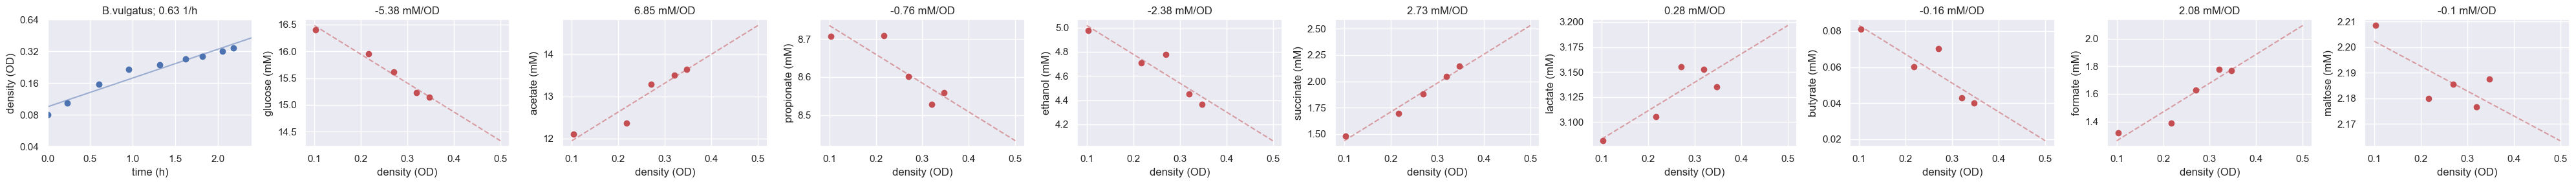

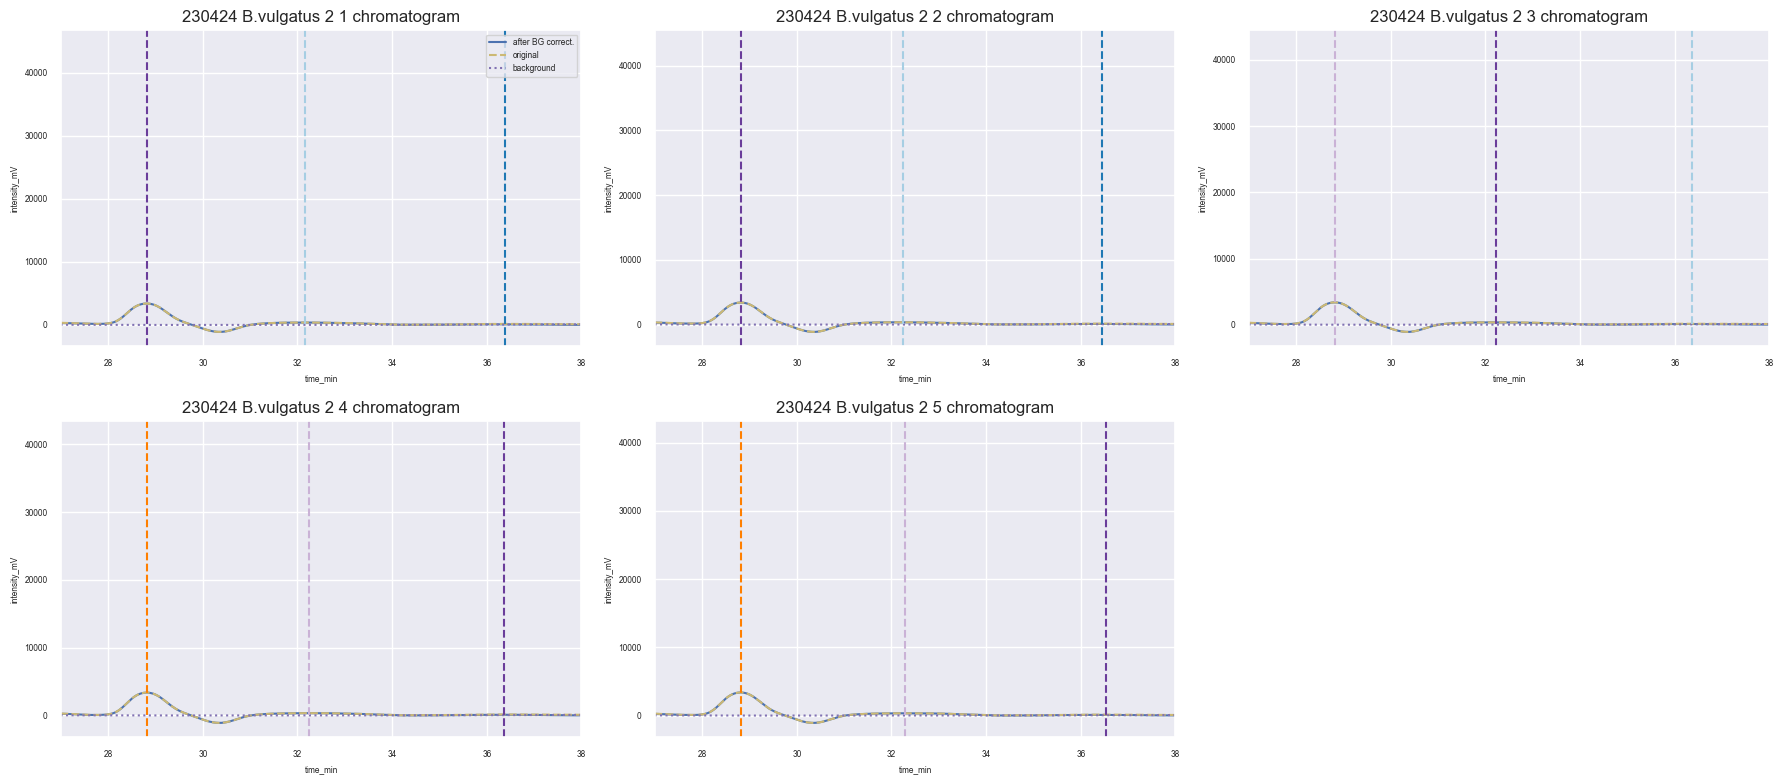

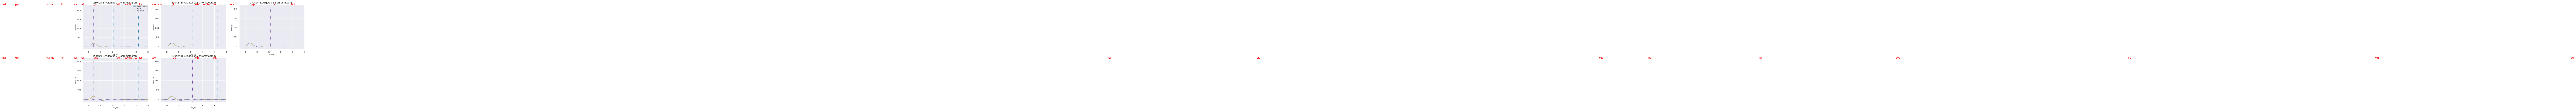

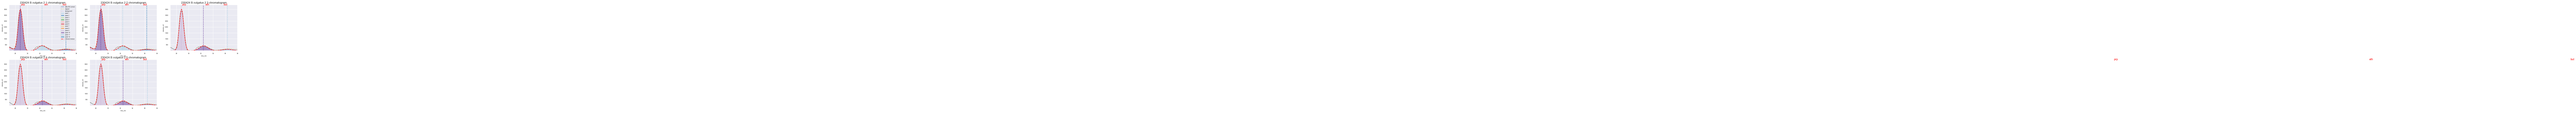

/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1421: DtypeWarning: Columns (0,1,2,3,4,5,6,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  analysis_settings=pd.read_csv(filename_settings,skiprows=1,index_col=0)
/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1421: DtypeWarning: Columns (0,1,2,3,4,5,6,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  analysis_settings=pd.read_csv(filename_settings,skiprows=1,index_col=0)
Processing files...: 100%|████████████████████████| 3/3 [00:00<00:00, 11.34it/s]
/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1113: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list

[2, 3, 6]


retention_time  retention_time_firstguess     scale      skew  \
0        13.317510                   13.31667  0.205692  0.000136   
1        15.745931                   15.74167  0.214920  0.100000   
2        18.508330                   18.80833  0.800000 -0.100000   
3        20.070893                   20.09167  0.262197 -0.045470   
4        21.000018                   20.90000  0.402322  0.027726   
5        21.718997                   21.58333  0.285695 -0.099888   
6        23.445294                   23.38333  0.347299 -0.002836   
7        24.931705                   24.93333  0.316370  0.009865   
8        26.597559                   26.89167  0.800000  0.001264   
9        28.789514                   28.80000  0.370657  0.099927   
10       32.354518                   32.17500  0.650326  0.099595   
11       36.372631                   36.37500  0.800000 -0.000004   

       amplitude          area  peak_idx                               sample  
0   15083.518088   7776.961067         1  230424_P.distastonis_1_chromatogram  
1   46494.861907  25047.893169         2  230424_P.distastonis_1_chromatogram  
2     308.868284    619.374306         3  230424_P.distastonis_1_chromatogram  
3     749.945178    492.886092         4  230424_P.distastonis_1_chromatogram  
4     776.194972    782.770821         5  230424_P.distastonis_1_chromatogram  
5     980.490158    702.160750         6  230424_P.distastonis_1_chromatogram  
6     216.068351    188.098354         7  230424_P.distastonis_1_chromatogram  
7    3154.502237   2501.591850         8  230424_P.distastonis_1_chromatogram  
8     368.235814    738.421435         9  230424_P.distastonis_1_chromatogram  
9    3356.510829   3118.171353        10  230424_P.distastonis_1_chromatogram  
10    405.919240    661.503635        11  230424_P.distastonis_1_chromatogram  
11    109.413848    219.407332        12  230424_P.distastonis_1_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        13.332349                   13.31667  0.204295 -0.100000   
1        15.741781                   15.74167  0.214859  0.100000   
2        18.516670                   18.81667  0.800000 -0.100000   
3        20.057933                   20.07500  0.265848 -0.008169   
4        20.976515                   20.90000  0.373227  0.034198   
5        21.681582                   21.57500  0.287132  0.011427   
6        23.427146                   23.38333  0.352506  0.013023   
7        24.928143                   24.92500  0.316258  0.001886   
8        26.598222                   26.87500  0.800000 -0.000080   
9        28.786032                   28.80000  0.373558  0.099992   
10       32.394348                   32.32500  0.689143  0.098647   
11       36.343998                   36.41667  0.800000 -0.001712   

       amplitude          area  peak_idx                               sample  
0   14993.263606   7677.893590         1  230424_P.distastonis_2_chromatogram  
1   45482.440392  24495.529930         2  230424_P.distastonis_2_chromatogram  
2     318.026032    637.738099         3  230424_P.distastonis_2_chromatogram  
3     757.340169    504.677395         4  230424_P.distastonis_2_chromatogram  
4     854.448101    799.370996         5  230424_P.distastonis_2_chromatogram  
5    1037.709820    746.873267         6  230424_P.distastonis_2_chromatogram  
6     222.950675    196.999343         7  230424_P.distastonis_2_chromatogram  
7    3190.688644   2529.390280         8  230424_P.distastonis_2_chromatogram  
8     379.216346    760.439532         9  230424_P.distastonis_2_chromatogram  
9    3389.903857   3173.590548        10  230424_P.distastonis_2_chromatogram  
10    403.135336    696.118736        11  230424_P.distastonis_2_chromatogram  
11    112.223435    225.041341        12  230424_P.distastonis_2_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        13.333291                   13.31667  0.204382 -0.100000   
1        15.742871                   15.74167  0.215038  0.099595   
2        18.516695                   18.81667  0.799999 -0.099984   
3        20.046429                   20.07500  0.251742 -0.011119   
4        20.943390                   20.99167  0.315078 -0.008647   
5        21.683799                   21.70000  0.291275 -0.058763   
6        23.261980                   23.20000  0.387691  0.076721   
7        24.928468                   24.92500  0.314189  0.001232   
8        26.500644                   26.80000  0.785412 -0.099766   
9        28.817848                   28.81667  0.365992  0.063554   
10       32.530207                   32.41667  0.712278  0.037823   
11       36.409315                   36.41667  0.800000  0.000608   

       amplitude          area  peak_idx                               sample  
0   14915.520192   7641.365667         1  230424_P.distastonis_3_chromatogram  
1   40914.355300  22053.651597         2  230424_P.distastonis_3_chromatogram  
2     315.101100    631.872183         3  230424_P.distastonis_3_chromatogram  
3     753.143714    475.252168         4  230424_P.distastonis_3_chromatogram  
4    1583.681935   1250.768217         5  230424_P.distastonis_3_chromatogram  
5    1144.479159    835.604345         6  230424_P.distastonis_3_chromatogram  
6     332.832891    323.446561         7  230424_P.distastonis_3_chromatogram  
7    3587.545621   2825.393321         8  230424_P.distastonis_3_chromatogram  
8     306.686919    603.785438         9  230424_P.distastonis_3_chromatogram  
9    3562.813316   3267.990848        10  230424_P.distastonis_3_chromatogram  
10    382.034685    681.843460        11  230424_P.distastonis_3_chromatogram  
11    119.237112    239.105637        12  230424_P.distastonis_3_chromatogram

/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:2051: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  growthrates = growthrates.append(dictc, ignore_index=True)


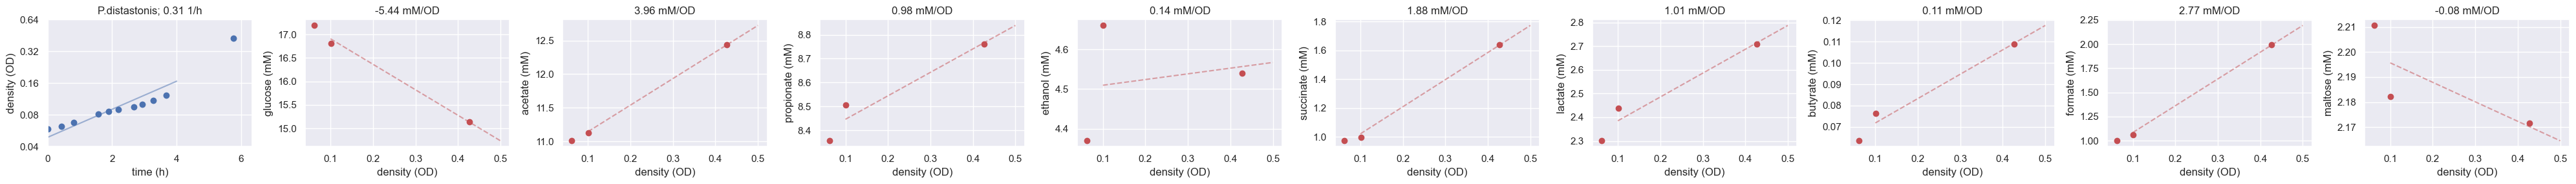

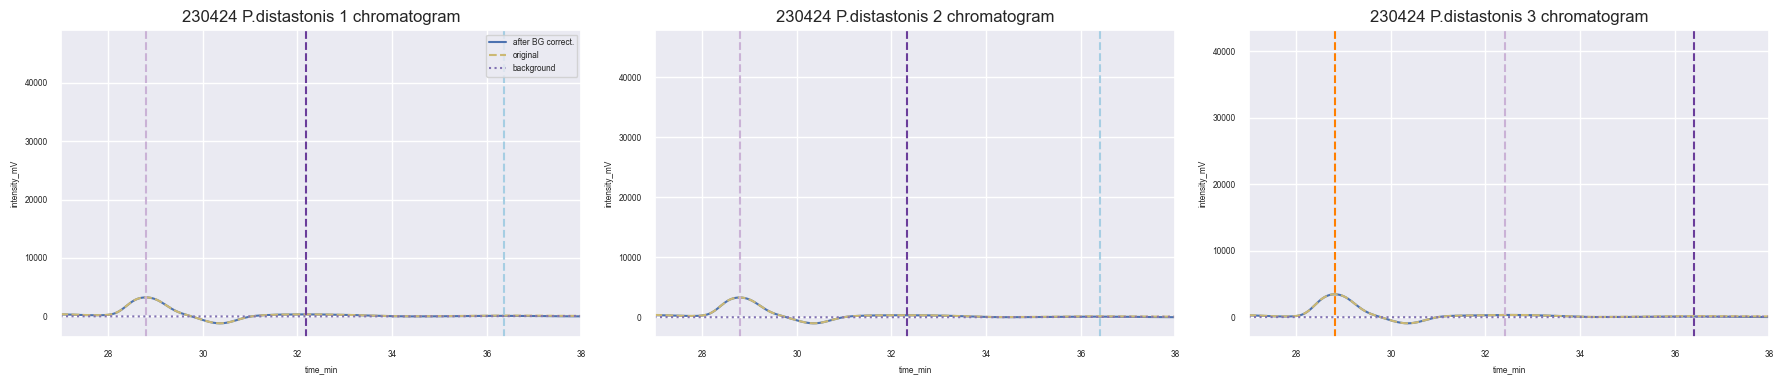

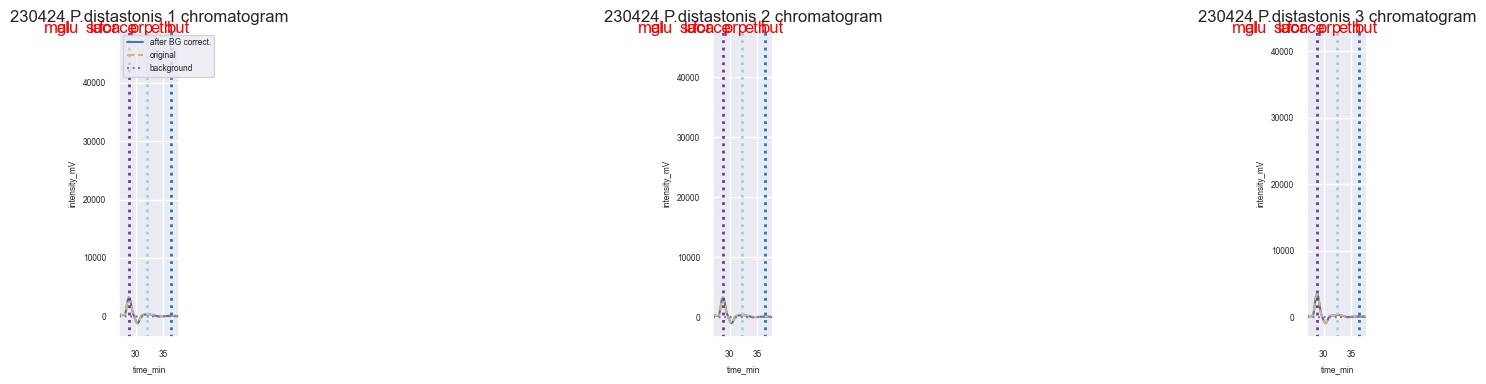

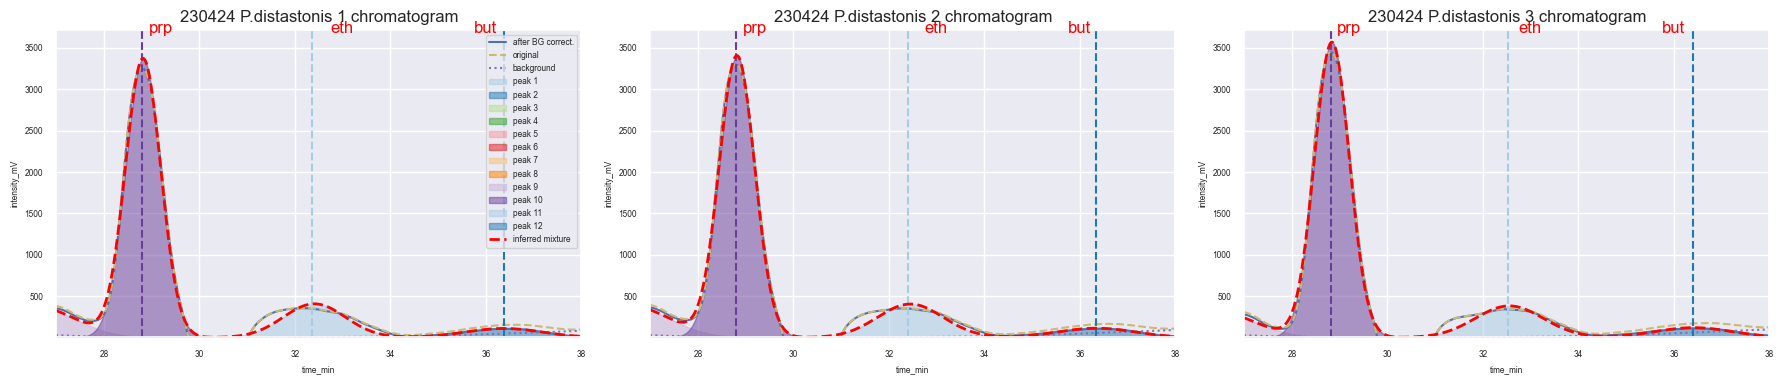

/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1421: DtypeWarning: Columns (0,1,2,3,4,5,6,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  analysis_settings=pd.read_csv(filename_settings,skiprows=1,index_col=0)


/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1421: DtypeWarning: Columns (0,1,2,3,4,5,6,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  analysis_settings=pd.read_csv(filename_settings,skiprows=1,index_col=0)


Processing files...: 100%|████████████████████████| 3/3 [00:00<00:00, 11.52it/s]
/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1113: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g, d in chrom_df.groupby(['sample']):
Processing files...: 100%|████████████████████████| 3/3 [00:00<00:00, 12.95it/s]
/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1113: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g, d in chrom_df.groupby(['sample']):
Processing files...:   0%|                                | 0/3 [00:00<?

[2, 3, 6]


retention_time  retention_time_firstguess     scale      skew  \
0        12.500000                   12.20000  0.800000  0.100000   
1        13.318669                   13.31667  0.201275  0.000326   
2        15.735204                   15.74167  0.203944  0.100000   
3        16.200000                   16.50000  0.181370 -0.100000   
4        17.300000                   17.60000  0.604045 -0.100000   
5        17.700000                   18.00000  0.799754 -0.100000   
6        18.926366                   18.82500  0.319169  0.020088   
7        20.067503                   20.08333  0.301281 -0.005657   
8        20.961352                   20.90000  0.323256  0.008303   
9        21.658411                   21.58333  0.301269  0.015160   
10       23.432777                   23.39167  0.350767 -0.002283   
11       24.917078                   24.93333  0.332943  0.100000   
12       28.838370                   28.80000  0.362330 -0.084992   
13       32.404309                   32.21667  0.654740  0.099959   
14       36.314007                   36.36667  0.800000  0.000990   

       amplitude          area  peak_idx  \
0     179.146644    268.556731         1   
1   14889.150149   7511.895043         2   
2   46604.430789  23824.704047         3   
3    3254.573970   1479.614586         4   
4     391.550439    592.852065         5   
5      21.582938     43.266357         6   
6     265.142734    212.124404         7   
7     818.270242    617.956289         8   
8     757.028360    613.406783         9   
9    1108.433865    837.053826        10   
10    238.670302    209.848969        11   
11   3166.958917   2643.027832        12   
12   3273.939655   2973.317861        13   
13    408.503629    670.235010        14   
14    115.363782    231.338753        15   

                                   sample  
0   230424_P.distastonis_2_1_chromatogram  
1   230424_P.distastonis_2_1_chromatogram  
2   230424_P.distastonis_2_1_chromatogram  
3   230424_P.distastonis_2_1_chromatogram  
4   230424_P.distastonis_2_1_chromatogram  
5   230424_P.distastonis_2_1_chromatogram  
6   230424_P.distastonis_2_1_chromatogram  
7   230424_P.distastonis_2_1_chromatogram  
8   230424_P.distastonis_2_1_chromatogram  
9   230424_P.distastonis_2_1_chromatogram  
10  230424_P.distastonis_2_1_chromatogram  
11  230424_P.distastonis_2_1_chromatogram  
12  230424_P.distastonis_2_1_chromatogram  
13  230424_P.distastonis_2_1_chromatogram  
14  230424_P.distastonis_2_1_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        12.500000                   12.20000  0.800000  0.100000   
1        13.334281                   13.31667  0.202074 -0.100000   
2        15.733207                   15.74167  0.204001  0.100000   
3        16.200000                   16.50000  0.184171 -0.100000   
4        17.300000                   17.60000  0.616190 -0.100000   
5        17.929066                   18.00000  0.002063  0.037884   
6        18.931529                   18.81667  0.324740  0.032056   
7        20.061088                   20.08333  0.302738 -0.008671   
8        20.933664                   20.90000  0.319358  0.098905   
9        21.659599                   21.57500  0.301214 -0.008359   
10       23.445562                   23.39167  0.354365 -0.093389   
11       24.913236                   24.93333  0.332021  0.099999   
12       28.783430                   28.79167  0.363606  0.099989   
13       32.428489                   32.30833  0.670348  0.082655   
14       36.349666                   36.41667  0.800000 -0.000846   

       amplitude          area  peak_idx  \
0     184.027535    275.873620         1   
1   14887.720123   7540.995328         2   
2   45730.756929  23384.678495         3   
3    3151.755259   1455.001575         4   
4     423.085374    653.479367         5   
5      39.083989      0.084754         6   
6     273.032519    222.249390         7   
7     813.743529    617.510631         8   
8     819.473140    655.998309         9   
9    1120.451737    845.975528        10   
10    240.436093    213.570041        11   
11   3193.911874   2658.141217        12   
12   3289.955095   2998.301118        13   
13    394.019389    661.875345        14   
14    112.916570    226.431414        15   

                                   sample  
0   230424_P.distastonis_2_2_chromatogram  
1   230424_P.distastonis_2_2_chromatogram  
2   230424_P.distastonis_2_2_chromatogram  
3   230424_P.distastonis_2_2_chromatogram  
4   230424_P.distastonis_2_2_chromatogram  
5   230424_P.distastonis_2_2_chromatogram  
6   230424_P.distastonis_2_2_chromatogram  
7   230424_P.distastonis_2_2_chromatogram  
8   230424_P.distastonis_2_2_chromatogram  
9   230424_P.distastonis_2_2_chromatogram  
10  230424_P.distastonis_2_2_chromatogram  
11  230424_P.distastonis_2_2_chromatogram  
12  230424_P.distastonis_2_2_chromatogram  
13  230424_P.distastonis_2_2_chromatogram  
14  230424_P.distastonis_2_2_chromatogram

retention_time  retention_time_firstguess     scale      skew  \
0        12.500000                   12.20000  0.800000  0.100000   
1        13.331349                   13.31667  0.201967 -0.100000   
2        15.729635                   15.73333  0.204172  0.100000   
3        16.200000                   16.50000  0.188532 -0.100000   
4        17.300000                   17.60000  0.615290 -0.100000   
5        17.937797                   18.00000  0.000597  0.001338   
6        18.937189                   18.82500  0.328760  0.042025   
7        20.033437                   20.07500  0.278686 -0.016060   
8        20.935373                   20.99167  0.306182 -0.006717   
9        21.661287                   21.70000  0.295078 -0.021342   
10       23.301476                   23.18333  0.376361 -0.089629   
11       24.907531                   24.91667  0.327768  0.100000   
12       28.797931                   28.81667  0.368000  0.099727   
13       32.479774                   32.43333  0.699481  0.099970   
14       36.431973                   36.47500  0.800000  0.003891   

       amplitude          area  peak_idx  \
0     186.983483  2.801625e+02         1   
1   14825.826488  7.505672e+03         2   
2   41268.423610  2.112051e+04         3   
3    2790.786108  1.318869e+03         4   
4     417.283784  6.435776e+02         5   
5      20.748559  1.238545e-10         6   
6     285.180994  2.350119e+02         7   
7     792.927002  5.539087e+02         8   
8    1558.470925  1.196104e+03         9   
9    1144.087924  8.462259e+02        10   
10    328.848587  3.102345e+02        11   
11   3576.303426  2.938266e+03        12   
12   3537.709222  3.262789e+03        13   
13    367.811040  6.447007e+02        14   
14    115.843919  2.323012e+02        15   

                                   sample  
0   230424_P.distastonis_2_3_chromatogram  
1   230424_P.distastonis_2_3_chromatogram  
2   230424_P.distastonis_2_3_chromatogram  
3   230424_P.distastonis_2_3_chromatogram  
4   230424_P.distastonis_2_3_chromatogram  
5   230424_P.distastonis_2_3_chromatogram  
6   230424_P.distastonis_2_3_chromatogram  
7   230424_P.distastonis_2_3_chromatogram  
8   230424_P.distastonis_2_3_chromatogram  
9   230424_P.distastonis_2_3_chromatogram  
10  230424_P.distastonis_2_3_chromatogram  
11  230424_P.distastonis_2_3_chromatogram  
12  230424_P.distastonis_2_3_chromatogram  
13  230424_P.distastonis_2_3_chromatogram  
14  230424_P.distastonis_2_3_chromatogram

/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:2051: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  growthrates = growthrates.append(dictc, ignore_index=True)


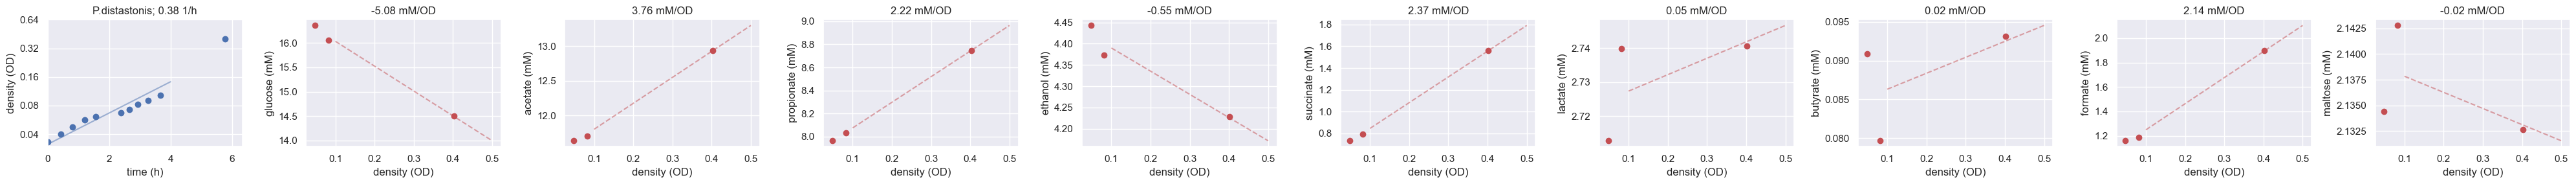

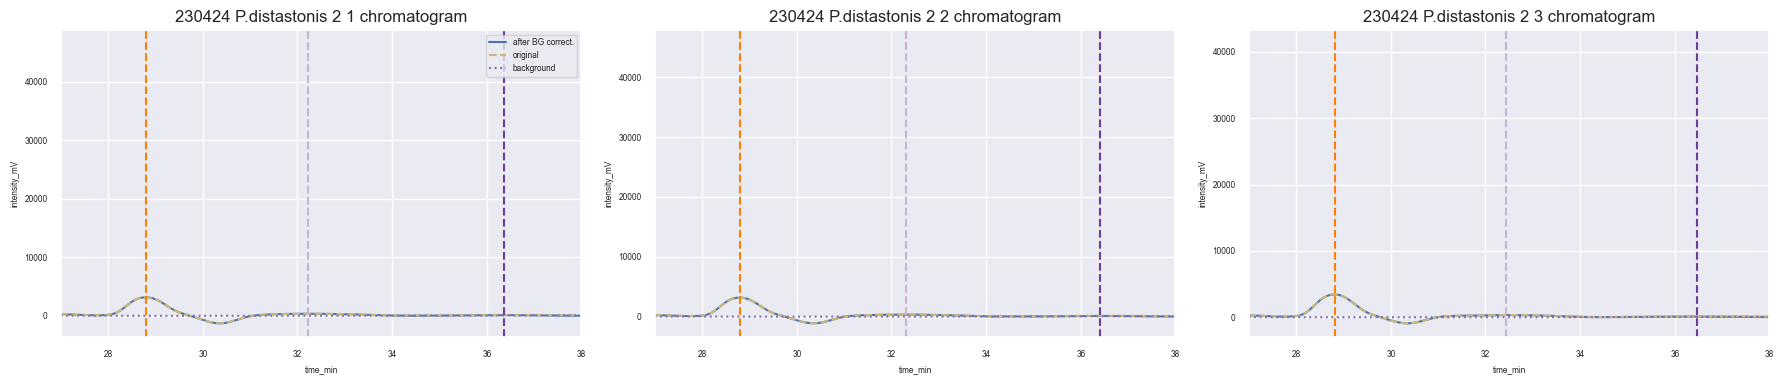

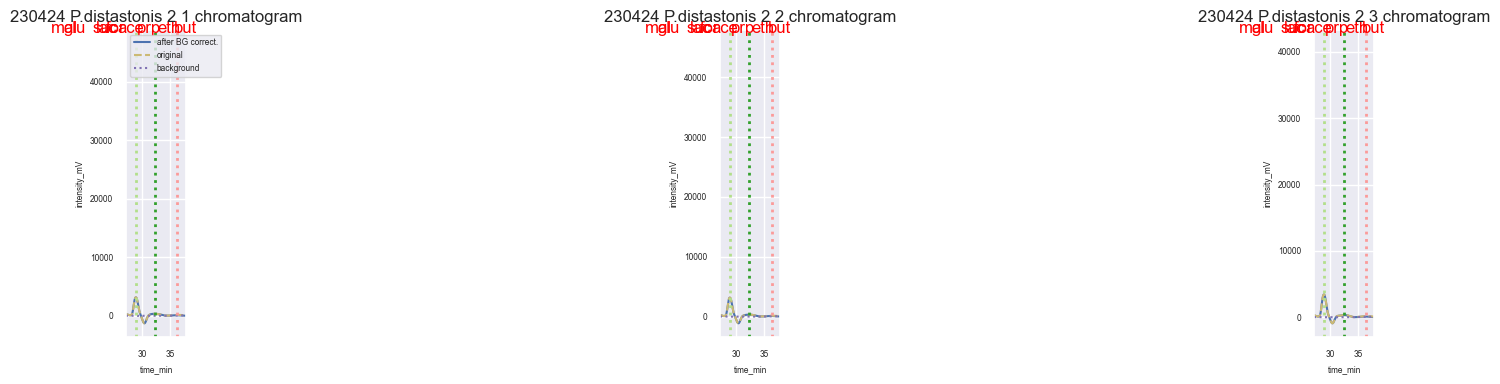

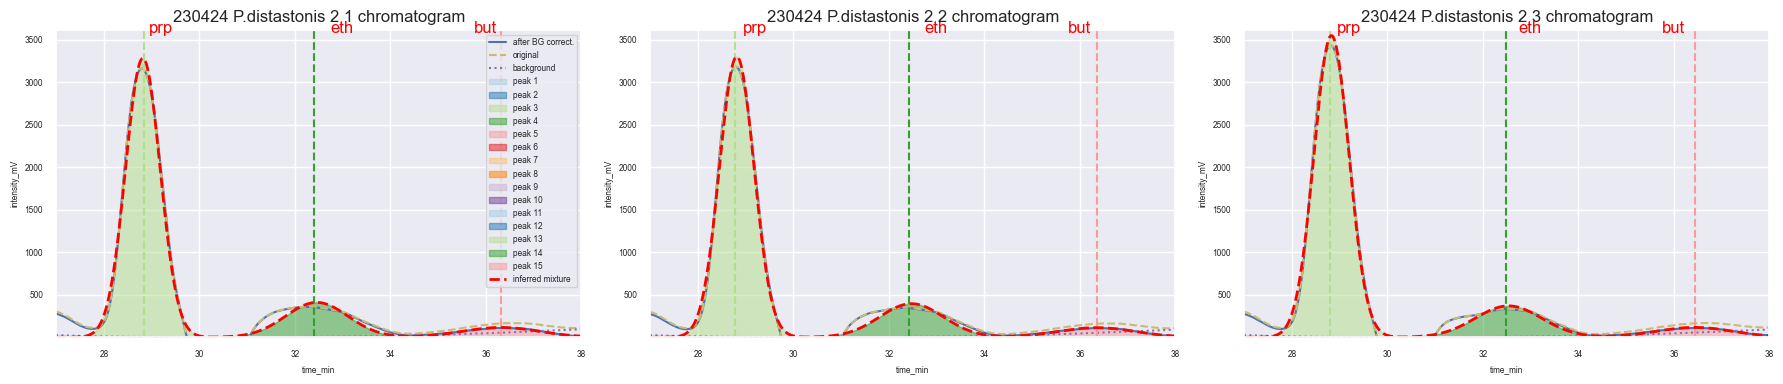

culture  growth-rate        y0  glucose-turnover  glucose_error  \
0               NCM     1.692812  0.046824         -3.749915       0.020377   
1             NCM_2     1.490171  0.080403         -3.862912       0.055280   
2        B.fragilis     0.923190  0.045473         -3.951475       0.001235   
3      B.fragilis_2     0.472668  0.085382         -6.248210       0.039619   
4      B.finegoldii     0.821864  0.049643         -4.074810       0.260587   
5    B.finegoldii_2     0.484859  0.064620         -5.546640       0.031871   
6          B.ovatus     1.014289  0.027705         -3.050090       0.186127   
7        B.ovatus_2     0.869525  0.039405         -5.490930       0.671566   
8        B.vulgatus     2.613912  0.011779         -3.661373       0.216702   
9      B.vulgatus_2     0.629659  0.095400         -5.380829       0.191900   
10    P.distastonis     0.306826  0.048886         -5.435233       0.174759   
11  P.distastonis_2     0.378473  0.031316         -5.083492       0.109697   

                                          glucose_val  acetate-turnover  \
0   [[0.056, 0.105, 0.185, 0.292, 0.395], [17.7752...          7.749386   
1   [[0.076, 0.136, 0.187, 0.352, 0.397], [17.5946...          9.249960   
2   [[0.071, 0.14, 0.256, 0.348, 0.481], [17.39435...          3.764924   
3   [[0.085, 0.17, 0.21, 0.304, 0.362], [16.609968...          3.537044   
4   [[0.062, 0.107, 0.175, 0.3, 0.452], [17.469494...          3.275766   
5   [[0.083, 0.104, 0.162, 0.64], [17.273871767725...          4.380910   
6   [[0.046, 0.093, 0.192, 0.418], [16.25921941110...          7.916466   
7   [[0.066, 0.111, 0.203, 0.343, 0.425], [16.4599...          8.622945   
8   [[0.093, 0.181, 0.289, 0.46], [16.434249727897...         15.929650   
9   [[0.103, 0.217, 0.27, 0.32, 0.347], [16.406535...          6.848820   
10  [[0.062, 0.101, 0.427], [17.193823915222538, 1...          3.955224   
11  [[0.048, 0.082, 0.402], [16.355092134518586, 1...          3.757870   

    acetate_error                                        acetate_val  \
0        4.373329  [[0.056, 0.105, 0.185, 0.292, 0.395], [12.2232...   
1        0.328208  [[0.076, 0.136, 0.187, 0.352, 0.397], [12.0893...   
2        0.005582  [[0.071, 0.14, 0.256, 0.348, 0.481], [11.56464...   
3        0.009061  [[0.085, 0.17, 0.21, 0.304, 0.362], [12.407161...   
4        0.143437  [[0.062, 0.107, 0.175, 0.3, 0.452], [11.410374...   
5        0.019724  [[0.083, 0.104, 0.162, 0.64], [11.726080077608...   
6        0.464811  [[0.046, 0.093, 0.192, 0.418], [13.23324318873...   
7        3.807149  [[0.066, 0.111, 0.203, 0.343, 0.425], [12.6707...   
8        1.048569  [[0.093, 0.181, 0.289, 0.46], [15.751184599832...   
9        1.737267  [[0.103, 0.217, 0.27, 0.32, 0.347], [12.101022...   
10       0.006209  [[0.062, 0.101, 0.427], [11.00808846082593, 11...   
11       0.024569  [[0.048, 0.082, 0.402], [11.632972292811226, 1...   

    propionate-turnover  ...  \
0             -1.860787  ...   
1              0.024614  ...   
2              0.694921  ...   
3              0.198553  ...   
4              0.660023  ...   
5              1.992785  ...   
6              0.918082  ...   
7             -0.433249  ...   
8              4.848997  ...   
9             -0.757414  ...   
10             0.982450  ...   
11             2.219390  ...   

                                          lactate_val butyrate-turnover  \
0   [[0.056, 0.105, 0.185, 0.292, 0.395], [15.6093...         -0.622726   
1   [[0.076, 0.136, 0.187, 0.352, 0.397], [43.2079...         -0.215299   
2   [[0.071, 0.14, 0.256, 0.348, 0.481], [30.43657...         -0.025087   
3   [[0.085, 0.17, 0.21, 0.304, 0.362], [3.0306757...         -0.399174   
4   [[0.062, 0.107, 0.175, 0.3, 0.452], [11.328887...          0.036034   
5   [[0.083, 0.104, 0.162, 0.64], [2.6791205752306...          0.007668   
6   [[0.046, 0.093, 0.192, 0.418], [2.761301295022...          0.043913   
7   [[0.066, 0.111, 0.203, 0.343, 0.425], [2.47427... 

In [4]:
#1. Set name of spreadsheet with growth curves. Spreadsheet needs to be saved as csv file in data_growthdata

#runc="stan_BHI_230209_1.25mM"
#runc="stan_BHI_230209_2.5mM"
#['B.finegoldii', 'B.fragilis', 'B.ovatus', 'B.theta', 'B.vulgatus', 'NCM', 'P.copri', 'P.copri_2', 'P.distastonis', 'P.distastonis_2', 'B.uniformis', 'B.uniformis_2']

#runc="stan_YCA_230424_1.25mM"
runc="stan_YCA_230424_2.5mM"
#['NCM', 'NCM_2', 'B.fragilis', 'B.fragilis_2', 'B.finegoldii', 'B.finegoldii_2', 'B.ovatus', 'B.ovatus_2', 'B.vulgatus', 'B.vulgatus_2', 'P.distastonis']

#runc="stan_YCA_230607_1.25mM"
#runc="stan_YCA_230607_2.5mM"
#['R.bromii', 'R.bromii_2', 'P.distastonis', 'B.fragilis', 'B.ovatus', 'B.vulgatus', 'B.finegoldii']

#runc="stan_YCA_230712_1.25mM"
#runc="stan_YCA_230712_2.5mM"
#['R.bromii', 'NCM', 'B.uniformis', 'B.uniformis_2', 'B.uniformis_3', 'P.copri', 'P.copri_2', 'P.copri_3']

#runc="Zur_Newruns_2023_June"
#runc="stan_YCA_230727_lac_suc_2.5mM"

#raw_calib_files = glob.glob('data_hplcrawdata/'+runc+'/*.txt') #this gives list of the files
#display(raw_calib_files)
#display(raw_calib_files)
#cremerlab.hplc.convert(raw_calib_files) #convert into simple txt iles with chromatogram info (and some metadata as comments)


#2. Decide which growth curve in spreadsheed to run. 
#culture_list="All" #Analyses all growth curves in 
culture_list="All"#["B.vulgatus","NCM","B.ovatus"]#["R.bromii"] #the culture names need to name the correspond/ing column names in the spreadsheed with growth curves.
#['R.bromii', 'R.bromii2', 'P.distastonis3', 'B.fragilis3', 'B.ovatus3', 'B.vulgatus3', 'B.finegoldii3']

#3. Make sure options for HPLC settings are set. 
# Set name of spreadsheet which contains all settings to analyze the HPLC chromatograms
#filename_settings="hplc_settings.csv"
filename_settings="hplc_settings_stan_YCA.csv"



#Make sure all hplc samples part of the growth curves are needed. In the spreadsheet set also, which calibration and peak assignment file to use. 

#For analysis, you can also temporarily overwrite the settings in the settings file and provide here manual peak positions and the time interval to use for analyze. Only do this temporarily and have final settings stored in the settings table.
analysis_window=None #[12,20] #[12,20] #Sets time interval to analyze. Overwrites settings from settings table if not None.
#peakpositions=[11.0,11.8,12.2,13.3,14.3,15.6,16.5,17.6,18,18.8,20,20.9,21.7,23.3,24.8,28.6,32.2] 
peakpositions=None #[12.2,13.3,15.6,16.5,17.6,18,18.8,20,20.9,21.7,23.3,24.8,27,28.6,32.2,33] 
#[15]#None #[18.7] #Sets manual peak positions. Overwrites settings from settings table if not None.
peak_assignment=None #"peakinfo_standard_Zurich"

#4. Run analysis.
plot_upper_limit=None# #Provide upper limit of intensity when plotting. Autoscaling if None. 
plot_lower_limit=None #Provide lower limit of intensity when plotting. Autoscaling if None
plot_time_window=[19,27] #[18,25]#[19,24]#[20,25] #Provide time-interval to use in plots. Auto adjustment if None. 
plot_time_window=[27,38]
#plot_time_window=[10,17]
#plot_time_window=[12,34]
display_fullpeaklist=True #Set True if output should provide all detected peaks. 

cremerlab.hplc.process_growth_curve(runc,folder_hplcdata=None,analysis_window=analysis_window,peakpositions=peakpositions,culture_list=culture_list,filename_settings=filename_settings,folder_output="output_growthanalysis", plot_upper_limit=plot_upper_limit,plot_lower_limit=plot_lower_limit,display_fullpeaklist=display_fullpeaklist,plot_time_window=plot_time_window)

# Analysis growth samples from Zurich

All cultures in growth rate file data_growthcurves/Zur_Newruns_2023_June.csv:
['E.rectale08', 'R.intestinalis08', 'B.longum08', 'B.adolescentis08', 'C.aerofaciens08', 'B.theta08', 'E.rectale09', 'R.intestinalis09', 'B.longum09', 'E.rectale11', 'F.prausnitzii11', 'B.longum11', 'B.adolescentis11', 'B.theta', 'R.intestinalis12', 'R.intestinalis14', 'F.prausnitzii14-1', 'F.prausnitzii14-2', 'C.aerofaciens14-1', 'C.aerofaciens14-2', 'B.adolescentis09', 'C.aerofaciens09', 'B.theta09', 'F.prausnitzii10']


Processing files...: 100%|████████████████████████| 6/6 [00:00<00:00, 22.03it/s]
/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1113: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g, d in chrom_df.groupby(['sample']):
Processing files...: 100%|████████████████████████| 6/6 [00:00<00:00, 27.24it/s]
/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:1113: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g, d in chrom_df.groupby(['sample']):
/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_cu

[1, 3, 4, 6]


retention_time  retention_time_firstguess     scale      skew  amplitude  \
0        12.669479                  12.650000  0.365456 -0.100000  12.453638   
1        14.987679                  14.983333  0.166576  0.100000  83.111837   
2        17.750000                  17.950000  0.800000 -0.100000   0.572757   
3        19.325717                  19.316667  0.243651  0.001241   1.244457   
4        20.046644                  20.050000  0.191122 -0.002534   1.070474   
5        20.508611                  20.516667  0.173302 -0.033926   1.068914   
6        21.027998                  21.033333  0.211036  0.012803   1.474817   
7        21.850000                  22.050000  0.246762 -0.100000   0.048496   
8        22.900000                  22.700000  0.800000  0.100000   0.352932   
9        23.988525                  23.983333  0.234026  0.015169   5.441224   
10       26.000000                  26.200000  0.800000 -0.100000   0.265752   
11       28.093166                  28.083333  0.238737 -0.100000   4.242307   
12       30.116667                  29.916667  0.410824  0.100000   0.546571   
13       32.000000                  32.200000  0.800000 -0.100000   0.384292   
14       35.937102                  35.766667  0.512146  0.003666   0.130113   

         area  peak_idx                sample  
0    6.923734         1  Btet_01_chromatogram  
1   34.702864         2  Btet_01_chromatogram  
2    1.148550         3  Btet_01_chromatogram  
3    0.760042         4  Btet_01_chromatogram  
4    0.512835         5  Btet_01_chromatogram  
5    0.464339         6  Btet_01_chromatogram  
6    0.780161         7  Btet_01_chromatogram  
7    0.029997         8  Btet_01_chromatogram  
8    0.698113         9  Btet_01_chromatogram  
9    3.189174        10  Btet_01_chromatogram  
10   0.492663        11  Btet_01_chromatogram  
11   2.304732        12  Btet_01_chromatogram  
12   0.562849        13  Btet_01_chromatogram  
13   0.770621        14  Btet_01_chromatogram  
14   0.163967        15  Btet_01_chromatogram

Peak butyrate not found in sample Btet_01_chromatogram


retention_time  retention_time_firstguess     scale      skew  amplitude  \
0        12.667155                  12.633333  0.409865 -0.100000  11.913056   
1        14.992948                  15.000000  0.168585  0.100000  84.303605   
2        17.750000                  17.950000  0.800000 -0.100000   0.619701   
3        19.352179                  19.316667  0.244039 -0.100000   1.299331   
4        20.028400                  20.033333  0.183129  0.008965   1.337457   
5        20.522180                  20.516667  0.192438 -0.100000   1.125244   
6        21.032257                  21.033333  0.194453  0.024309   1.512159   
7        21.850000                  22.050000  0.513145 -0.100000   0.096661   
8        22.966667                  22.766667  0.800000  0.100000   0.362995   
9        23.971989                  23.983333  0.229363  0.099642   5.859976   
10       28.073746                  28.083333  0.231528 -0.007019   4.326409   
11       29.904386                  29.866667  0.243061  0.018703   0.478999   
12       31.131315                  30.966667  0.729551  0.073394   0.477118   
13       32.318511                  32.233333  0.419102 -0.100000   0.401733   
14       35.951339                  35.833333  0.507768 -0.100000   0.135419   

         area  peak_idx                sample  
0    6.829752         1  Btet_02_chromatogram  
1   35.625114         2  Btet_02_chromatogram  
2    1.242688         3  Btet_02_chromatogram  
3    0.794819         4  Btet_02_chromatogram  
4    0.613941         5  Btet_02_chromatogram  
5    0.542784         6  Btet_02_chromatogram  
6    0.737057         7  Btet_02_chromatogram  
7    0.124331         8  Btet_02_chromatogram  
8    0.705758         9  Btet_02_chromatogram  
9    3.336542        10  Btet_02_chromatogram  
10   2.318774        11  Btet_02_chromatogram  
11   0.291836        12  Btet_02_chromatogram  
12   0.804666        13  Btet_02_chromatogram  
13   0.241843        14  Btet_02_chromatogram  
14   0.169761        15  Btet_02_chromatogram

Peak butyrate not found in sample Btet_02_chromatogram


retention_time  retention_time_firstguess     scale      skew  amplitude  \
0        12.645803                  12.633333  0.405206 -0.100000  11.828018   
1        14.990611                  15.000000  0.168510  0.100000  78.326974   
2        17.750000                  17.950000  0.800000 -0.100000   0.583289   
3        19.331356                  19.316667  0.246592  0.000188   1.242634   
4        20.022544                  20.033333  0.179808 -0.003306   1.576934   
5        20.510343                  20.600000  0.195345 -0.092876   1.094818   
6        21.036054                  21.016667  0.196862 -0.006232   1.451494   
7        21.863937                  22.050000  0.351206 -0.099886   0.120958   
8        22.900000                  22.700000  0.800000  0.100000   0.356844   
9        23.969183                  23.983333  0.231178  0.099989   5.770971   
10       28.074206                  28.083333  0.236146 -0.024258   4.162686   
11       29.869556                  29.866667  0.237223 -0.013816   0.537684   
12       30.847879                  30.950000  0.499500 -0.043229   0.537874   
13       32.215244                  32.183333  0.404099  0.011618   0.377825   
14       35.856125                  35.750000  0.534350  0.001191   0.122862   

         area  peak_idx                sample  
0    6.464767         1  Btet_03_chromatogram  
1   33.084608         2  Btet_03_chromatogram  
2    1.169671         3  Btet_03_chromatogram  
3    0.768091         4  Btet_03_chromatogram  
4    0.710742         5  Btet_03_chromatogram  
5    0.536086         6  Btet_03_chromatogram  
6    0.716254         7  Btet_03_chromatogram  
7    0.106484         8  Btet_03_chromatogram  
8    0.697607         9  Btet_03_chromatogram  
9    3.311255        10  Btet_03_chromatogram  
10   2.308949        11  Btet_03_chromatogram  
11   0.319723        12  Btet_03_chromatogram  
12   0.672978        13  Btet_03_chromatogram  
13   0.265954        14  Btet_03_chromatogram  
14   0.162002        15  Btet_03_chromatogram

Peak butyrate not found in sample Btet_03_chromatogram


retention_time  retention_time_firstguess     scale      skew  amplitude  \
0        12.645427                  12.633333  0.385987 -0.099998  11.965730   
1        14.989286                  14.983333  0.167098  0.099998  75.347463   
2        17.733333                  17.933333  0.800000 -0.100000   0.572832   
3        19.337433                  19.333333  0.239554  0.001539   1.252631   
4        20.017449                  20.016667  0.181663 -0.001170   2.182701   
5        20.502278                  20.600000  0.185611 -0.099969   1.049343   
6        21.013052                  21.016667  0.208080  0.098444   1.480270   
7        22.050865                  22.100000  0.256563 -0.025440   0.214987   
8        22.900000                  22.700000  0.800000  0.099999   0.340584   
9        23.987456                  23.983333  0.228117  0.002467   6.072687   
10       28.064807                  28.066667  0.231989 -0.001062   4.183600   
11       29.840764                  29.833333  0.231089  0.012848   0.489611   
12       30.865046                  30.950000  0.506810 -0.031689   0.505069   
13       32.221893                  32.200000  0.372110  0.006243   0.343317   
14       36.020029                  36.000000  0.439828  0.008798   0.129065   

         area  peak_idx                sample  
0    6.066078         1  Btet_04_chromatogram  
1   31.559398         2  Btet_04_chromatogram  
2    1.148701         3  Btet_04_chromatogram  
3    0.752171         4  Btet_04_chromatogram  
4    0.993918         5  Btet_04_chromatogram  
5    0.488215         6  Btet_04_chromatogram  
6    0.772077         7  Btet_04_chromatogram  
7    0.138260         8  Btet_04_chromatogram  
8    0.665819         9  Btet_04_chromatogram  
9    3.440226        10  Btet_04_chromatogram  
10   2.301617        11  Btet_04_chromatogram  
11   0.283609        12  Btet_04_chromatogram  
12   0.640190        13  Btet_04_chromatogram  
13   0.183305        14  Btet_04_chromatogram  
14   0.140508        15  Btet_04_chromatogram

Peak butyrate not found in sample Btet_04_chromatogram


retention_time  retention_time_firstguess     scale      skew  amplitude  \
0        12.648162                  12.633333  0.388619 -0.100000  11.984433   
1        14.994537                  15.000000  0.166784  0.100000  73.025749   
2        17.750000                  17.950000  0.800000 -0.100000   0.609339   
3        19.345341                  19.333333  0.245593  0.000195   1.259864   
4        20.018071                  20.016667  0.177958  0.014630   2.828996   
5        20.495459                  20.600000  0.192069 -0.099984   1.088676   
6        21.017033                  21.033333  0.208788  0.099985   1.483100   
7        22.073588                  22.100000  0.222942 -0.099995   0.372170   
8        22.900000                  22.700000  0.800000  0.100000   0.345252   
9        23.973595                  23.983333  0.228055  0.100000   6.473283   
10       28.070612                  28.083333  0.229740 -0.007017   4.359907   
11       29.848376                  29.850000  0.236836 -0.000282   0.517249   
12       30.837268                  30.950000  0.503861 -0.053577   0.443320   
13       32.225406                  32.183333  0.408914  0.022053   0.369679   
14       35.791055                  35.766667  0.557894  0.002441   0.136214   

         area  peak_idx                sample  
0    6.345004         1  Btet_05_chromatogram  
1   30.529533         2  Btet_05_chromatogram  
2    1.221909         3  Btet_05_chromatogram  
3    0.775585         4  Btet_05_chromatogram  
4    1.261943         5  Btet_05_chromatogram  
5    0.524137         6  Btet_05_chromatogram  
6    0.776185         7  Btet_05_chromatogram  
7    0.207981         8  Btet_05_chromatogram  
8    0.674946         9  Btet_05_chromatogram  
9    3.665365        10  Btet_05_chromatogram  
10   2.385056        11  Btet_05_chromatogram  
11   0.307070        12  Btet_05_chromatogram  
12   0.559740        13  Btet_05_chromatogram  
13   0.293729        14  Btet_05_chromatogram  
14   0.187700        15  Btet_05_chromatogram

Peak butyrate not found in sample Btet_05_chromatogram


retention_time  retention_time_firstguess     scale      skew  amplitude  \
0        12.657256                  12.616667  0.383011 -0.099999  11.283725   
1        14.984807                  14.983333  0.166840  0.100000  67.164737   
2        17.733333                  17.933333  0.800000 -0.100000   0.546504   
3        19.341571                  19.333333  0.247015  0.000830   1.245061   
4        20.005530                  20.016667  0.173930 -0.000805   3.526445   
5        20.470589                  20.600000  0.211345 -0.099855   1.051840   
6        21.012321                  21.016667  0.196868  0.099994   1.400726   
7        22.081922                  22.083333  0.191870 -0.053580   0.523603   
8        22.900000                  22.700000  0.800000  0.100000   0.282391   
9        23.963559                  23.966667  0.225597  0.100000   6.837408   
10       28.061189                  28.066667  0.232877 -0.012467   4.346499   
11       29.826559                  29.816667  0.233221  0.012731   0.436586   
12       30.832590                  30.933333  0.496577 -0.049096   0.365552   
13       32.210274                  32.183333  0.307530  0.016507   0.258520   
14       35.701893                  35.800000  0.199376 -0.043190   0.065210   
15       36.235368                  36.133333  0.320665  0.026819   0.092845   

         area  peak_idx                sample  
0    5.626236         1  Btet_06_chromatogram  
1   28.088731         2  Btet_06_chromatogram  
2    1.095905         3  Btet_06_chromatogram  
3    0.770911         4  Btet_06_chromatogram  
4    1.537449         5  Btet_06_chromatogram  
5    0.557226         6  Btet_06_chromatogram  
6    0.691222         7  Btet_06_chromatogram  
7    0.251825         8  Btet_06_chromatogram  
8    0.552056         9  Btet_06_chromatogram  
9    3.836244        10  Btet_06_chromatogram  
10   2.480405        11  Btet_06_chromatogram  
11   0.255227        12  Btet_06_chromatogram  
12   0.455015        13  Btet_06_chromatogram  
13   0.199283        14  Btet_06_chromatogram  
14   0.032589        15  Btet_06_chromatogram  
15   0.073999        16  Btet_06_chromatogram

Peak butyrate not found in sample Btet_06_chromatogram


/Users/jonascremer/Library/CloudStorage/Dropbox/Jonas -- Markus/yield_culturing/hplc_analysis_2/cremerlab/hplc.py:2051: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  growthrates = growthrates.append(dictc, ignore_index=True)


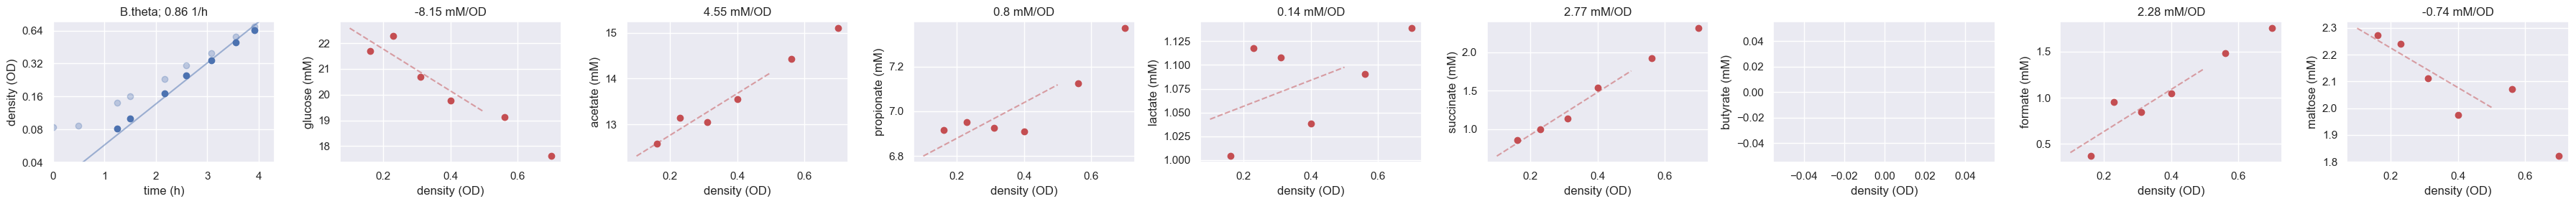

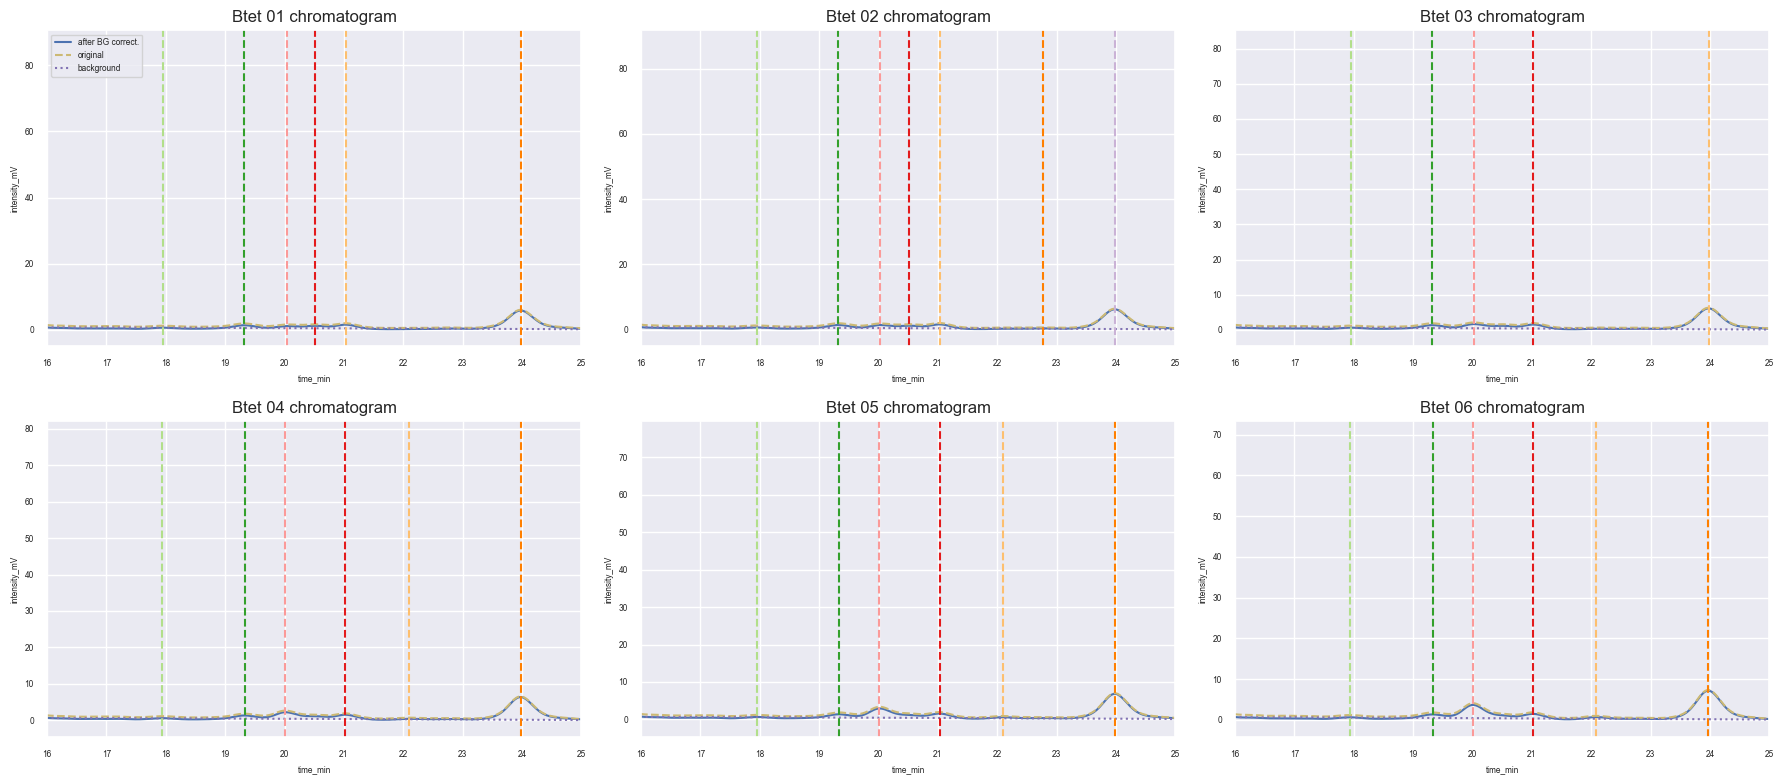

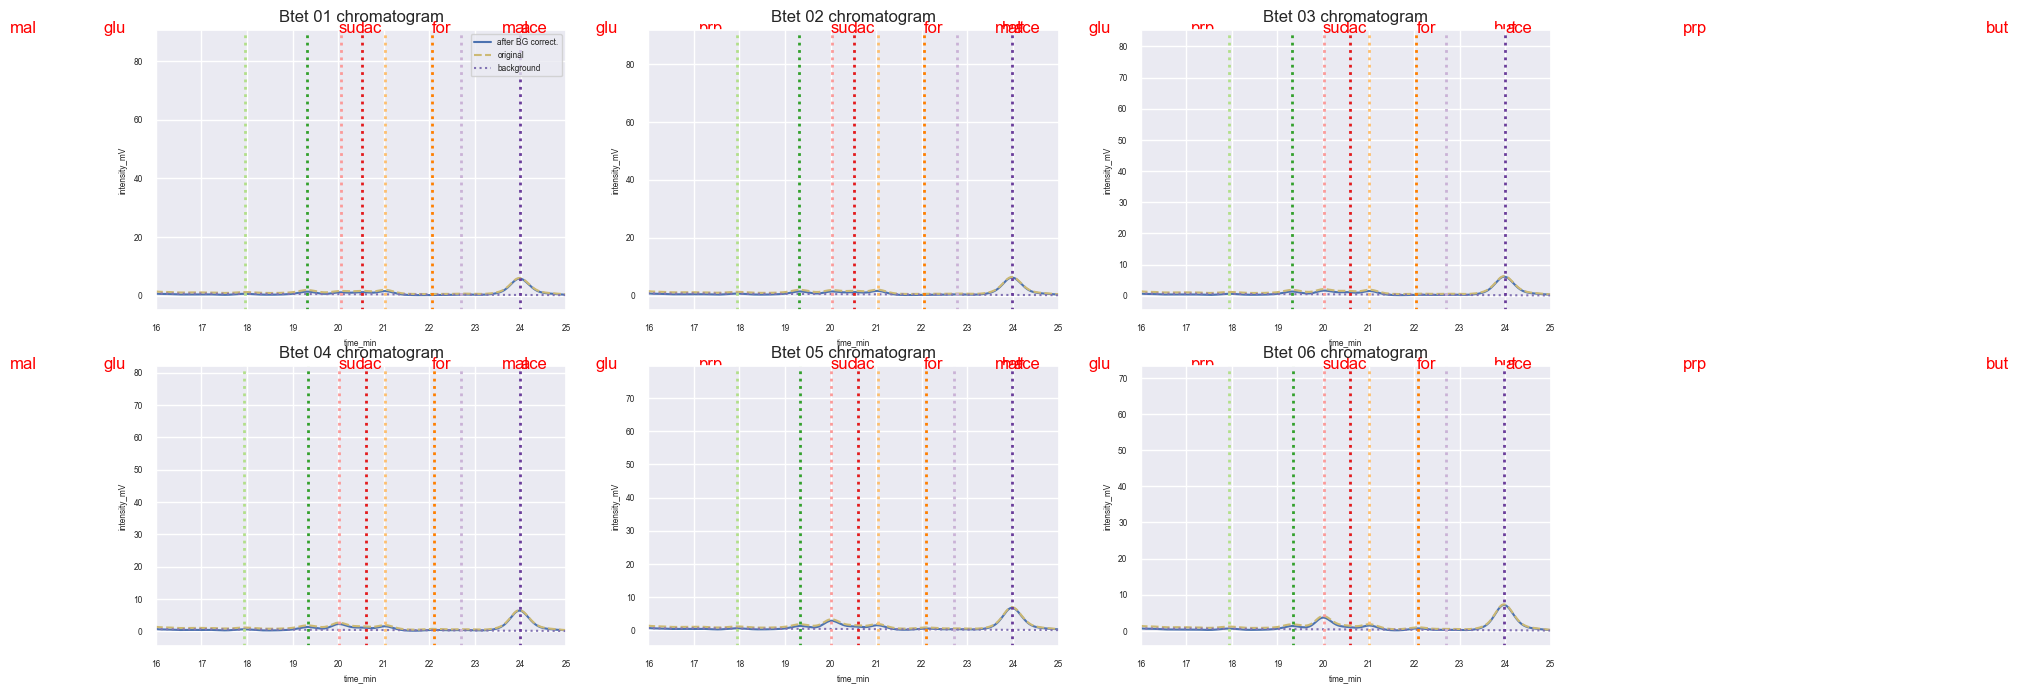

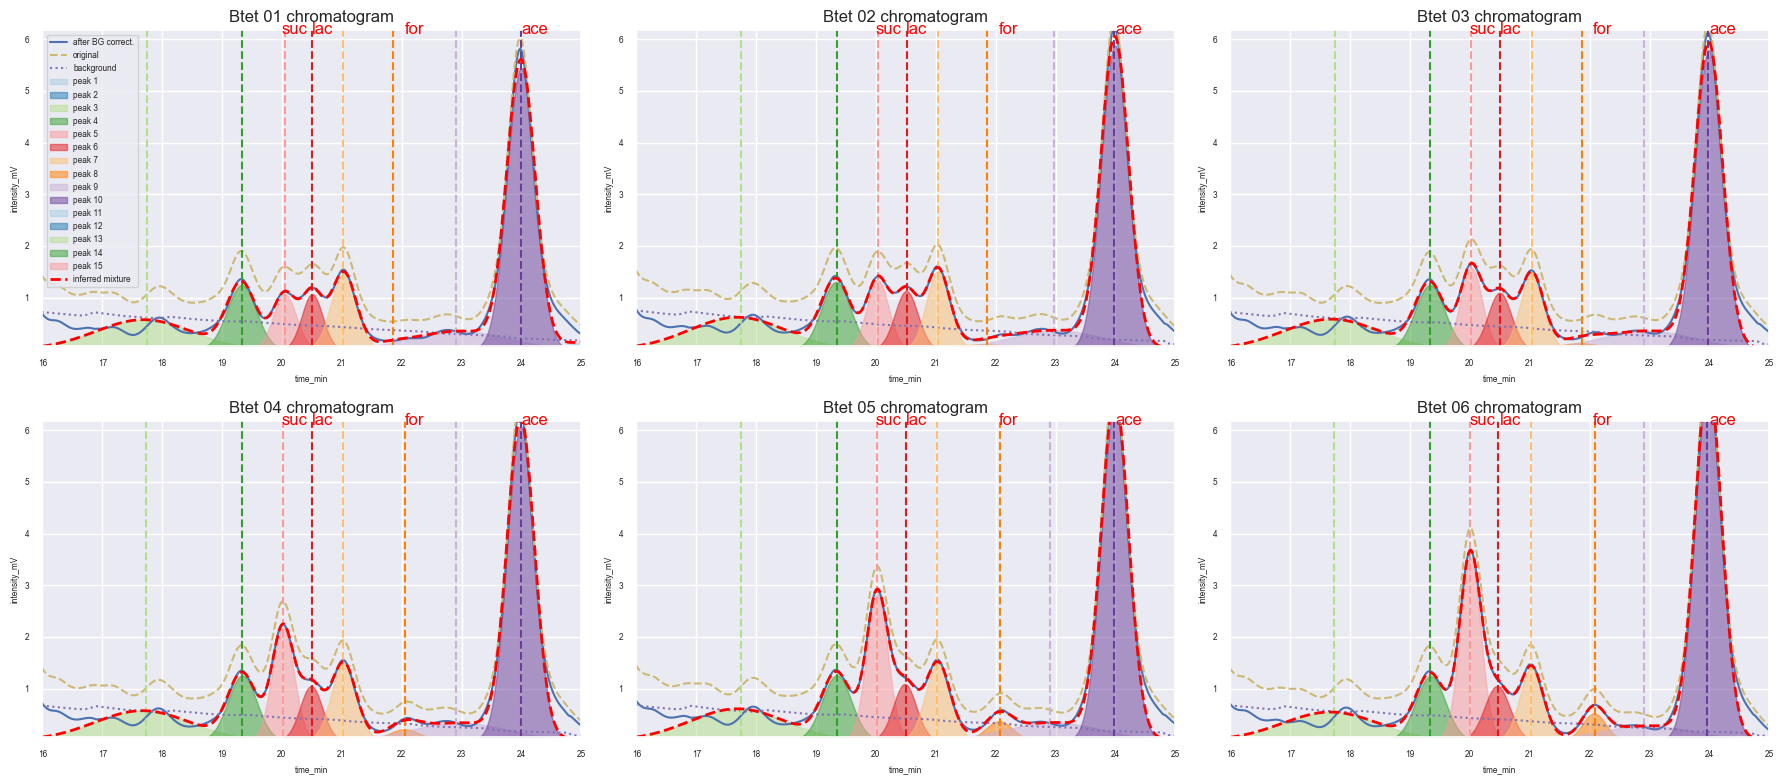

culture  growth-rate        y0  glucose-turnover  glucose_error  \
0  B.theta      0.86352  0.024318         -8.147549       1.167566   

                                         glucose_val  acetate-turnover  \
0  [[0.16, 0.23, 0.31, 0.4, 0.56, 0.7], [21.70679...          4.549411   

   acetate_error                                        acetate_val  \
0       0.150256  [[0.16, 0.23, 0.31, 0.4, 0.56, 0.7], [12.57825...   

   propionate-turnover  ...  \
0             0.796543  ...   

                                       succinate_val butyrate-turnover  \
0  [[0.16, 0.23, 0.31, 0.4, 0.56, 0.7], [0.856095...               NaN   

   butyrate_error  butyrate_val formate-turnover  formate_error  \
0             NaN      [[], []]          2.28336       0.119615   

                                         formate_val maltose-turnover  \
0  [[0.16, 0.23, 0.31, 0.4, 0.56, 0.7], [0.366778...        -0.738966   

   maltose_error                                        maltose_val  
0        0.03212  [[0.16, 0.23, 0.31, 0.4, 0.56, 0.7], [2.272310...  

[1 rows x 27 columns]

In [32]:
#['E.rectale08', 'R.intestinalis08', 'C.aerofaciens08', 'B.theta08', 'E.rectale09', 'R.intestinalis09', 'B.longum09', 'E.rectale11', 'F.prausnitzii11', 'B.longum11', 'B.adolescentis11', 'B.theta', 'R.intestinalis12', 'R.intestinalis14', 'F.prausnitzii14-1', 'F.prausnitzii14-2', 'C.aerofaciens14-1', 'C.aerofaciens14-2', 'B.adolescentis09', 'C.aerofaciens09', 'B.theta09', 'F.prausnitzii10']


#Overall this looks really good! But, acetate peak seems to be underestimated (falls less steep than fit predicts). Somehow the maltose fitting does not work. 

#Done
#'B.longum08'
#peak assignment adjusted: acetate, lactate

#1. Set name of spreadsheet wit/h growth curves. Spreadsheet needs to be saved as csv file in data_growthdata
runc="Zur_Newruns_2023_June"

#2. Decide which growth curve in spreadsheed to run. 
#culture_list="All" #Analyses all growth curves in 
culture_list="All" #["C.aerofaciens08"] #the culture names need to name the corresponding column names in the spreadsheed with growth curves.
#culture_list=['B.theta', 'R.intestinalis12', 'R.intestinalis14', 'F.prausnitzii14-1', 'F.prausnitzii14-2', 'C.aerofaciens14-1', 'C.aerofaciens14-2', 'B.adolescentis09', 'C.aerofaciens09', 'B.theta09', 'F.prausnitzii10']


culture_list=['E.rectale08', 'R.intestinalis08', 'B.longum08', 'B.adolescentis08', 'C.aerofaciens08', 'B.theta08', 'E.rectale09', 'R.intestinalis09', 'B.longum09', 'E.rectale11', 'F.prausnitzii11', 'B.longum11', 'B.adolescentis11', 'R.intestinalis12', 'R.intestinalis14', 'F.prausnitzii14-1', 'F.prausnitzii14-2', 'C.aerofaciens14-1', 'C.aerofaciens14-2', 'B.adolescentis09', 'C.aerofaciens09', 'B.theta09', 'F.prausnitzii10']
#still missing

culture_list=['B.theta']
#'B.adolescentis11', 'B.theta', 
#does not run:
#'B.adolescentis11'

#3. Make sure options for HPLC settings are set. 
# Set name of spreadsheet which contains all settings to analyze the HPLC chromatograms
filename_settings="hplc_settings_Zurich.csv"
#Make sure all hplc samples part of the growth curves are needed. In the spreadsheet set also, which calibration and peak assignment file to use. 

#For analysis, you can also temporarily overwrite the settings in the settings file and provide here manual peak positions and the time interval to use for analyze. Only do this temporarily and have final settings stored in the settings table.
analysis_window=None #[12,20] #[12,20] #Sets time interval to analyze. Overwrites settings from settings table if not None.

#for B.longum, and B.adolescentis,C.aerofaciens08
#peakpositions=[21.75,20.0,20.5,21,21.5,23.1,27.2,28.2,35.8] #[15]#None #[18.7] #Sets manual peak positions. Overwrites settings from settings table if not None.
#for B.theta08
#peakpositions=[21.75,20.0,20.5,20.7,21,21.5,23.1,27.2,28.2,35.8]
#for C.aerofaciens08 ....what is the beak at 21.0? Is 21.0 or 22.0 formate?
peakpositions=None#[18.7,19.8,20.0,20.2,20.5,20.7,21,21.5,21.75,22.1,22.5,22.7,24,27.2,28.2,35.8]
#E.reactale, R.intestinalis
peakpositions=None#[18.7,19.8,20.0,20.2,20.5,20.7,21,21.5,21.75,22.1,22.5,22.7,24,27.2,28.2,35.8]

peakpositions=[12.8,15.2,18.2,19.6,20.3,20.8,21.3,22.3,24.4,27.5,28.4]
peakpositions=[12.8,15.2,17.9,19.3,20.05,20.6,20.95,22.05,22.7,23.9,26.2,28.1,35.8]

#None# [18.7,19.8,20.0,20.2,20.5,20.7,21,21.5,21.75,22.1,22.5,22.7,24,27.2,28.2,35.8]


plot_upper_limit=None#5 #Provide upper limit of intensity when plotting. Autoscaling if None. 
plot_lower_limit=None #Provide lower limit of intensity when plotting. Autoscaling if None
plot_time_window=[16,25] #Provide time-interval to use in plots. Auto adjustment if None. 
display_fullpeaklist=True #Set True if output should provide all detected peaks. 

cremerlab.hplc.process_growth_curve(runc,folder_hplcdata=None,analysis_window=analysis_window,peakpositions=peakpositions,culture_list=culture_list,filename_settings=filename_settings,folder_output="output_growthanalysis", plot_upper_limit=plot_upper_limit,plot_lower_limit=plot_lower_limit,display_fullpeaklist=display_fullpeaklist,plot_time_window=plot_time_window)

# Analysis data Palo Alto

In [55]:

#1. Set name of spreadsheet with growth curves. Spreadsheet needs to be saved as csv file in data_growthdata
runc="Stan_YCA_yield_expt_230607_2.5mM"

#2. Decide which growth curve in spreadsheed to run. 
#culture_list="All" #Analyses all growth curves in 
culture_list=["E.rectale08"] #the culture names need to name the corresponding column names in the spreadsheed with growth curves.

#3. Make sure options for HPLC settings are set. 
# Set name of spreadsheet which contains all settings to analyze the HPLC chromatograms
filename_settings="hplc_settings.csv"
#Make sure all hplc samples part of the growth curves are needed. In the spreadsheet set also, which calibration and peak assignment file to use. 

#For analysis, you can also overwrite the settings in the settings file and provide here manual peak positions and the time interval to analyze. Only do this temporarily.
analysis_window=None #[12,20] #Sets time interval to analyze. Overwrites settings from settings table if not None.
peakpositions=None #[18.7] #Sets manual peak positions. Overwrites settings from settings table if not None.
peak_assignment=None #"peakinfo_standard_Zurich"


#4. Run analysis.
plot_upper_limit=5
plot_lower_limit=None #
plot_time_window=[20,25] #Provide time-interval to use in plots. Auto adjustment if none. 
display_fullpeaklist=True #Set True if output should provide all detected peaks. 

cremerlab.hplc.process_growth_curve(runc,folder_hplcdata=None,analysis_window=analysis_window,peakpositions=peakpositions,culture_list=culture_list,filename_settings=filename_settings,folder_output="output_growthanalysis", plot_upper_limit=plot_upper_limit,plot_lower_limit=plot_lower_limit,display_fullpeaklist=display_fullpeaklist,plot_time_window=plot_time_window)

All cultures in growth rate file data_growthcurves/Stan_YCA_yield_expt_230607_2.5mM.csv:
['R.bromii', 'R.bromii2', 'P.distastonis3', 'B.fragilis3', 'B.ovatus3', 'B.vulgatus3', 'B.finegoldii3']


UnboundLocalError: cannot access local variable 'peaks' where it is not associated with a value

# Step 1: Prepare for analysis: Name peaks of interest, provide corresponding range of retention times, and provide names of calibration curves. 

In [1]:

'''
growthrates_bystrain=pd.DataFrame()
try:
    growthrates_bystrain=pd.read_csv("data/growthrates.csv")
except:
    growthrates_bystrain=pd.DataFrame()
''' 
#R. intestinalis in Epsilon medium; Bacteroides and E. coli in simple media)
#Note: Simple medium for Bacteroides is Epsilon without tryptone and for E. coli it is N-C- with Glucose.
#Output files are in:  jupyter>>data>>yield_expt_R.intestinalis & yield_expt_simple_media
#Excel file (for growth rate) is in:  jupyter>>data>>ecor_yield>>yield_scfa & yield_scfa_simple_medium
    
#foldername='yield_expt_modified_epsilon_rt50min'

#make sure foldername has same name as this sheet name
#for growthcondition in ["yield_expt_modified_epsilon_rt5","yield_expt_modified_epsilon"]: #
#yield_expt_090222_modified_epsi
#yield_expt_modified_epsilon_rt5

#run October
#Markus in Zurich

#runc="Markus_102022"
#samplelistc=['B.theta','R.intestinalis','E.faecalis','E.rectale']
#samplelistc=['R.intestinalis']

#runc="BHI-FP-Dec13"
#samplelistc=['F.prausnitzii','F.prausnitzii2','F.prausnitzii3']

#runc="BHI-Richa-22Dec24"
#samplelistc=['B.vulgatus','B.vulgatus2','B.finegoldii','B.finegoldii2','F.prausnitzii','F.prausnitzii2','P.distastonis','P.distastonis2']

runc="YCA_yield_expt_2.5mM_Apr23"
samplelistc=['NCM','NCM2','B.fragilis','B.fragilis2','B.vulgatus','B.vulgatus2','B.finegoldii','B.finegoldii2','B.ovatus','B.ovatus2','P.distastonis','P.distastonis2','P.copri','P.copri2']
samplelistc=['P.distastonis2']

#runc="YCA_yield_expt_1.25mM_Apr23"
#samplelistc=['NCM','NCM_2','B.fragilis','B.fragilis_2','B.vulgatus','B.vulgatus_2','B.finegoldii','B.finegoldii_2','B.ovatus','B.ovatus_2','P.distastonis','P.distastonis_2','P.copri','P.copri_2']

runc="YCA_yield_expt_230607_2.5mM"
samplelistc=["P.copri3","P.copri4","R.bromii","R.bromii2","P.distastonis3","B.fragilis3","B.ovatus3","B.vulgatus3","B.finegoldii3"]

runc="YCA_yield_expt_230607_2.5mM"

#new runs with 1.25ml sulfuric acid. To find propionate peak
#runc="BHI_yield_expt_Jan2023_125sulf"
#samplelistc=["B.finegoldii","B.finegoldii_2","P.distastonis","P.distastonis_2","E.coli","E.coli_2","B.theta","B.theta_2","B.ovatus","B.ovatus_2","B.longum","B.longum_2","B.fragilis","B.fragilis_2","E.rectale","E.rectale_2","B.adolescentis","B.adolescentis_2","B.vulgatus","B.vulgatus_2","P.copri","P.copri_2"]

#runc="BHI-Richa-22Dec30"
#samplelistc=['E.coli','E.coli_2','B.theta','B.theta_2','B.ovatus','B.ovatus_2','B.fragilis','B.fragilis_2','B.longum','B.longum_2',"E.rectale","E.rectale_2","B.adolescentis","B.adolescentis_2","P.copri","P.copri_2","B.vulgatus","B.vulgatus_2"]

#B.theta 1 - samples 5 and 6
#E.rectatle 1 - samples 4 and 5
#E.rectatel 2 - samples 4 and 5

#"E.rectale","E.rectale_2","B.adolescentis","B.adolescentis_2","P.copri","P.copri_2","B.vulgatus","B.vulgatus_2"]
#,,]


#run December BHI test
#no tryptone
#runc="BHI-Dec6"
#samplelistc=['R.bromii','F.prausnitzii','R.Bromii','B.theta','B.fragilis','B.vulgatus']
#samplelistc=['F.prausnitzii']

#runc="TG2022-Friday"
#samplelistc=['E.eligens', 'P.copri','E.coli','E.hallii','R.bromii','R.intestinalis','B.longum','B.adolescentis','C.aerofaciens']

#run thanks giving
#no tryptone
#runc="TG2022-Monday"
#samplelistc=['E.coli','E.coli.2','E.hallii','E.hallii.2','E.eligens','E.eligens.2','E.faecium','E.faecium.2','R.intestinalis','R.intestinalis.2']
#runc="TG2022-Friday"
#samplelistc=['E.eligens', 'P.copri','E.coli','E.hallii','R.bromii','R.intestinalis','B.longum','B.adolescentis','C.aerofaciens']

#runc="TG2022-SaturdaySunday"
#samplelistc=['P.copri','B.longum','R.bromii','C.aerofaciens','B.adolescentis','R.intestinalis','R.bromii.2','GE514','R.bromii.2','R.bromii.3','E.halli','F.prausnitzii','Fp72']
#samplelistc=['E.coli','E.hallii', 'E.eligens', 'E.faecium', 'B.longum', 'R.bromii', 'P.copri', 'C.aerofaciens', 'B.adolescentis', 'R.intestinalis', 'R.bromii', '514', 'F.prausnitzii', 'Fp72']

#samplelistc=['B.longum','R.bromii.3','R.bromii.4']

#tryptone
#runc="yield_exp_1022_wtrp"
#samplelistc=['B.fragilis','B.theta','B.ovatus','P.copri','NCM']

#repeat hplc runs for run 3
#runc="yield_expt_090622_rerun_sep2nd"
#samplelistc=['B.fragilis','B.theta','B.ovatus','C.aerofaciens','E.rectale','P.copri','R.bromii','R.intestinalis']

#fecal run - no tryothon
#runc="yield_expt_090822_fecPc_woTryp"
#samplelistc=['P.copri','Fecal1','Fecal2','Fecal4','FecalPP']

#runc="yield_mGAM_fecal_samples_rt50"
#samplelistc=['P.copri','Fecal1','Fecal2','Fecal4','FecalPP']

#run 2
#runc="yield_expt_modified_epsilon_rt5"
#samplelistc=['B.adolescentis','B.fragilis','B.longum','B.theta','C.aerofaciens','E.halli','E.rectale','F.prausnitzii','E.coli','P.copri','R.bromii','R.intestinalis']

#run 1
#runc="yield_expt_modified_epsilon"
#samplelistc=['B.adolescentis','B.fragilis','B.longum','B.ovatus','B.theta','C.aerofaciens','E.halli','E.rectale','F.prausnitzii','E.coli','P.copri','R.bromii','R.intestinalis']

#runc="yield_scfa_simple_medium"
#samplelistc=['ECOR02','ECOR63','NCM3722','B.fragilis','B.ovatus','B.theta']



#runc="YCA_yield_expt_230607_2.5mM"
#raw_calib_files = glob.glob('data_hplc/'+runc+'/*.txt') #this gives list of the files
#display(raw_calib_files)
#display(raw_calib_files)
#cremerlab.hplc.convert(raw_calib_files) #convert into simple txt iles with chromatogram info (and some metadata as comments)


NameError: name 'cremerlab' is not defined